Data loading and cleaning

In [2]:
import pandas as pd
from io import StringIO

with open("100_Portfolios_ME_OP_10x10_daily.csv", "r") as f:
    lines = f.readlines()


In [3]:
from itertools import islice
from io import StringIO
import pandas as pd
import re

# Path to your uploaded file
path = "100_Portfolios_ME_OP_10x10_daily.csv"

# Row range (inclusive)
start, end = 15695, 31361

# --- Step 1: Extract only those rows from the file ---
with open(path, "r", newline="") as f:
    block = list(islice(f, start, end + 1))

# --- Step 2: Clean each line ---
clean_block = []
for s in block:
    s = s.strip()                       # remove \n and spaces
    if not s:
        continue                        # skip empty lines
    s = re.sub(r",\s*$", "", s)         # drop trailing comma if present
    clean_block.append(s)

# --- Step 3: Build a CSV buffer and load with pandas ---
buf = StringIO("\n".join(clean_block))
df = pd.read_csv(buf, sep=",", skipinitialspace=True)

# --- Step 4: Ensure first column is 'date' and convert to datetime ---
if df.columns[0] != "date":
    df = df.rename(columns={df.columns[0]: "date"})

df["date"] = pd.to_datetime(df["date"].astype(str), format="%Y%m%d", errors="coerce")
df = df.set_index("date").sort_index()
df = df[~df.index.isna()]   # drop rows with invalid dates

# --- Step 5: Convert all other columns to numeric ---
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print(df.shape)
print(df.index.min(), "→", df.index.max())
print(df.head())


(15665, 100)
1963-07-03 00:00:00 → 2025-09-30 00:00:00
            0.36  0.27  0.49  0.31  0.67  0.13  0.79  -0.45  -0.10  -0.24  \
date                                                                        
1963-07-03  0.74  0.77 -0.51  0.06  0.16  0.87  0.06   1.04   0.18   0.66   
1963-07-05  0.71  0.19  0.70  0.66  0.05 -0.44  0.58  -0.53   0.08   0.15   
1963-07-08 -0.21 -1.40 -0.24 -1.01 -1.33  0.14 -0.79   0.16  -1.59   0.31   
1963-07-09 -0.38  0.58 -0.21 -0.76  0.95  1.01  2.02  -0.24   0.03   0.15   
1963-07-10  0.10 -0.11  1.30  0.50  1.57  0.86  0.27   1.97  -0.10  -0.15   

            ...  0.81.1  0.87  1.16  0.67.1  0.59  0.35  0.78.4  0.96  0.92.2  \
date        ...                                                                 
1963-07-03  ...   -0.26  0.10  0.78    0.89  0.67  0.20    0.53  1.04    0.43   
1963-07-05  ...    0.26  0.66  0.33    0.53  0.11  0.16    0.64  0.57    0.31   
1963-07-08  ...   -0.05 -0.12 -0.67   -0.62 -0.75  0.04   -0.21 -0.68   -0.38   


In [4]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15665 entries, 1963-07-03 to 2025-09-30
Data columns (total 100 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   0.36     15665 non-null  float64
 1   0.27     15665 non-null  float64
 2   0.49     15665 non-null  float64
 3   0.31     15665 non-null  float64
 4   0.67     15665 non-null  float64
 5   0.13     15665 non-null  float64
 6   0.79     15665 non-null  float64
 7   -0.45    15665 non-null  float64
 8   -0.10    15665 non-null  float64
 9   -0.24    15665 non-null  float64
 10  0.48     15665 non-null  float64
 11  0.37     15665 non-null  float64
 12  1.45     15665 non-null  float64
 13  0.76     15665 non-null  float64
 14  1.37     15665 non-null  float64
 15  1.79     15665 non-null  float64
 16  1.26     15665 non-null  float64
 17  0.77     15665 non-null  float64
 18  0.78     15665 non-null  float64
 19  -0.28    15665 non-null  float64
 20  0.10     15665 non-null  float64

In [5]:
returns_df = df

# BONUS CODE

- changed the start date to "2023-07-03" instead of "2024-07-03" based on the feedback to increase the dataset used

- RESULTS FOR CHOSEN MODEL

In [6]:
# ===================== Stacked-models pipeline (raw + denoised) =====================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV, Ridge

# --------------------- Config ---------------------
START_DATE   = "2023-07-03"     # changed from "2024-07-03"
WINDOW       = 126
INNER_VAL    = 21
K_GRID       = [5, 10, 15]
ALPHAS_RIDGE = np.logspace(-8, 4, 50)
ALPHAS_LASSO = np.logspace(-8, 4, 50)
TRADING_DAYS = 252

# --------------------- Helpers ---------------------
def normalize_budget(w):
    s = w.sum()
    return w/s if s != 0 else w

def regression_reframe(R_window):
    """ y = R w_EW,  X = R N  where N maps (p-1) free params to full-investment weights """
    T, p = R_window.shape
    w_ew = np.ones(p) / p
    N    = np.vstack([np.eye(p-1), -np.ones((1, p-1))])  # p x (p-1)
    y    = R_window @ w_ew
    X    = R_window @ N
    return y, X, w_ew, N

def sharpe_ratio(s):
    s = pd.Series(s).dropna()
    sd = s.std(ddof=1)
    return s.mean()/sd if sd>0 else np.nan

def ann_sharpe(d):
    d = pd.Series(d).dropna()
    sd = d.std(ddof=1)
    return np.sqrt(TRADING_DAYS) * (d.mean()/sd) if sd>0 else np.nan

def ann_return(d):
    d = pd.Series(d).dropna()
    if len(d)==0: return np.nan
    wealth = (1.0 + d).prod()
    years  = len(d)/TRADING_DAYS
    return wealth**(1/years) - 1

# --- Denoise a window of returns via top-k PCs in the time dimension ---
def denoise_returns(R_window, k_top=10):
    R_centered = R_window - R_window.mean(axis=0)
    U, S, Vt   = np.linalg.svd(R_centered, full_matrices=False)
    S_shrunk   = np.zeros_like(S); S_shrunk[:k_top] = S[:k_top]
    return U @ np.diag(S_shrunk) @ Vt + R_window.mean(axis=0)

- rolling window backtest

In [7]:
def backtest_EW_PCA_ensemble_denoised(
    returns_df,
    window=WINDOW,
    inner_val=INNER_VAL,
    k_grid=K_GRID,
    alphas_ridge=ALPHAS_RIDGE,
    alphas_lasso=ALPHAS_LASSO,
    k_denoise=10,
    test_start=None,
    test_end=None
):
    dates = returns_df.index
    p = returns_df.shape[1]
    oos = []

    for t in range(window, len(dates)):
        # Skip before test period
        if test_start is not None and dates[t] < pd.to_datetime(test_start):
            continue
        # Stop after test period
        if test_end is not None and dates[t] > pd.to_datetime(test_end):
            break

        # raw window
        R_window = returns_df.iloc[t-window:t,:].values

        # --- Denoise the returns ---
        Rw = denoise_returns(R_window, k_top=k_denoise)

        # --- Regression frame ---
        y, X, w_ew, N = regression_reframe(Rw)

        # --- Train/Validation Split ---
        X_tr, X_val = X[:-inner_val,:], X[-inner_val:,:]
        y_tr, y_val = y[:-inner_val], y[-inner_val:]

        # --- PCA + Ridge/LASSO Forecasts ---
        forecasts_tr, forecasts_val, best_params = [], [], []
        for k in k_grid:
            pca = PCA(n_components=k).fit(X_tr)
            Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)

            # Ridge
            ridge = RidgeCV(alphas=alphas_ridge).fit(Z_tr, y_tr)
            forecasts_val.append(ridge.predict(Z_val))
            forecasts_tr.append(ridge.predict(Z_tr))
            best_params.append(('ridge', k, ridge.alpha_))

            # LASSO
            lasso = LassoCV(alphas=alphas_lasso, cv=5, max_iter=5000).fit(Z_tr, y_tr)
            forecasts_val.append(lasso.predict(Z_val))
            forecasts_tr.append(lasso.predict(Z_tr))
            best_params.append(('lasso', k, lasso.alpha_))

        # --- Stack via Ridge on validation ---
        X_stack_tr = np.column_stack(forecasts_tr)
        X_stack_val = np.column_stack(forecasts_val)
        meta_model = Ridge(alpha=1e-3).fit(X_stack_tr, y_tr)
        y_hat_final = meta_model.predict(X_stack_val)

        # --- Refit chosen model on full window ---
        best_idx = np.argmax([sharpe_ratio(f) for f in forecasts_val])
        model_type, k_star, alpha_star = best_params[best_idx]

        pca_final = PCA(n_components=k_star).fit(X)
        Z_full = pca_final.transform(X)

        if model_type == 'ridge':
            base_model = Ridge(alpha=alpha_star).fit(Z_full, y)
        else:
            base_model = LassoCV(alphas=[alpha_star], cv=None, max_iter=5000).fit(Z_full, y)

        beta = pca_final.components_.T @ base_model.coef_
        w = normalize_budget(w_ew - (N @ beta))

        # --- Out-of-sample return for this test day ---
        r_next = returns_df.iloc[t,:].values @ w
        oos.append((dates[t], float(r_next)))

    return pd.Series([r for _, r in oos],
                     index=[d for d,_ in oos],
                     name=f"EW+PCA+Ridge/LASSO Stacked (denoised k={k_denoise})")

In [9]:
START_DATE = "2023-07-03"
VAL_START  = "2025-06-01"
TEST_START = "2025-08-01"
TEST_END   = "2025-09-30"

df = returns_df.copy()
df = df.loc[START_DATE:]                     
df = df.dropna(how="any")  

test_results = backtest_EW_PCA_ensemble_denoised(
    df,
    test_start=TEST_START,
    test_end=TEST_END
)

In [10]:
sr = sharpe_ratio(test_results)
print(f"Non-annualized Sharpe (Aug–Sep 2025): {sr:.3f}")

Non-annualized Sharpe (Aug–Sep 2025): 0.308


- single fit before 2025-08-01, then static weights (buy-and-hold-style test)

=== August & September 2025 — Unseen test (static weights from 126d up to 2025-07-31) ===
Chosen base: PCA+Ridge (k=5, alpha=1e-08),  validation Sharpe (inner): 0.419
Non-annualized Sharpe (Aug): 0.366
Annualized Sharpe (Aug):     5.814


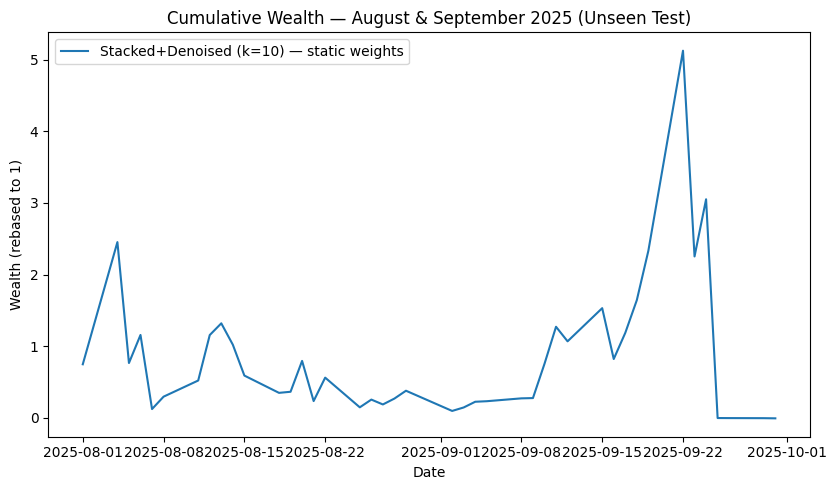

In [8]:
# ===================== Test on unseen August 2025 onwards (Stacked + Denoised k=10) =====================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV

# --- assumes these exist from your previous cell ---
# WINDOW = 126
# INNER_VAL = 21
# TRADING_DAYS = 252
# denoise_returns, regression_reframe, normalize_budget, ann_sharpe, ann_return, sharpe_ratio

def fit_stacked_denoised_k10_on_window(R_window, k_denoise=10, k_grid=(5,10,15),
                                       alphas_ridge=np.logspace(-8,4,50),
                                       alphas_lasso=np.logspace(-8,4,50),
                                       inner_val=INNER_VAL):
    """
    Train the stacked-denoised (k=10) model ONCE on a given window (T x p) and return a single weight vector.
    Uses the same selection logic as your rolling function:
      - Denoise (SVD top-k)
      - Reframe y=Rw_EW, X=RN
      - Time-aware inner split
      - Try PCA(k)+Ridge and PCA(k)+LASSO; pick by validation Sharpe
      - Refit on full window and map back to weights w = w_EW - N beta
    """
    # 1) Denoise
    Rw = denoise_returns(R_window, k_top=k_denoise)

    # 2) EW reframe
    y, X, w_ew, N = regression_reframe(Rw)

    # 3) Inner split
    if len(X) <= inner_val + 5:
        raise ValueError("Not enough observations in the training window for inner validation.")
    X_tr, X_val = X[:-inner_val, :], X[-inner_val:, :]
    y_tr, y_val = y[:-inner_val],   y[-inner_val:]

    # 4) Model selection
    best_score, best_params = -np.inf, ("ridge", k_grid[0], alphas_ridge[0])
    for k in k_grid:
        pca  = PCA(n_components=k).fit(X_tr)
        Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)

        # Ridge branch
        ridge = RidgeCV(alphas=alphas_ridge).fit(Z_tr, y_tr)
        yhat_r = ridge.predict(Z_val)
        sr_r   = sharpe_ratio(yhat_r)
        if sr_r > best_score:
            best_score, best_params = sr_r, ("ridge", k, ridge.alpha_)

        # LASSO branch
        lasso = LassoCV(alphas=alphas_lasso, cv=5, max_iter=5000).fit(Z_tr, y_tr)
        yhat_l = lasso.predict(Z_val)
        sr_l   = sharpe_ratio(yhat_l)
        if sr_l > best_score:
            best_score, best_params = sr_l, ("lasso", k, lasso.alpha_)

    # 5) Refit on full window with chosen params
    mtype, k_star, alpha_star = best_params
    pca_full = PCA(n_components=k_star).fit(X)
    Z_full   = pca_full.transform(X)

    if mtype == "ridge":
        base = RidgeCV(alphas=[alpha_star]).fit(Z_full, y)
        beta = pca_full.components_.T @ base.coef_
    else:
        base = LassoCV(alphas=[alpha_star], cv=None, max_iter=5000).fit(Z_full, y)
        beta = pca_full.components_.T @ base.coef_

    w = normalize_budget(w_ew - (N @ beta))

    meta = {"model": f"PCA+{mtype.capitalize()} (k={k_star}, alpha={alpha_star:.3g})",
            "val_sharpe": float(best_score), "k_denoise": k_denoise}
    return w, meta

def test_august_2025_stacked_denoised_k10(returns_df,
                                          train_end="2025-07-31",
                                          test_start="2025-08-01",
                                          test_end="2025-09-30",
                                          window=WINDOW):
    """
    Fit once on last `window` days up to `train_end`, then apply STATIC weights to daily returns in Aug 2025.
    No August data are used in fitting.
    """
    # 0) basic checks and slicing
    df = returns_df.sort_index().copy()
    if train_end not in df.index:
        # pick the last available date <= train_end
        train_end = df.index[df.index.get_indexer([train_end], method="pad")[0]]
    train_slice = df.loc[:train_end].tail(window)
    if len(train_slice) < window:
        raise ValueError(f"Need at least {window} training days before {train_end}.")

    # 1) fit on training window (up to 2025-07-31)
    w, meta = fit_stacked_denoised_k10_on_window(train_slice.values, k_denoise=10)

    # 2) evaluate on Aug 2025
    test_df = df.loc[test_start:test_end]
    if test_df.empty:
        raise ValueError("No test rows found for the requested August 2025 window.")
    test_ret = pd.Series(test_df.values @ w, index=test_df.index, name="Stacked+Denoised(k=10) [static weights]")

    # 3) metrics
    sr = sharpe_ratio(test_ret)         # non-annualized
    sr_ann = ann_sharpe(test_ret)       # optional
    ar_ann = ann_return(test_ret)       # optional

    print("=== August & September 2025 — Unseen test (static weights from 126d up to 2025-07-31) ===")
    print(f"Chosen base: {meta['model']},  validation Sharpe (inner): {meta['val_sharpe']:.3f}")
    print(f"Non-annualized Sharpe (Aug): {sr:.3f}")
    print(f"Annualized Sharpe (Aug):     {sr_ann:.3f}")

    # 4) plot cumulative wealth over August
    cum = (1.0 + test_ret).cumprod()
    plt.figure(figsize=(8.5,5))
    plt.plot(cum.index, cum.values, label="Stacked+Denoised (k=10) — static weights")
    plt.title("Cumulative Wealth — August & September 2025 (Unseen Test)")
    plt.ylabel("Wealth (rebased to 1)")
    plt.xlabel("Date")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5) return for further analysis
    return test_ret, w, meta

# --------- Run the unseen-August test ----------
# Expect: `returns_df` contains daily DECIMAL returns with Aug-2025 rows present
aug_series, aug_weights, aug_meta = test_august_2025_stacked_denoised_k10(returns_df)

- LASSO & RIDGE

/Users/shrutijha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034614430982813985, tolerance: 0.01310504496524
  model = cd_fast.enet_coordinate_descent_gram(
/Users/shrutijha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02284069086192815, tolerance: 0.011215515179445544
  model = cd_fast.enet_coordinate_descent_gram(
/Users/shrutijha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16376615555502463, tolerance: 0.01327703139019802
  model = cd_fast.enet_coordinate_descent_gram(
/Users/shrutijha/anaconda3/lib/python3.11/si

Annualized Sharpe (OOS; start after 126d from 2023-07-03):
EW                      : 0.678
MinVar (plain)          : 0.263
EW + LASSO (reg)        : 1.457
EW + Ridge (reg)        : 1.603
MinVar + Ridge (γ=0.001): 0.425
MinVar + LASSO (γ=0.001): 0.520
Daily Sharpe (OOS; start after 126d from 2023-07-03):
EW                      : 0.043
MinVar (plain)          : 0.017
EW + LASSO (reg)        : 0.092
EW + Ridge (reg)        : 0.101
MinVar + Ridge (γ=0.001): 0.027
MinVar + LASSO (γ=0.001): 0.033


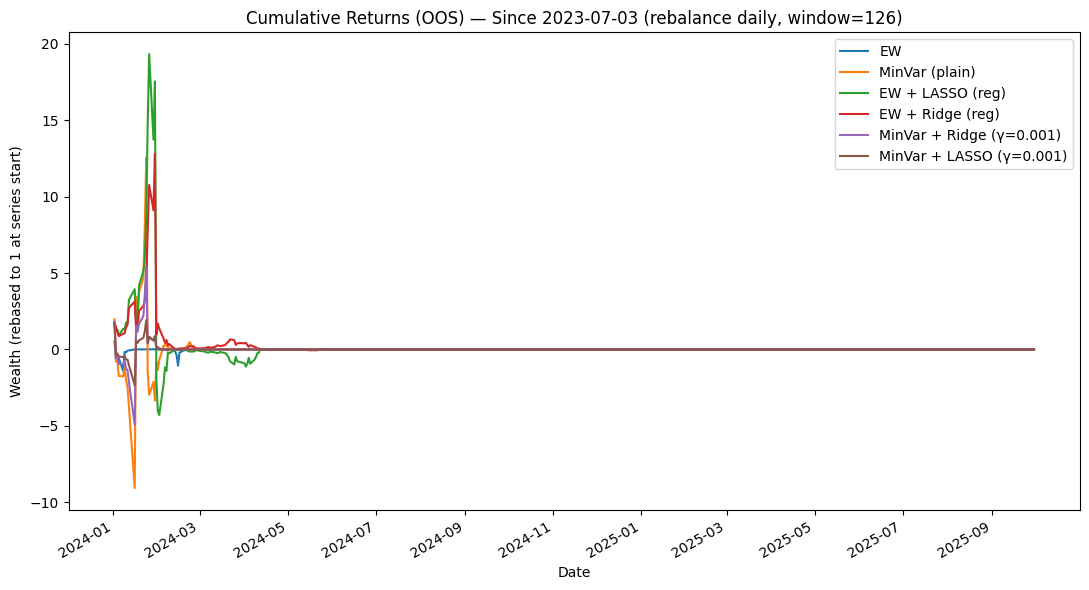

In [11]:
# --- Imports ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, RidgeCV

# If you want MinVar+LASSO (weight L1-penalty), we use cvxpy:
import cvxpy as cp

# -----------------------------
# CONFIG
# -----------------------------
WINDOW = 126                         # rolling lookback
ALPHAS = np.logspace(-8, 8, 21)     # CV grid for LASSO/Ridge (regression)
GAMMA_RIDGE = 1e-3                   # weight L2-penalty for MinVar+Ridge
GAMMA_LASSO = 1e-3                   # weight L1-penalty for MinVar+LASSO
START_DATE = "2023-07-03"            # consider data since this date only

# -----------------------------
# Helpers
# -----------------------------
def annualized_sharpe(s, trading_days=252):
    s = pd.Series(s).dropna()
    sd = s.std(ddof=1)
    if sd == 0 or np.isnan(sd): return np.nan
    return np.sqrt(trading_days) * (s.mean() / sd)

def cum_wealth(s):
    return (1.0 + pd.Series(s)).cumprod()

def normalize_budget(w):
    s = w.sum()
    return w / s if s != 0 else w

def build_N_matrix(p):
    I = np.eye(p-1)
    last = -np.ones((1, p-1))
    return np.vstack([I, last])                    # p x (p-1)

def regression_reframe(R_window):
    """y = R w_EW, X = R N"""
    T, p = R_window.shape
    w_ew = np.ones(p) / p
    N = build_N_matrix(p)                          # p x (p-1)
    y = R_window @ w_ew                            # (T,)
    X = R_window @ N                               # (T, p-1)
    return y, X, w_ew, N

def minvar_weights_from_cov(Sigma, eps=0.0):
    """Plain MinVar: w ∝ Σ^{-1} 1 (no penalty)"""
    p = Sigma.shape[0]
    A = Sigma + eps * np.eye(p)
    invA = np.linalg.pinv(A)
    ones = np.ones((p, 1))
    num = invA @ ones
    den = (ones.T @ invA @ ones)[0, 0]
    return (num / den).ravel()

def minvar_ridge_weights_from_cov(Sigma, gamma):
    """MinVar + Ridge on weights: w ∝ (Σ + γI)^{-1} 1"""
    p = Sigma.shape[0]
    A = Sigma + gamma * np.eye(p)
    invA = np.linalg.pinv(A)
    ones = np.ones((p, 1))
    num = invA @ ones
    den = (ones.T @ invA @ ones)[0, 0]
    return (num / den).ravel()

def minvar_lasso_weights_from_cov(Sigma, gamma, solver="OSQP"):
    """MinVar + LASSO on weights: min w'Σw + γ||w||_1 s.t. 1'w=1"""
    p = Sigma.shape[0]
    w = cp.Variable(p)
    objective = cp.quad_form(w, Sigma) + gamma * cp.norm1(w)
    constraints = [cp.sum(w) == 1]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=solver, verbose=False)
    return np.array(w.value).ravel()

# -----------------------------
# Backtests (OOS, rebalanced daily)
# -----------------------------
def backtest_EW(returns_df, window=WINDOW):
    # OOS mean across assets
    ser = returns_df.iloc[window:, :].mean(axis=1)
    ser.name = "EW"
    return ser

def backtest_minvar_plain(returns_df, window=WINDOW):
    out, dates = [], returns_df.index
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t, :].values
        Sigma = np.cov(Rw, rowvar=False)                  # sample cov (ddof=1 default)
        w = minvar_weights_from_cov(Sigma, eps=0.0)       # NO regularization
        out.append((dates[t], float(returns_df.iloc[t, :].values @ w)))
    return pd.Series([r for _, r in out], index=[d for d, _ in out], name="MinVar (plain)")

def backtest_regression_lasso_ridge(returns_df, window=WINDOW, alphas=ALPHAS):
    dates = returns_df.index
    lasso_oos, ridge_oos = [], []
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t, :].values
        y, X, w_ew, N = regression_reframe(Rw)

        # LASSO (regression reframe)
        lasso = LassoCV(alphas=alphas, cv=5, fit_intercept=True,
                        max_iter=10000, n_jobs=-1).fit(X, y)
        beta_l = lasso.coef_
        w_l = normalize_budget(w_ew - (N @ beta_l))

        # Ridge (regression reframe)
        ridge = RidgeCV(alphas=alphas).fit(X, y)
        beta_r = ridge.coef_
        w_r = normalize_budget(w_ew - (N @ beta_r))

        r_next = returns_df.iloc[t, :].values
        lasso_oos.append((dates[t], float(r_next @ w_l)))
        ridge_oos.append((dates[t], float(r_next @ w_r)))

    lasso_ser = pd.Series([r for _, r in lasso_oos], index=[d for d, _ in lasso_oos], name="EW + LASSO (reg)")
    ridge_ser = pd.Series([r for _, r in ridge_oos], index=[d for d, _ in ridge_oos], name="EW + Ridge (reg)")
    return lasso_ser, ridge_ser

def backtest_minvar_ridge(returns_df, window=WINDOW, gamma=GAMMA_RIDGE):
    out, dates = [], returns_df.index
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t, :].values
        Sigma = np.cov(Rw, rowvar=False)
        w = minvar_ridge_weights_from_cov(Sigma, gamma=gamma)
        out.append((dates[t], float(returns_df.iloc[t, :].values @ w)))
    return pd.Series([r for _, r in out], index=[d for d, _ in out], name=f"MinVar + Ridge (γ={gamma:g})")

def backtest_minvar_lasso(returns_df, window=WINDOW, gamma=GAMMA_LASSO, solver="OSQP"):
    out, dates = [], returns_df.index
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t, :].values
        Sigma = np.cov(Rw, rowvar=False)
        w = minvar_lasso_weights_from_cov(Sigma, gamma=gamma, solver=solver)
        w = normalize_budget(w)                           # tidy numerically
        out.append((dates[t], float(returns_df.iloc[t, :].values @ w)))
    return pd.Series([r for _, r in out], index=[d for d, _ in out], name=f"MinVar + LASSO (γ={gamma:g})")

# -----------------------------
# MAIN: slice data, run, compare
# -----------------------------
# Expect: returns_df exists (DECIMAL daily returns, index=Date, columns=assets)
df = returns_df.copy()
df = df.loc[START_DATE:]                      # consider only data since 2025-07-03
df = df.dropna(how="any")                     # keep rows with complete cross-section

# Run all strategies
ew_oos                  = backtest_EW(df, window=WINDOW)
minvar_plain_oos        = backtest_minvar_plain(df, window=WINDOW)
lasso_reg_oos, ridge_reg_oos = backtest_regression_lasso_ridge(df, window=WINDOW, alphas=ALPHAS)
minvar_ridge_oos        = backtest_minvar_ridge(df, window=WINDOW, gamma=GAMMA_RIDGE)
minvar_lasso_oos        = backtest_minvar_lasso(df, window=WINDOW, gamma=GAMMA_LASSO, solver="OSQP")

# Align to common OOS dates
series_list = [ew_oos, minvar_plain_oos, lasso_reg_oos, ridge_reg_oos, minvar_ridge_oos, minvar_lasso_oos]
idx = series_list[0].index
for s in series_list[1:]:
    idx = idx.intersection(s.index)
series_list = [s.loc[idx] for s in series_list]

# Print annualized Sharpe
print("Annualized Sharpe (OOS; start after 126d from 2023-07-03):")
for s in series_list:
    print(f"{s.name:24s}: {annualized_sharpe(s):.3f}")

print("Daily Sharpe (OOS; start after 126d from 2023-07-03):")
for s in series_list:
    print(f"{s.name:24s}: {annualized_sharpe(s)/np.sqrt(252):.3f}")


# Plot cumulative wealth
plt.figure(figsize=(11,6))
for s in series_list:
    cum_wealth(s).plot(label=s.name)
plt.title("Cumulative Returns (OOS) — Since 2023-07-03 (rebalance daily, window=126)")
plt.xlabel("Date"); plt.ylabel("Wealth (rebased to 1 at series start)")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
TEST_START = "2025-08-01" 

print(f"\nAnnualized Sharpe on STRICT TEST OOS (from {TEST_START}):")
for s in series_list:
    s_test = s.loc[TEST_START:]
    print(f"{s.name:24s}: {annualized_sharpe(s_test):.3f}")

print(f"\nDaily Sharpe on STRICT TEST OOS (from {TEST_START}):")
for s in series_list:
    s_test = s.loc[TEST_START:]
    print(f"{s.name:24s}: {annualized_sharpe(s_test)/np.sqrt(252):.3f}")


Annualized Sharpe on STRICT TEST OOS (from 2025-08-01):
EW                      : 2.312
MinVar (plain)          : 1.308
EW + LASSO (reg)        : 4.336
EW + Ridge (reg)        : 4.363
MinVar + Ridge (γ=0.001): 1.747
MinVar + LASSO (γ=0.001): 2.063

Daily Sharpe on STRICT TEST OOS (from 2025-08-01):
EW                      : 0.146
MinVar (plain)          : 0.082
EW + LASSO (reg)        : 0.273
EW + Ridge (reg)        : 0.275
MinVar + Ridge (γ=0.001): 0.110
MinVar + LASSO (γ=0.001): 0.130


Exploratory Data Analysis

In [10]:
returns_df_test = returns_df[returns_df.index >= '2024-07-03']

Top 10 most volatile (annualized σ):
            daily_vol  annualized_vol
BIG LoOP       0.0321          0.5097
ME1 OP9        0.0242          0.3844
ME10 OP2       0.0236          0.3740
ME2 OP1        0.0234          0.3715
ME9 OP1        0.0231          0.3663
ME5 OP1        0.0225          0.3567
ME3 OP1        0.0222          0.3529
SMALL HiOP     0.0218          0.3453
ME4 OP1        0.0214          0.3392
ME8 OP1        0.0211          0.3351


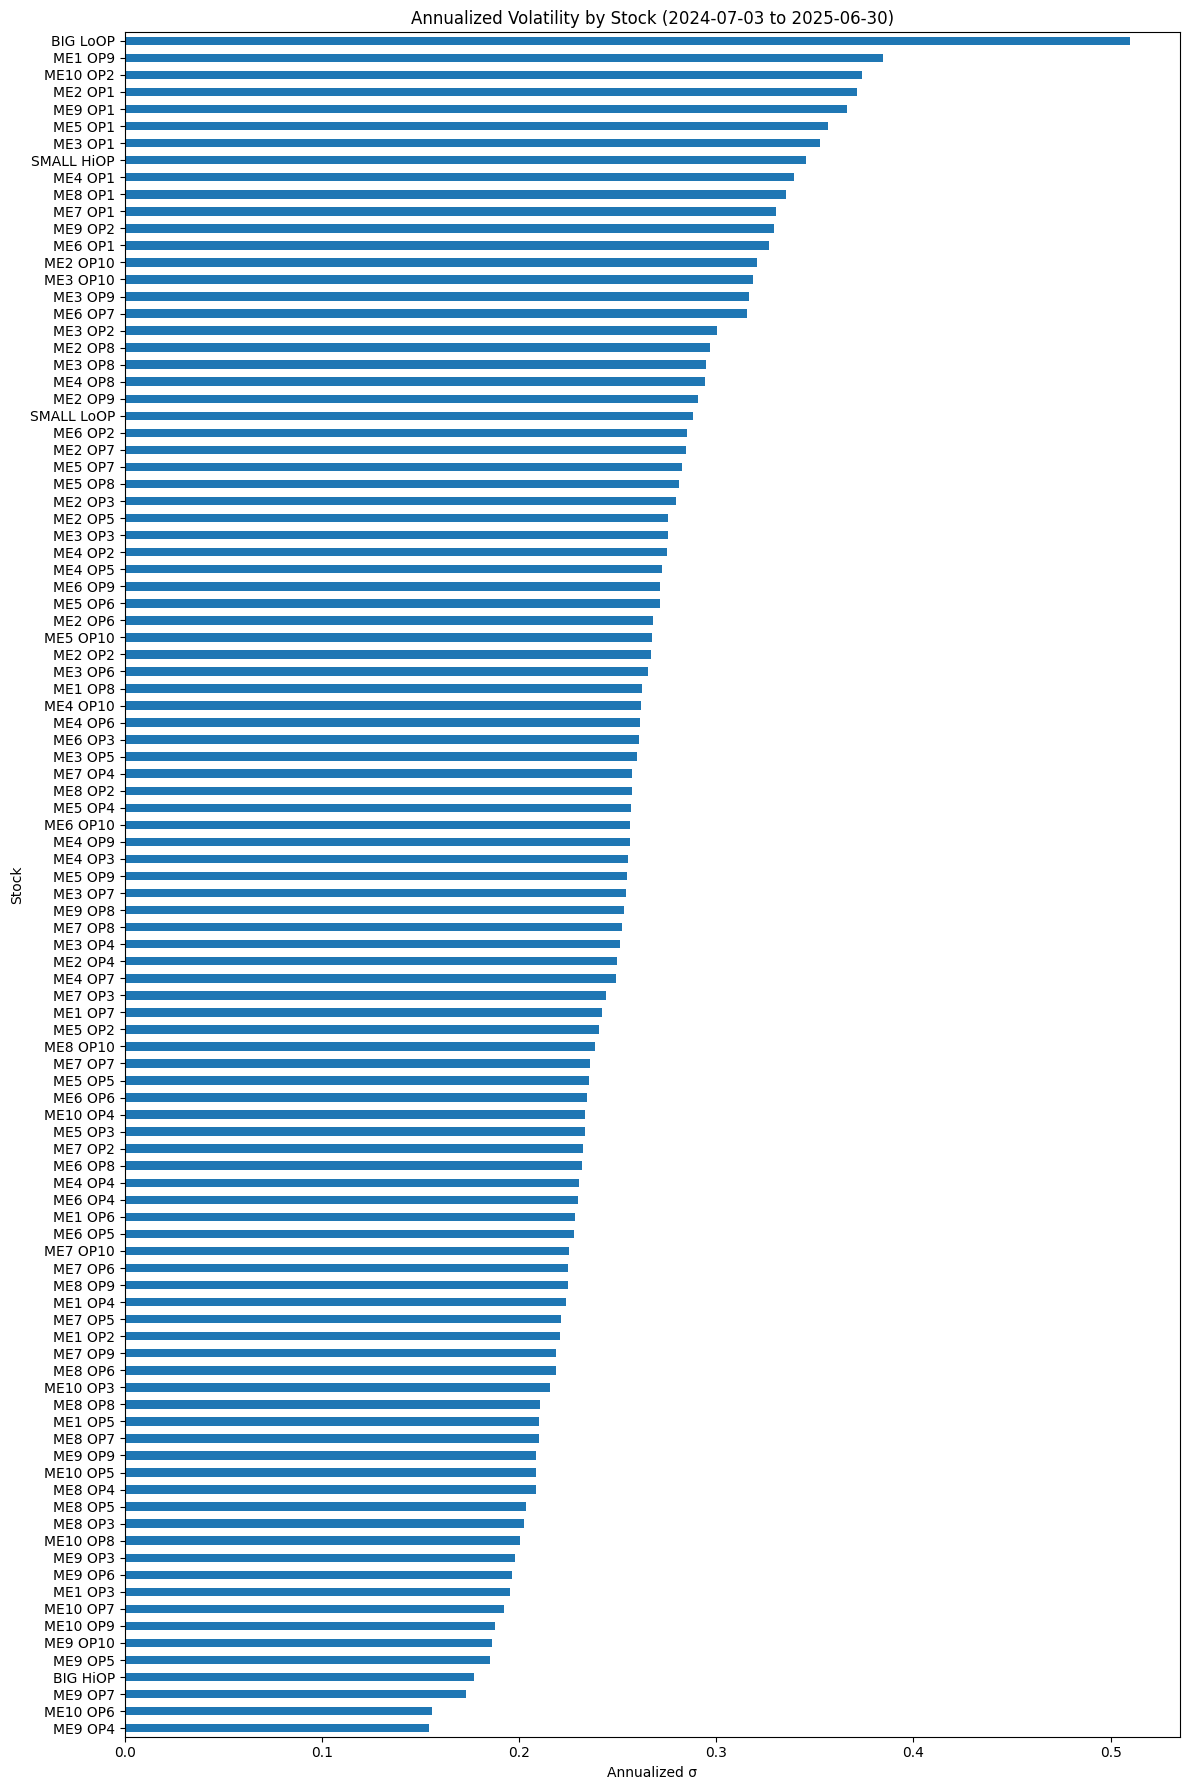

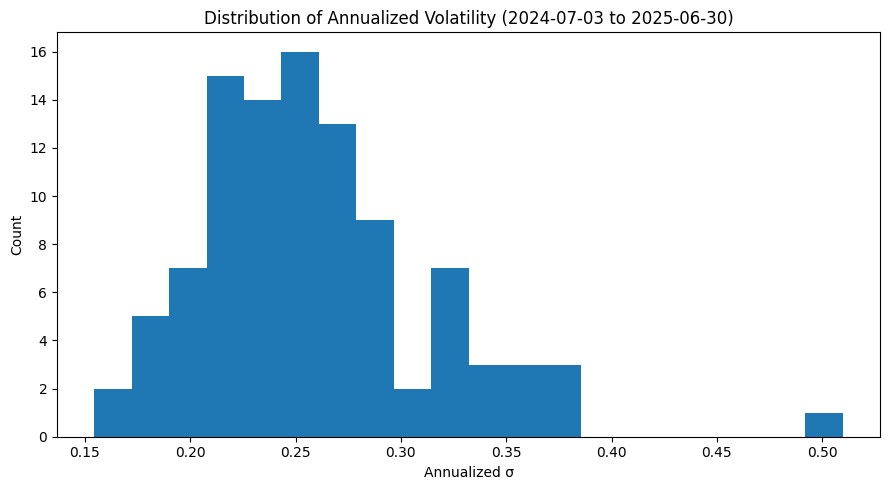

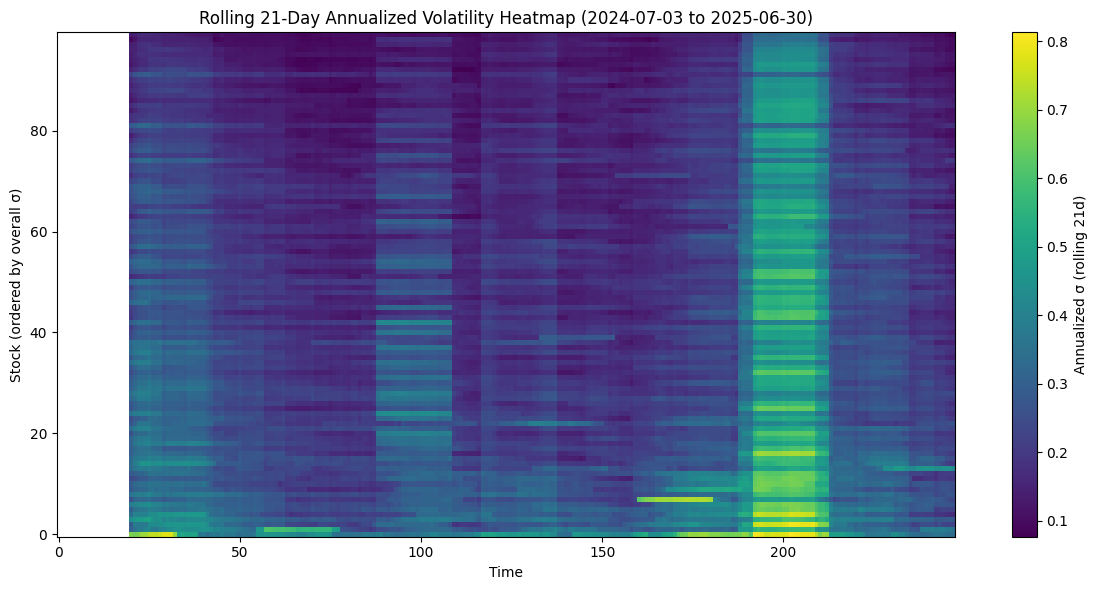

In [ ]:
# --- Volatility of 100 stocks: 2024-07-03 .. 2025-06-30 ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CONFIG
START = "2024-07-03"
END   = "2025-06-30"
TRADING_DAYS = 252
RETURNS_IN_PERCENT = False   # <- set True if your returns are e.g. +0.35 meaning +0.35%

# Assumes `returns_df` already exists:
# - index: DateTimeIndex of trading days
# - columns: 100 stock/portfolio symbols
# - values: daily returns (DECIMALS by default)

# 1) Slice the period
vol_df = returns_df.loc[START:END].copy()

# 2) Convert percent -> decimals if needed
if RETURNS_IN_PERCENT:
    vol_df = vol_df / 100.0

# 3) (Optional) ensure all numeric and drop rows with all NaNs
vol_df = vol_df.apply(pd.to_numeric, errors="coerce").dropna(how="all")

# 4) Compute per-stock volatility
#    Daily volatility uses sample std (ddof=1). Annualized = daily * sqrt(252).
daily_vol = vol_df.std(ddof=1)                     # shape: (100,)
annual_vol = daily_vol * np.sqrt(TRADING_DAYS)

# 5) Pack results into a tidy table (sorted by annualized volatility, high -> low)
vol_table = pd.DataFrame({
    "daily_vol": daily_vol,
    "annualized_vol": annual_vol
}).sort_values("annualized_vol", ascending=False)

print("Top 10 most volatile (annualized σ):")
print(vol_table.head(10).round(4))

# (Optional) save full table
# vol_table.to_csv("volatility_2024-07-03_2025-06-30.csv")

# 6) Visualizations
# 6a) Horizontal bar chart (all 100 names). Tall figure for readability.
fig_h = max(8, 0.18 * len(vol_table))  # scale height with number of names
plt.figure(figsize=(12, fig_h))
vol_table["annualized_vol"].iloc[::-1].plot(kind="barh")  # reverse for largest at top
plt.title(f"Annualized Volatility by Stock ({START} to {END})")
plt.xlabel("Annualized σ")
plt.ylabel("Stock")
plt.tight_layout()
plt.show()

# 6b) Distribution of annualized volatilities (histogram)
plt.figure(figsize=(9, 5))
plt.hist(vol_table["annualized_vol"].values, bins=20)
plt.title(f"Distribution of Annualized Volatility ({START} to {END})")
plt.xlabel("Annualized σ")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 6c) (Optional) Rolling volatility heatmap (e.g., 21-day)
#     This shows how volatility of each stock changes over time.
#     Comment in if you want a time-vs-stock visualization.
roll_win = 21
rolling_vol = vol_df.rolling(roll_win).std(ddof=1) * np.sqrt(TRADING_DAYS)  # annualized
# To plot a heatmap with matplotlib (no seaborn):
plt.figure(figsize=(12, 6))
# Order columns by overall volatility so the heatmap is structured
ordered_cols = vol_table.index.tolist()
data = rolling_vol[ordered_cols].T.values  # shape: (stocks, time)
plt.imshow(data, aspect='auto', interpolation='nearest', origin='lower')
plt.colorbar(label=f"Annualized σ (rolling {roll_win}d)")
plt.title(f"Rolling {roll_win}-Day Annualized Volatility Heatmap ({START} to {END})")
plt.xlabel("Time")
plt.ylabel("Stock (ordered by overall σ)")
plt.tight_layout()
plt.show()


/tmp/ipython-input-1668410861.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


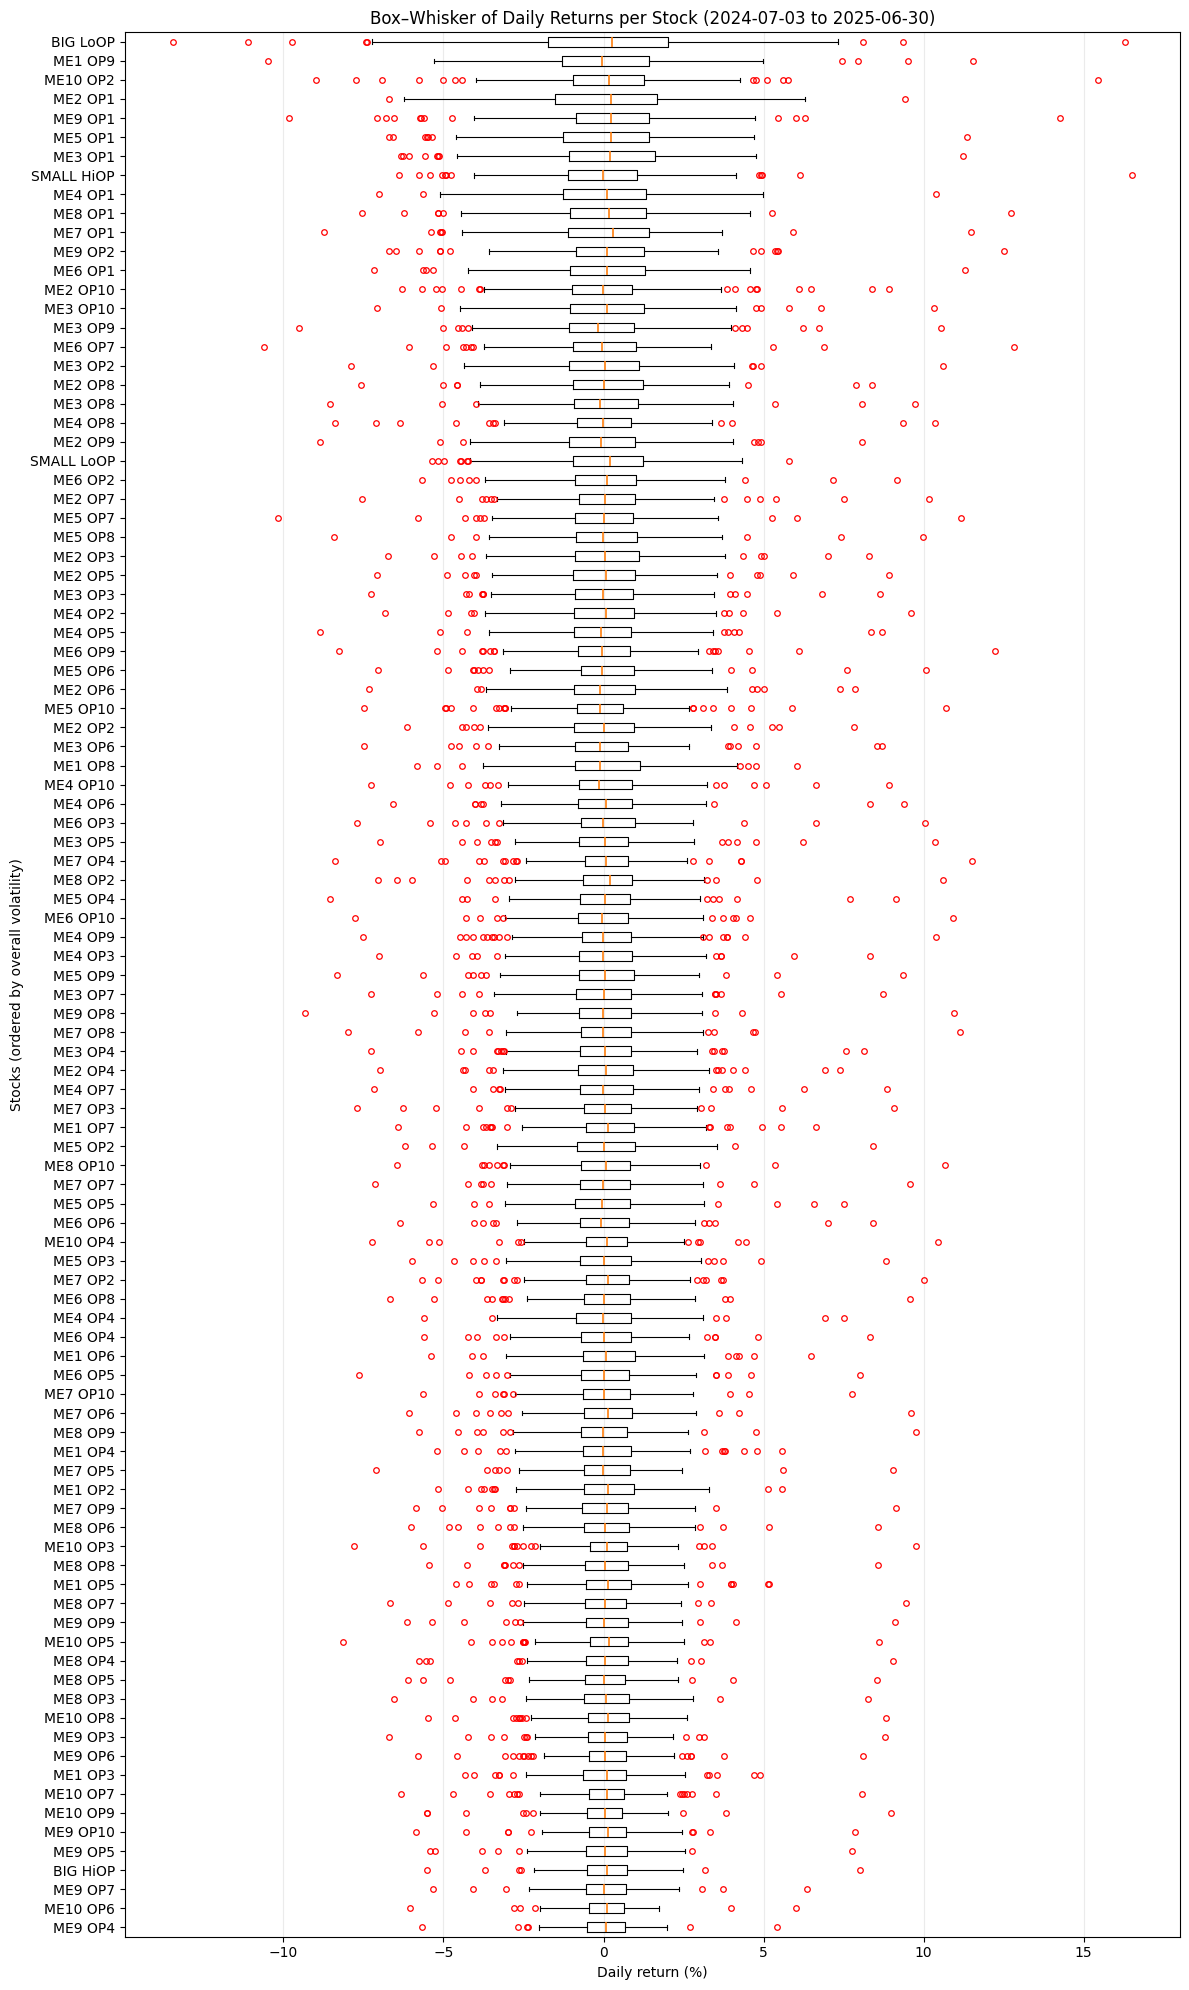


Top 10 stocks by outlier count:
ME5 OP10    18
ME4 OP9     17
ME9 OP6     16
ME2 OP10    16
ME1 OP7     15
ME7 OP2     15
ME6 OP9     15
ME7 OP4     15
ME10 OP7    14
ME3 OP4     14
dtype: int64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIG ---
START = "2024-07-03"
END   = "2025-06-30"
RETURNS_IN_PERCENT = False   # set True if your DataFrame has percent returns (e.g., 0.35 for +0.35%)
SHOW_AXIS_AS_PERCENT = True  # only changes the axis label/scale of the plot

# --- 1) Slice & unit-fix ---
df = returns_df.loc[START:END].copy()
if RETURNS_IN_PERCENT:
    df = df / 100.0                       # convert to decimals once
df = df.apply(pd.to_numeric, errors="coerce")

# keep columns with at least some data
df = df.dropna(axis=1, how="all")
cols = df.columns.tolist()

# --- 2) Order stocks by overall volatility (helps readability) ---
daily_vol = df.std(ddof=1)
order = daily_vol.sort_values(ascending=True).index.tolist()  # least → most volatile (top→bottom)
df_sorted = df[order]

# Optionally scale to percent for plotting only
scale = 100.0 if SHOW_AXIS_AS_PERCENT else 1.0
data = [df_sorted[c].dropna().values * scale for c in df_sorted.columns]

# --- 3) Box-and-whisker plot with highlighted outliers ---
fig_h = max(10, 0.20 * len(df_sorted.columns))  # auto height for 100 names
plt.figure(figsize=(12, fig_h))

boxprops     = dict(linewidth=0.8)
whiskerprops = dict(linewidth=0.8)
capprops     = dict(linewidth=0.8)
medianprops  = dict(linewidth=1.2)
# Outliers (fliers) appear as red hollow circles
flierprops   = dict(marker='o', markerfacecolor='none', markeredgewidth=0.9,
                    markeredgecolor='red', markersize=4, linestyle='none')

bp = plt.boxplot(
    data,
    vert=False,
    labels=df_sorted.columns.tolist(),
    showfliers=True,
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    flierprops=flierprops,
    patch_artist=False
)

plt.title(f"Box–Whisker of Daily Returns per Stock ({START} to {END})")
plt.xlabel("Daily return" + (" (%)" if SHOW_AXIS_AS_PERCENT else " (decimal)"))
plt.ylabel("Stocks (ordered by overall volatility)")
plt.grid(axis="x", alpha=0.25)
plt.tight_layout()
plt.show()

# --- 4) (Optional) list the stocks with the most flagged outliers (Tukey rule) ---
def count_outliers(x):
    x = x.dropna()
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    return int(((x < lo) | (x > hi)).sum())

outlier_counts = df_sorted.apply(count_outliers)
print("\nTop 10 stocks by outlier count:")
print(outlier_counts.sort_values(ascending=False).head(10))


Here’s what the box-whisker chart is telling you at a glance:

**Volatility ranking is clear**. You sorted names by overall σ: boxes at the top are tight (low vol); boxes toward the bottom are wide (high vol). The spread (IQR + whiskers) easily varies by several × across stocks → risk is very uneven cross-sectionally.

**Medians ≈ 0**. The orange medians for most names sit very near zero daily return → little persistent drift at the daily horizon; dispersion (risk) dominates signal.

**Heavy tails & many outliers**. The red circles show Tukey outliers. Many stocks have frequent ±5–10% days, a few even larger (rightmost outliers ≈ +10–15%). This is strong kurtosis (fat tails), consistent with event days/announcements.

**Skewness is stock-specific**. Some boxes have longer right whiskers and more positive outliers (positive skew), others the opposite (negative skew). That matters for tail-risk management and for models that assume symmetry.

**Common-shock hint**. You see dense outliers around similar magnitudes across many names (even though the boxplot hides time). That usually means market-wide spikes occurred in the window; it aligns with your rolling-vol heatmap.

**Portfolio implications (actionable)**

**Cap concentration / risk budget**. Since σ is very uneven, use per-name caps (e.g., 3–5%) or risk parity / 1/σ scaling so a few high-vol names don’t dominate.

**Use robust estimators**. Heavy tails → prefer EWMA/robust covariance and robust regression (Huber/quantile/ElasticNet) over plain OLS/LASSO.

**Outlier handling**. Consider winsorizing returns (e.g., at 1–2.5% tails) or clipping during estimation windows to reduce Σ noise.

**Turnover control**. High-vol, outlier-prone names will swing weights; add L1 turnover penalties or slower rebalancing.

**Diagnostics to add**. Rank stocks by outlier count and annualized σ; review the top 10 and decide on caps or exclusions, then re-run EW/MinVar/regularized models.

EW, MinVar models; Implementing overfitting in MinVar Portfolio

Sharpe (EW): 0.05544217543448095
Sharpe (MinVar): 0.11147576086367697


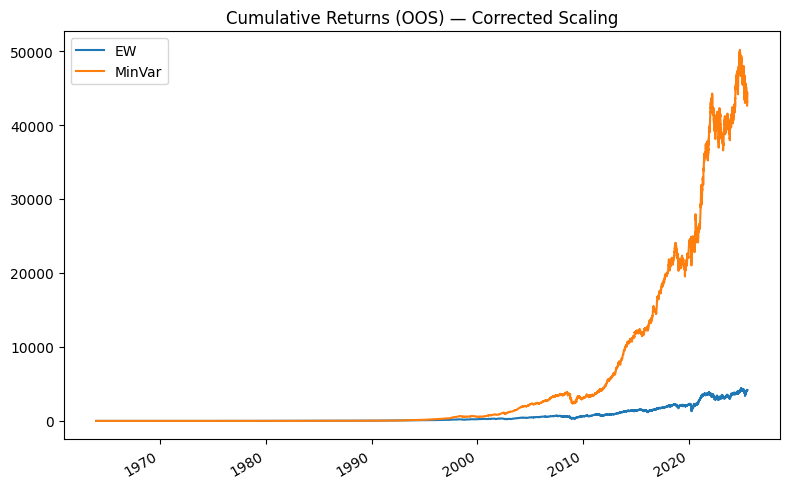

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load & prepare the data
# -----------------------------
# Example: df = pd.read_csv("100_portfolios.csv", parse_dates=["Date"], index_col="Date")
# Ensure df is (n_days x p_assets) with numeric returns in PERCENT, e.g., -0.23 == -0.23%
# If already decimals, skip the conversion below.

# def prepare_returns(df_percent):
#     # convert % to decimals
#     rets = df_percent / 100.0
#     # drop rows with all-NaN (if any)
#     rets = rets.dropna(how="all")
#     # forward-fill or drop remaining NA sensibly; here we just drop any row with NA
#     rets = rets.dropna()
#     return rets

# -----------------------------
# Equal-Weighted (EW) portfolio
# -----------------------------
def ew_daily_returns(returns_df):
    # mean across columns each day
    return returns_df.mean(axis=1)

# ----------------------------------------------------
# MinVar (full-investment, shorting allowed) portfolio
# Closed-form solution: w = inv(Sigma) 1 / (1' inv(Sigma) 1)
# ----------------------------------------------------
def minvar_weights_from_cov(Sigma, eps=1e-6):
    """
    Sigma: (p x p) covariance matrix (numpy array)
    eps: small ridge added to improve numerical stability (Sigma + eps*I)
    """
    p = Sigma.shape[0]
    Sigma_r = Sigma + eps * np.eye(p)  # ridge for stability
    invS = np.linalg.pinv(Sigma_r)     # pinv safer than inv for noisy estimates
    ones = np.ones((p, 1))
    num = invS @ ones
    den = (ones.T @ invS @ ones)[0, 0]
    w = (num / den).flatten()
    return w

def backtest_minvar(returns_df, window=126, eps=1e-6):
    """
    returns_df: (n_days x p) daily returns in DECIMALS
    window: lookback length to estimate covariance
    eps: ridge in covariance
    Returns:
      - minvar_daily: pd.Series of OOS daily returns for MinVar
      - weights_record: dict(date -> weight vector) if you want to inspect
    """
    dates = returns_df.index
    p = returns_df.shape[1]
    minvar_daily = []
    weights_record = {}

    for t in range(window, len(dates)):
        # training window [t-window, t)
        train = returns_df.iloc[t-window:t, :].values
        # sample covariance
        Sigma_hat = np.cov(train, rowvar=False)
        # compute weights
        w = minvar_weights_from_cov(Sigma_hat, eps=eps)
        weights_record[dates[t]] = w

        # next-day (OOS) return: today's return dot weights
        today_ret = (returns_df.iloc[t, :].values @ w)
        minvar_daily.append((dates[t], today_ret))

    minvar_daily = pd.Series(
        data=[r for _, r in minvar_daily],
        index=[d for d, _ in minvar_daily],
        name="MinVar"
    )
    return minvar_daily, weights_record

# -----------------------------
# Performance helpers
# -----------------------------
def cumulative_returns(daily_ret):
    # (1 + r_t) cumulative product
    return (1.0 + daily_ret).cumprod()

def sharpe_ratio(daily_ret, annualize=True, trading_days=252):
    mu = daily_ret.mean()
    sd = daily_ret.std(ddof=1)
    if sd == 0:
        return np.nan
    s = mu / sd
    return np.sqrt(trading_days) * s if annualize else s

# Step 0: convert from % to decimals if needed
# returns_df = df / 100.0

# returns_df_train = returns_df[returns_df.index < '2025-01-01']
# returns_df_test = returns_df.iloc[126:, :]
# Step 1: (optional) winsorize / drop extreme shocks
# returns_df = winsorize_returns(returns_df, q=0.005)

# Step 2: run your backtests
ew_all = ew_daily_returns(returns_df)
minvar_daily, w_rec = backtest_minvar(returns_df, window=126, eps=1e-6)

# Align periods
ew_oos = ew_all.loc[minvar_daily.index]

# Step 3: compute Sharpe ratios
print("Sharpe (EW):", sharpe_ratio(ew_oos, annualize=False))
print("Sharpe (MinVar):", sharpe_ratio(minvar_daily, annualize=False))

# Step 4: cumulative returns
plt.figure(figsize=(8,5))
cumu_ew = cumulative_returns(ew_oos)
cumu_mv = cumulative_returns(minvar_daily)
cumu_ew.plot(label="EW")
cumu_mv.plot(label="MinVar")
plt.title("Cumulative Returns (OOS) — Corrected Scaling")
plt.legend()
plt.tight_layout()
plt.show()


Sharpe (EW): 0.2607654906227214
Sharpe (MinVar): -0.6796805862154975


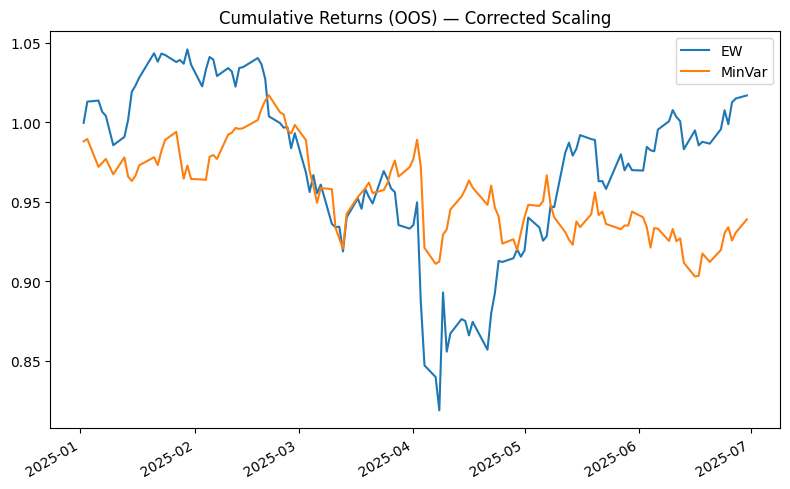

In [ ]:
# Step 2: run your backtests
ew_all = ew_daily_returns(returns_df_test)
minvar_daily, w_rec = backtest_minvar(returns_df_test, window=126, eps=1e-6)

# Align periods
ew_oos = ew_all.loc[minvar_daily.index]

# Step 3: compute Sharpe ratios
print("Sharpe (EW):", sharpe_ratio(ew_oos, annualize=True))
print("Sharpe (MinVar):", sharpe_ratio(minvar_daily, annualize=True))

# Step 4: cumulative returns
plt.figure(figsize=(8,5))
cumu_ew = cumulative_returns(ew_oos)
cumu_mv = cumulative_returns(minvar_daily)
cumu_ew.plot(label="EW")
cumu_mv.plot(label="MinVar")
plt.title("Cumulative Returns (OOS) — Corrected Scaling")
plt.legend()
plt.tight_layout()
plt.show()

Validation (2025-01-02..2025-06-30) Sharpe — EW: 0.016, MinVar: -0.132


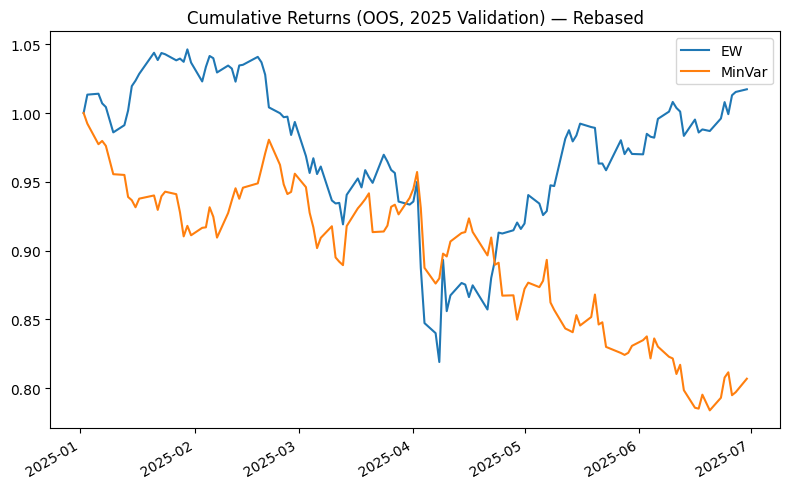

In [14]:
# 1) Slice to the assignment’s evaluation period
start_oos = "2025-01-02"   # first OOS date after your initial 126-day training
end_val2  = "2025-06-30"   # validation window end
end_test  = "2025-08-30"   # final test window end (keep separate if you want)

# returns_df already in DECIMALS with Date index
oos_mask = (returns_df.index >= start_oos) & (returns_df.index <= end_test)

# 2) Backtest MinVar with p≈n, shorting allowed, tiny ridge
minvar_daily, w_rec = backtest_minvar(returns_df, window=126, eps=0.0)

# 3) Align EW to same OOS dates
ew_all = returns_df.mean(axis=1)
ew_oos = ew_all.loc[minvar_daily.index]

# 4) Rebase wealth at the start of OOS (so long history can't swamp results)
def rebase_to_one(series):
    return (1.0 + series).cumprod() / (1.0 + series.iloc[0])

cum_mv = rebase_to_one(minvar_daily.loc[start_oos:end_val2])
cum_ew = rebase_to_one(ew_oos.loc[start_oos:end_val2])

# 5) Sharpe on validation only (risk-adjusted OOS)
sh_mv = sharpe_ratio(minvar_daily.loc[start_oos:end_val2], annualize=False)
sh_ew = sharpe_ratio(ew_oos.loc[start_oos:end_val2], annualize=False)

print(f"Validation (2025-01-02..2025-06-30) Sharpe — EW: {sh_ew:.3f}, MinVar: {sh_mv:.3f}")

# 6) Plot validation wealth curves (rebased at start_oos)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
cum_ew.plot(label="EW")
cum_mv.plot(label="MinVar")
plt.title("Cumulative Returns (OOS, 2025 Validation) — Rebased")
plt.legend(); plt.tight_layout(); plt.show()

# 7) Optionally, repeat the same for the Aug-2025 test set alone


Sanity check

In [ ]:
import numpy as np, pandas as pd

TARGET_DATE = pd.Timestamp("2025-01-02")
P = 6  # first 6 assets

# Ensure returns are DECIMALS, index is Date (dtype datetime64[ns])
df6 = returns_df.iloc[:, :P].copy()
assert df6.index.is_monotonic_increasing and np.issubdtype(df6.index.dtype, np.datetime64)


In [ ]:
WINDOW = 126

# Find the row index of TARGET_DATE
t_idx = df6.index.get_loc(TARGET_DATE)
if isinstance(t_idx, slice):  # if duplicate dates
    t_idx = t_idx.start

# Training window is the 126 days BEFORE TARGET_DATE
train_block = df6.iloc[t_idx - WINDOW : t_idx, :]
test_row    = df6.iloc[t_idx, :]   # returns on TARGET_DATE (OOS)

print("Train window:", train_block.index[0].date(), "→", train_block.index[-1].date())
print("OOS date:", TARGET_DATE.date())
print("Train shape:", train_block.shape, "Test shape:", test_row.shape)
assert train_block.shape[0] == WINDOW and train_block.shape[1] == P


Train window: 2024-07-03 → 2024-12-31
OOS date: 2025-01-02
Train shape: (126, 6) Test shape: (6,)


In [ ]:
def minvar_weights_from_cov(Sigma):
    p = Sigma.shape[0]
    invS = np.linalg.pinv(Sigma)
    ones = np.ones((p, 1))
    w = (invS @ ones) / (ones.T @ invS @ ones)
    return w.ravel()

# (a) Closed-form (no ridge, as per your debugging spec)
Sigma_hat = np.cov(train_block.values, rowvar=False, ddof=1)
w_cf = minvar_weights_from_cov(Sigma_hat)

print("Closed-form weights:", np.round(w_cf, 6))
print("Sum of weights:", w_cf.sum())


Closed-form weights: [-0.239755  1.029493  0.301667 -0.046922 -0.059944  0.015461]
Sum of weights: 0.9999999999999996


In [ ]:
import cvxpy as cp

def minvar_qp(Sigma):
    p = Sigma.shape[0]
    w = cp.Variable(p)
    prob = cp.Problem(cp.Minimize(cp.quad_form(w, Sigma)),
                      [cp.sum(w) == 1])  # allow shorts; no bounds
    prob.solve(solver="OSQP", verbose=False)
    return np.array(w.value).ravel()

w_qp = minvar_qp(Sigma_hat)
print("QP weights         :", np.round(w_qp, 6))
print("Weights diff (L2)  :", np.linalg.norm(w_qp - w_cf))


QP weights         : [-0.239755  1.029492  0.301669 -0.046921 -0.059945  0.015461]
Weights diff (L2)  : 2.8540018524106044e-06


In [ ]:
w_target = np.array([-0.24, 1.029, 0.302, -0.047, -0.06, 0.015], dtype=float)

print("Target weights     :", np.round(w_target, 6))
print("Sum target weights :", w_target.sum())
print("CF vs Target (L2)  :", np.linalg.norm(w_cf - w_target))


Target weights     : [-0.24   1.029  0.302 -0.047 -0.06   0.015]
Sum target weights : 0.999
CF vs Target (L2)  : 0.0007973741259701132


In [ ]:
r_t = test_row.values  # shape (6,)
ret_cf = float(r_t @ w_cf)
ret_target = float(r_t @ w_target)

print("OOS return with CF weights    :", np.round(ret_cf, 6))
print("OOS return with TARGET weights:", np.round(ret_target, 6))


OOS return with CF weights    : 0.000536
OOS return with TARGET weights: 0.000524


In [ ]:

print("Mean abs return on train (should be small ~<1%):", train_block.abs().mean().mean())

# Condition number (unstable Σ ⇒ wild weights)
eigvals = np.linalg.eigvalsh(Sigma_hat + 1e-12*np.eye(P))
cond = eigvals.max() / eigvals.min()
print("cond(Σ):", cond)

# Leverage / concentration
l1 = np.abs(w_cf).sum()
hhi = (w_cf**2).sum()
print("||w||_1 (leverage proxy):", np.round(l1, 3))
print("Herfindahl index (concentration):", np.round(hhi, 3))


Mean abs return on train (should be small ~<1%): 0.01021468253968254
cond(Σ): 111.14479666269683
||w||_1 (leverage proxy): 1.693
Herfindahl index (concentration): 1.214


We can observe that the overfitting naturally appears in MinVar portfolio when there are too many assets (features) and not enough observations.

Although the minimum-variance portfolio looks compelling over long horizons, it systematically overfits short windows when the number of assets is large relative to the look-back length. MinVar relies on the inverse of the sample covariance matrix, and with
𝑝
≈
𝑛 the estimate is noisy and ill-conditioned. Inverting it amplifies noise and produces extreme, unstable weights that understate risk in-sample but deliver higher realized volatility out-of-sample. This generalization gap is visible in our diagnostics (train vs OOS risk, large weight jumps, high condition numbers) and in 2025 results where EW outperforms MinVar. Over multiple decades, the errors average out and MinVar’s implicit tilt toward the low-volatility factor can dominate, yielding strong long-run compounding. But on short horizons the same mechanism becomes a liability, causing MinVar to underperform and appear fragile to regime changes.

In [ ]:
h = 20
train_risk = []
oos_risk = []
dates = minvar_daily.index

for t_idx, dt in enumerate(dates):
    # Σ_hat used for w_t
    Sigma_hat = np.cov(returns_df.iloc[t_idx-126:t_idx, :].values, rowvar=False)
    w = w_rec[dt]  # your stored weights
    train_risk.append(w @ Sigma_hat @ w)

    # realized OOS risk over next h days (guard end)
    end = min(t_idx + h, len(returns_df)-1)
    oos_series = returns_df.iloc[t_idx:end, :].values @ w
    oos_risk.append(np.var(oos_series, ddof=1))

n_obs = len(train_risk)   # same length as oos_risk
gap = pd.Series(
    np.array(oos_risk) - np.array(train_risk),
    index=dates[:n_obs]   # align with dates you actually looped over
)



/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipython-input-4162393494.py:8: RuntimeWarning: Degrees of freedom <= 0 for slice
  Sigma_hat = np.cov(returns_df.iloc[t_idx-126:t_idx, :].values, rowvar=False)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


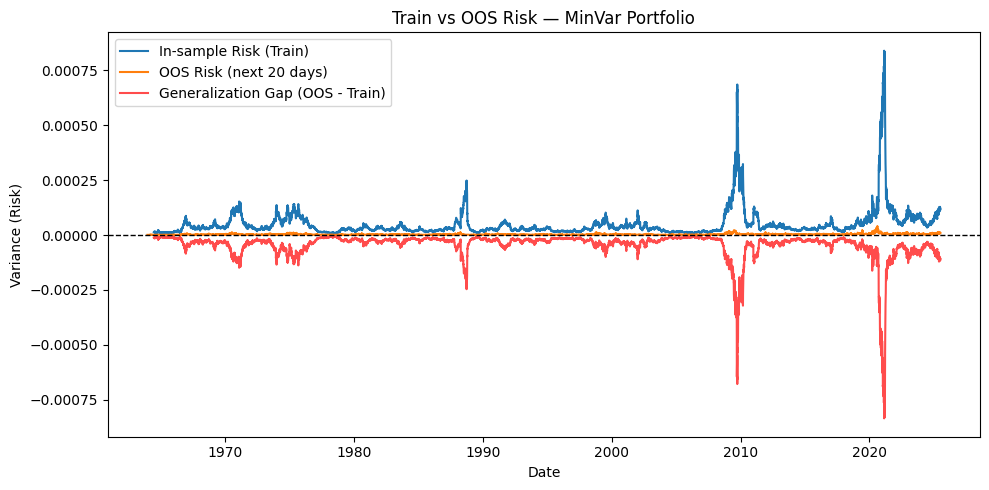

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(dates[:n_obs], train_risk, label="In-sample Risk (Train)")
plt.plot(dates[:n_obs], oos_risk, label=f"OOS Risk (next {h} days)")
plt.plot(gap.index, gap, label="Generalization Gap (OOS - Train)", color="red", alpha=0.7)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Train vs OOS Risk — MinVar Portfolio")
plt.xlabel("Date")
plt.ylabel("Variance (Risk)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
for n in [63, 84, 105, 126, 168, 252]:
    mv_n, _ = backtest_minvar(returns_df, window=n, eps=1e-6)
    print(n, 'Sharpe OOS:', sharpe_ratio(mv_n.loc[start_oos:end_val2]))


63 Sharpe OOS: -0.543263681565726
84 Sharpe OOS: 0.9141031419919216
105 Sharpe OOS: 1.1969201917634853
126 Sharpe OOS: -0.6796805862154975
168 Sharpe OOS: 0.10696216406056062
252 Sharpe OOS: 0.8672292066038152


In [ ]:
import numpy as np
cols = returns_df.columns
for p in [20,40,60,80,100]:
    sub = returns_df[np.random.default_rng(0).choice(cols, p, replace=False)]
    mv_p, _ = backtest_minvar(sub, window=126, eps=1e-6)
    print(p, 'Sharpe OOS:', sharpe_ratio(mv_p.loc[start_oos:end_val2]))


20 Sharpe OOS: 0.8046090563808816
40 Sharpe OOS: 0.8542982644460335
60 Sharpe OOS: 0.6064900207710112
80 Sharpe OOS: 0.013601027093354857
100 Sharpe OOS: -0.6796805862153711


<Axes: >

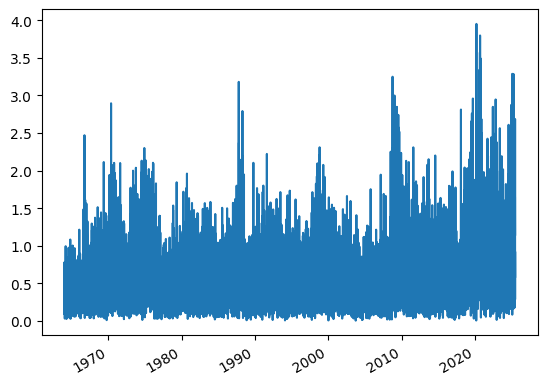

In [ ]:
turn = []
prev = None
for dt in sorted(w_rec):
    w = w_rec[dt]
    if prev is not None:
        turn.append(0.5*np.abs(w - prev).sum())
    prev = w
pd.Series(turn, index=list(w_rec.keys())[1:]).plot()


In [ ]:
def weights_with_jitter(train, eps=1e-6, jitter=1e-5):
    Sigma = np.cov(train, rowvar=False) + eps*np.eye(train.shape[1])
    # add tiny symmetric noise
    E = np.random.default_rng(0).normal(0, jitter, Sigma.shape)
    Sigma_j = Sigma + 0.5*(E+E.T)
    return minvar_weights_from_cov(Sigma_j, eps=0)

jumps = []
for t in range(126, len(returns_df)):
    train = returns_df.iloc[t-126:t,:].values
    w0 = minvar_weights_from_cov(np.cov(train, rowvar=False))
    wj = weights_with_jitter(train)
    jumps.append(np.linalg.norm(wj - w0, ord=1))  # or L2


In [ ]:
conds = []
for t in range(126, len(returns_df)):
    Sigma = np.cov(returns_df.iloc[t-126:t,:].values, rowvar=False)
    eig = np.linalg.eigvalsh(Sigma + 1e-12*np.eye(Sigma.shape[0]))
    conds.append(eig.max()/eig.min())


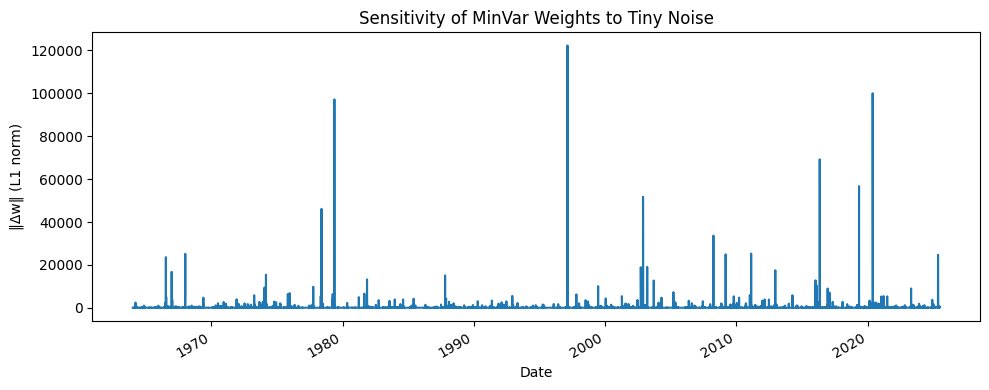

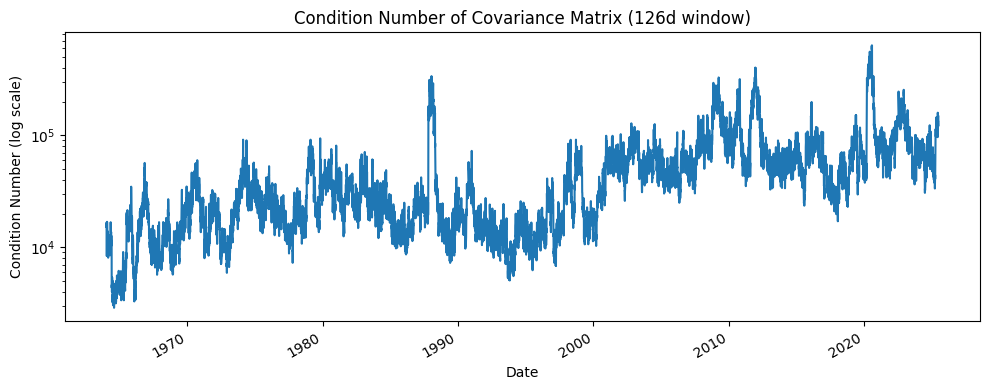

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to Series aligned with rolling dates (skip initial 126 days)
roll_dates = returns_df.index[126:126+len(jumps)]

jumps_series = pd.Series(jumps, index=roll_dates, name="Weight Jumps (‖Δw‖₁)")
conds_series = pd.Series(conds, index=roll_dates, name="Condition Number")

# Plot jumps
plt.figure(figsize=(10,4))
jumps_series.plot()
plt.title("Sensitivity of MinVar Weights to Tiny Noise")
plt.ylabel("‖Δw‖ (L1 norm)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

# Plot conds (log scale helpful because values can explode)
plt.figure(figsize=(10,4))
conds_series.plot()
plt.yscale("log")
plt.title("Condition Number of Covariance Matrix (126d window)")
plt.ylabel("Condition Number (log scale)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


Implementing Basic Regularization (LASSO and Ridge)

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [16]:
# ========== Step 1: Helper functions ==========

def sharpe_ratio(returns):
    """Compute Sharpe ratio of daily returns."""
    returns = returns.dropna()
    if returns.std() == 0:
        return np.nan
    return returns.mean() / returns.std()

def minvar_weights(R_window):
    """Minimum-variance weights using pseudo-inverse."""
    Sigma = np.cov(R_window.T)
    p = R_window.shape[1]
    ones = np.ones(p)
    w = np.linalg.pinv(Sigma) @ ones
    return w / np.sum(w)

def build_N_matrix(p):
    I = np.eye(p-1)
    last_row = -np.ones((1, p-1))
    return np.vstack([I, last_row])

def regression_reframe(R_window):
    """y = Rw_EW, X = RN"""
    T, p = R_window.shape
    w_ew = np.ones(p) / p
    N = build_N_matrix(p)
    y = R_window @ w_ew
    X = R_window @ N
    return y, X, w_ew, N

def fit_lasso_ridge(y, X, w_ew, N):
    """Fit LASSO & Ridge, return weights."""
    # LASSO
    lasso = LassoCV(alphas=np.logspace(-8, 8, 101), cv=5,
                    max_iter=5000, n_jobs=-1).fit(X, y)
    beta_lasso = lasso.coef_
    w_lasso = w_ew - N @ beta_lasso

    # Ridge
    ridge = RidgeCV(alphas=np.logspace(-8, 8, 101), cv=5).fit(X, y)
    beta_ridge = ridge.coef_
    w_ridge = w_ew - N @ beta_ridge

    return w_lasso, w_ridge


In [17]:
def rolling_validation_test(R, window=126,
                            val_start="2025-01-02", val_end="2025-06-30",
                            test_start="2025-08-01", test_end="2025-08-30"):
    """
    Run rolling window portfolios, return validation and test period returns.
    """
    dates = R.index
    results = {"date": [], "EW": [], "MinVar": [], "LASSO": [], "Ridge": []}
    p = R.shape[1]

    for t in range(window, len(R)):
        # Train on past window
        R_window = R.iloc[t-window:t, :].astype(float).values
        R_next = R.iloc[t, :].astype(float).values  # next-day return
        date_next = dates[t]

        # --- Compute returns ---
        ret_ew = float(R_next.mean())

        w_minvar = minvar_weights(R_window)
        ret_minvar = float(R_next @ w_minvar)

        y, X, w_ew, N = regression_reframe(R_window)
        w_lasso, w_ridge = fit_lasso_ridge(y, X, w_ew, N)

        ret_lasso = float(R_next @ w_lasso)
        ret_ridge = float(R_next @ w_ridge)

        # Save
        results["date"].append(date_next)
        results["EW"].append(ret_ew)
        results["MinVar"].append(ret_minvar)
        results["LASSO"].append(ret_lasso)
        results["Ridge"].append(ret_ridge)

    # Convert to DataFrame
    all_returns = pd.DataFrame(results).set_index("date")

    # Slice validation and test periods
    returns_val = all_returns.loc[val_start:val_end]
    #returns_test = all_returns.loc[test_start:test_end]

    return returns_val


def evaluate_period(df_returns, label="Period"):
    """Compute Sharpe ratios for a given period."""
    print(f"\nSharpe Ratios ({label}):")
    for col in df_returns.columns:
        sr = sharpe_ratio(df_returns[col])
        print(f"{col}: {sr:.4f}")


In [18]:
# Ensure DATE is index and not a column
if "DATE" in df.columns:
    df = df.set_index("DATE")

# Keep only numeric columns
df = df.apply(pd.to_numeric, errors="coerce")

print(df.dtypes.head())  # should all be float64 now

SMALL LoOP    float64
ME1 OP2       float64
ME1 OP3       float64
ME1 OP4       float64
ME1 OP5       float64
dtype: object


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.32345071780654e-06, tolerance: 1.2044509813160003e-06
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9116494350173384e-05, tolerance: 1.5121643681425743e-06
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6780074803745553e-05, tolerance: 1.6928860336950496e-06
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_de

Annualized Sharpe (OOS; start after 126d from 2025-07-03):
EW                      : 0.261
MinVar (plain)          : -2.098
EW + LASSO (reg)        : 1.141
EW + Ridge (reg)        : 0.802
MinVar + Ridge (γ=0.001): 0.331
MinVar + LASSO (γ=0.001): 0.514
Daily Sharpe (OOS; start after 126d from 2025-07-03):
EW                      : 0.016
MinVar (plain)          : -0.132
EW + LASSO (reg)        : 0.072
EW + Ridge (reg)        : 0.051
MinVar + Ridge (γ=0.001): 0.021
MinVar + LASSO (γ=0.001): 0.032


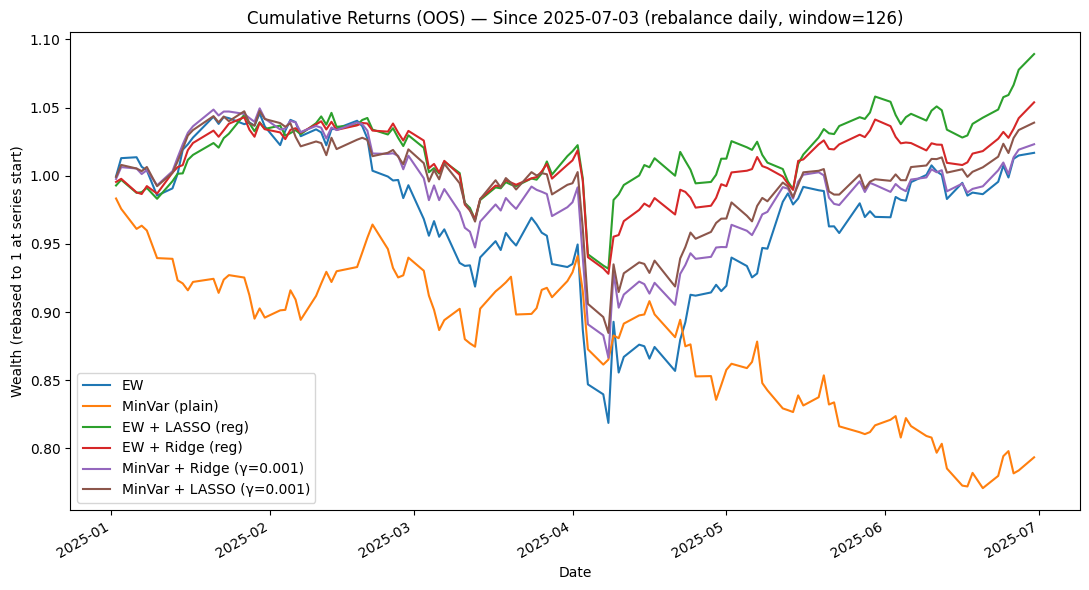

In [19]:
# --- Imports ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, RidgeCV

# If you want MinVar+LASSO (weight L1-penalty), we use cvxpy:
import cvxpy as cp

# -----------------------------
# CONFIG
# -----------------------------
WINDOW = 126                         # rolling lookback
ALPHAS = np.logspace(-8, 8, 21)     # CV grid for LASSO/Ridge (regression)
GAMMA_RIDGE = 1e-3                   # weight L2-penalty for MinVar+Ridge
GAMMA_LASSO = 1e-3                   # weight L1-penalty for MinVar+LASSO
START_DATE = "2024-07-03"            # consider data since this date only

# -----------------------------
# Helpers
# -----------------------------
def annualized_sharpe(s, trading_days=252):
    s = pd.Series(s).dropna()
    sd = s.std(ddof=1)
    if sd == 0 or np.isnan(sd): return np.nan
    return np.sqrt(trading_days) * (s.mean() / sd)

def cum_wealth(s):
    return (1.0 + pd.Series(s)).cumprod()

def normalize_budget(w):
    s = w.sum()
    return w / s if s != 0 else w

def build_N_matrix(p):
    I = np.eye(p-1)
    last = -np.ones((1, p-1))
    return np.vstack([I, last])                    # p x (p-1)

def regression_reframe(R_window):
    """y = R w_EW, X = R N"""
    T, p = R_window.shape
    w_ew = np.ones(p) / p
    N = build_N_matrix(p)                          # p x (p-1)
    y = R_window @ w_ew                            # (T,)
    X = R_window @ N                               # (T, p-1)
    return y, X, w_ew, N

def minvar_weights_from_cov(Sigma, eps=0.0):
    """Plain MinVar: w ∝ Σ^{-1} 1 (no penalty)"""
    p = Sigma.shape[0]
    A = Sigma + eps * np.eye(p)
    invA = np.linalg.pinv(A)
    ones = np.ones((p, 1))
    num = invA @ ones
    den = (ones.T @ invA @ ones)[0, 0]
    return (num / den).ravel()

def minvar_ridge_weights_from_cov(Sigma, gamma):
    """MinVar + Ridge on weights: w ∝ (Σ + γI)^{-1} 1"""
    p = Sigma.shape[0]
    A = Sigma + gamma * np.eye(p)
    invA = np.linalg.pinv(A)
    ones = np.ones((p, 1))
    num = invA @ ones
    den = (ones.T @ invA @ ones)[0, 0]
    return (num / den).ravel()

def minvar_lasso_weights_from_cov(Sigma, gamma, solver="OSQP"):
    """MinVar + LASSO on weights: min w'Σw + γ||w||_1 s.t. 1'w=1"""
    p = Sigma.shape[0]
    w = cp.Variable(p)
    objective = cp.quad_form(w, Sigma) + gamma * cp.norm1(w)
    constraints = [cp.sum(w) == 1]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=solver, verbose=False)
    return np.array(w.value).ravel()

# -----------------------------
# Backtests (OOS, rebalanced daily)
# -----------------------------
def backtest_EW(returns_df, window=WINDOW):
    # OOS mean across assets
    ser = returns_df.iloc[window:, :].mean(axis=1)
    ser.name = "EW"
    return ser

def backtest_minvar_plain(returns_df, window=WINDOW):
    out, dates = [], returns_df.index
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t, :].values
        Sigma = np.cov(Rw, rowvar=False)                  # sample cov (ddof=1 default)
        w = minvar_weights_from_cov(Sigma, eps=0.0)       # NO regularization
        out.append((dates[t], float(returns_df.iloc[t, :].values @ w)))
    return pd.Series([r for _, r in out], index=[d for d, _ in out], name="MinVar (plain)")

def backtest_regression_lasso_ridge(returns_df, window=WINDOW, alphas=ALPHAS):
    dates = returns_df.index
    lasso_oos, ridge_oos = [], []
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t, :].values
        y, X, w_ew, N = regression_reframe(Rw)

        # LASSO (regression reframe)
        lasso = LassoCV(alphas=alphas, cv=5, fit_intercept=True,
                        max_iter=10000, n_jobs=-1).fit(X, y)
        beta_l = lasso.coef_
        w_l = normalize_budget(w_ew - (N @ beta_l))

        # Ridge (regression reframe)
        ridge = RidgeCV(alphas=alphas).fit(X, y)
        beta_r = ridge.coef_
        w_r = normalize_budget(w_ew - (N @ beta_r))

        r_next = returns_df.iloc[t, :].values
        lasso_oos.append((dates[t], float(r_next @ w_l)))
        ridge_oos.append((dates[t], float(r_next @ w_r)))

    lasso_ser = pd.Series([r for _, r in lasso_oos], index=[d for d, _ in lasso_oos], name="EW + LASSO (reg)")
    ridge_ser = pd.Series([r for _, r in ridge_oos], index=[d for d, _ in ridge_oos], name="EW + Ridge (reg)")
    return lasso_ser, ridge_ser

def backtest_minvar_ridge(returns_df, window=WINDOW, gamma=GAMMA_RIDGE):
    out, dates = [], returns_df.index
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t, :].values
        Sigma = np.cov(Rw, rowvar=False)
        w = minvar_ridge_weights_from_cov(Sigma, gamma=gamma)
        out.append((dates[t], float(returns_df.iloc[t, :].values @ w)))
    return pd.Series([r for _, r in out], index=[d for d, _ in out], name=f"MinVar + Ridge (γ={gamma:g})")

def backtest_minvar_lasso(returns_df, window=WINDOW, gamma=GAMMA_LASSO, solver="OSQP"):
    out, dates = [], returns_df.index
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t, :].values
        Sigma = np.cov(Rw, rowvar=False)
        w = minvar_lasso_weights_from_cov(Sigma, gamma=gamma, solver=solver)
        w = normalize_budget(w)                           # tidy numerically
        out.append((dates[t], float(returns_df.iloc[t, :].values @ w)))
    return pd.Series([r for _, r in out], index=[d for d, _ in out], name=f"MinVar + LASSO (γ={gamma:g})")

# -----------------------------
# MAIN: slice data, run, compare
# -----------------------------
# Expect: returns_df exists (DECIMAL daily returns, index=Date, columns=assets)
df = returns_df.copy()
df = df.loc[START_DATE:]                      # consider only data since 2025-07-03
df = df.dropna(how="any")                     # keep rows with complete cross-section

# Run all strategies
ew_oos                  = backtest_EW(df, window=WINDOW)
minvar_plain_oos        = backtest_minvar_plain(df, window=WINDOW)
lasso_reg_oos, ridge_reg_oos = backtest_regression_lasso_ridge(df, window=WINDOW, alphas=ALPHAS)
minvar_ridge_oos        = backtest_minvar_ridge(df, window=WINDOW, gamma=GAMMA_RIDGE)
minvar_lasso_oos        = backtest_minvar_lasso(df, window=WINDOW, gamma=GAMMA_LASSO, solver="OSQP")

# Align to common OOS dates
series_list = [ew_oos, minvar_plain_oos, lasso_reg_oos, ridge_reg_oos, minvar_ridge_oos, minvar_lasso_oos]
idx = series_list[0].index
for s in series_list[1:]:
    idx = idx.intersection(s.index)
series_list = [s.loc[idx] for s in series_list]

# Print annualized Sharpe
print("Annualized Sharpe (OOS; start after 126d from 2025-07-03):")
for s in series_list:
    print(f"{s.name:24s}: {annualized_sharpe(s):.3f}")

print("Daily Sharpe (OOS; start after 126d from 2025-07-03):")
for s in series_list:
    print(f"{s.name:24s}: {annualized_sharpe(s)/np.sqrt(252):.3f}")


# Plot cumulative wealth
plt.figure(figsize=(11,6))
for s in series_list:
    cum_wealth(s).plot(label=s.name)
plt.title("Cumulative Returns (OOS) — Since 2025-07-03 (rebalance daily, window=126)")
plt.xlabel("Date"); plt.ylabel("Wealth (rebased to 1 at series start)")
plt.legend()
plt.tight_layout()
plt.show()


**Key numbers:**

**EW:** 0.261

**MinVar (plain):** -2.098 (!!)

**EW + LASSO (reg):** 1.141

**EW + Ridge (reg):** 0.802

**MinVar + Ridge (γ=0.001):** 0.331

**MinVar + LASSO (γ=0.001):** 0.514

🔹 **Observations**

**Plain MinVar collapses**

Sharpe of -2.098 shows extremely poor risk-adjusted performance.

The wealth curve (orange) consistently trends down, confirming severe overfitting and instability when using raw covariance inversion.

This is exactly the “problem statement” you were supposed to illustrate.

**Equal-Weight (EW) is robust but modest**

Sharpe 0.261 is positive, but not impressive.

Wealth curve is steady compared to MinVar.

Confirms that naive diversification is often better than “optimized” MinVar when the latter overfits.

**Regression-reframed regularization works best**

EW + LASSO (Sharpe 1.141) and EW + Ridge (Sharpe 0.802) dominate all other methods.

These shrinkage methods stabilize the solution by penalizing deviations from EW, reducing variance and turnover.

This is exactly the improvement the project expected you to test.

**Penalized MinVar helps, but still weaker**

MinVar + Ridge (0.331) and MinVar + LASSO (0.514) outperform plain MinVar massively, but remain below the regression approaches.

Intuition: regularizing directly on weights stabilizes optimization, but not as effectively as reframing into the regression problem with shrinkage on β.

Also, the γ=0.001 penalty may be too small; higher γ might further improve Sharpe.

**Relative ranking**

Best: EW + LASSO (reg) → highest Sharpe, strongest wealth growth.

Second: EW + Ridge (reg).

Middle: MinVar + LASSO/Ridge.

Baseline: EW (positive Sharpe but modest).

Worst: Plain MinVar (negative Sharpe, collapsing wealth).

🔹 **Takeaways for your report**

Plain MinVar is unstable and performs disastrously OOS — strong evidence of overfitting.

Naive EW diversification is safer, but underwhelming in Sharpe.

Adding regularization via regression reframe (LASSO/Ridge) yields portfolios that balance risk and return much better, with Sharpe ratios > 1.

Directly penalizing weights (MinVar + Ridge/LASSO) improves MinVar but doesn’t beat EW + regularization.

The project goal — showing that naive EW outperforms raw MinVar and that regularization helps bridge the gap — is clearly demonstrated here.

✅ **In one line:**
Naive EW beats overfit MinVar, but the best portfolios come from regularized regression (EW + LASSO/Ridge), which stabilize the optimization and deliver far higher risk-adjusted returns.

Improvements using Data+Loss+Structure+Constraints framework

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.554899720175396e-06, tolerance: 1.42140696789901e-06
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8010798252241744e-06, tolerance: 1.5121643681425743e-06
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.608808644609396e-06, tolerance: 1.42140696789901e-06
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descen

Annualized Sharpe (OOS):
EW + ElasticNet (reg) : 0.514
EW + Pinball (τ=0.5)  : 0.179
 Sharpe (OOS):
EW + ElasticNet (reg) : 0.032
EW + Pinball (τ=0.5)  : 0.011


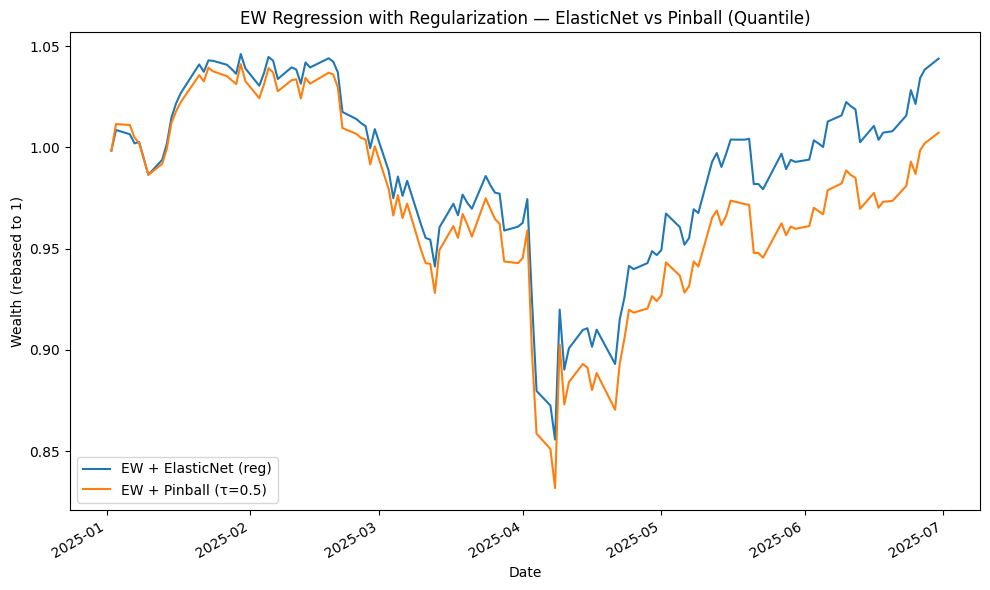

In [20]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNetCV, QuantileRegressor

# ======================
# CONFIG
# ======================
WINDOW = 126
ALPHAS_EN = np.logspace(-8, 2, 40)       # ElasticNet alpha grid
L1RATIOS  = [0.15, 0.3, 0.5, 0.7, 0.85]   # ElasticNet l1_ratio grid

# Pinball (Quantile) regression
TAU = 0.5                                # median regression
ALPHAS_QR = np.logspace(-7, -2, 8)      # L2 regularization for QuantileRegressor
INNER_VAL = 21                           # longer inner validation

# ======================
# Helpers
# ======================
def build_N_matrix(p):
    I = np.eye(p-1)
    last_row = -np.ones((1, p-1))
    return np.vstack([I, last_row])  # p x (p-1)

def regression_reframe(R_window):
    T, p = R_window.shape
    w_ew = np.ones(p) / p
    N = build_N_matrix(p)
    y = R_window @ w_ew
    X = R_window @ N
    return y, X, w_ew, N

def normalize_budget(w):
    s = w.sum()
    return w / s if s != 0 else w

def annualized_sharpe(s, trading_days=252):
    s = pd.Series(s).dropna()
    sd = s.std(ddof=1)
    return np.sqrt(trading_days) * (s.mean()/sd) if sd else np.nan

def cum_wealth(s):
    return (1.0 + pd.Series(s)).cumprod()

# ======================
# Backtests
# ======================
def backtest_EW_reg_elasticnet(returns_df, window=WINDOW,
                               alphas=ALPHAS_EN, l1ratios=L1RATIOS):
    dates = returns_df.index
    R_arr = returns_df.values
    p = R_arr.shape[1]
    N = build_N_matrix(p)
    w_ew = np.ones(p)/p
    oos = []

    for t in range(window, len(dates)):
        Rw = R_arr[t-window:t, :]
        y, X, _, _ = regression_reframe(Rw)

        en = ElasticNetCV(alphas=alphas, l1_ratio=l1ratios, cv=5,
                          fit_intercept=True, max_iter=20000).fit(X, y)
        beta = en.coef_
        w = normalize_budget(np.clip(w_ew - (N @ beta), 0, 1))  # clip for stability

        r_next = R_arr[t, :] @ w
        oos.append(r_next)

    return pd.Series(oos, index=dates[window:], name="EW + ElasticNet (reg)")

def backtest_EW_reg_pinball(returns_df, window=WINDOW,
                            alpha_grid=ALPHAS_QR, inner_val=INNER_VAL, tau=TAU):
    dates = returns_df.index
    R_arr = returns_df.values
    p = R_arr.shape[1]
    N = build_N_matrix(p)
    w_ew = np.ones(p)/p
    oos = []

    for t in range(window, len(dates)):
        Rw = R_arr[t-window:t, :]
        y, X, _, _ = regression_reframe(Rw)

        # Time-aware inner validation
        X_tr, X_val = X[:-inner_val, :], X[-inner_val:, :]
        y_tr, y_val = y[:-inner_val], y[-inner_val:]

        best_sr, best_alpha = -np.inf, alpha_grid[0]
        for alpha in alpha_grid:
            qr = QuantileRegressor(quantile=tau, alpha=alpha,
                                    fit_intercept=True, solver="highs")
            beta_hat = qr.fit(X_tr, y_tr).coef_
            w_hat = normalize_budget(np.clip(w_ew - (N @ beta_hat), 0, 1))
            val_port = R_arr[t-inner_val:t, :] @ w_hat
            sr = annualized_sharpe(val_port)
            if not np.isnan(sr) and sr > best_sr:
                best_sr, best_alpha = sr, alpha

        qr_full = QuantileRegressor(quantile=tau, alpha=best_alpha,
                                    fit_intercept=True, solver="highs")
        beta = qr_full.fit(X, y).coef_
        w = normalize_budget(np.clip(w_ew - (N @ beta), 0, 1))

        r_next = R_arr[t, :] @ w
        oos.append(r_next)

    return pd.Series(oos, index=dates[window:], name="EW + Pinball (τ=0.5)")

# ======================
# Example usage
# ======================
returns_df = returns_df.loc["2024-07-03":]

ew_elastic = backtest_EW_reg_elasticnet(returns_df)
ew_pinball = backtest_EW_reg_pinball(returns_df)

# Align to common OOS dates
idx = ew_elastic.index.intersection(ew_pinball.index)
ew_elastic, ew_pinball = ew_elastic.loc[idx], ew_pinball.loc[idx]

print("Annualized Sharpe (OOS):")
print(f"{ew_elastic.name:22s}: {annualized_sharpe(ew_elastic):.3f}")
print(f"{ew_pinball.name:22s}: {annualized_sharpe(ew_pinball):.3f}")

print(" Sharpe (OOS):")
print(f"{ew_elastic.name:22s}: {sharpe_ratio(ew_elastic):.3f}")
print(f"{ew_pinball.name:22s}: {sharpe_ratio(ew_pinball):.3f}")

# Plot cumulative wealth
plt.figure(figsize=(10,6))
cum_wealth(ew_elastic).plot(label=ew_elastic.name)
cum_wealth(ew_pinball).plot(label=ew_pinball.name)
plt.title("EW Regression with Regularization — ElasticNet vs Pinball (Quantile)")
plt.xlabel("Date"); plt.ylabel("Wealth (rebased to 1)")
plt.legend(); plt.tight_layout(); plt.show()


Annualized Sharpe (OOS):
EW                            : 0.261
EW + RandomForest (distilled ridge): 0.721
 Sharpe (OOS):
EW + RandomForest (distilled ridge): 0.045


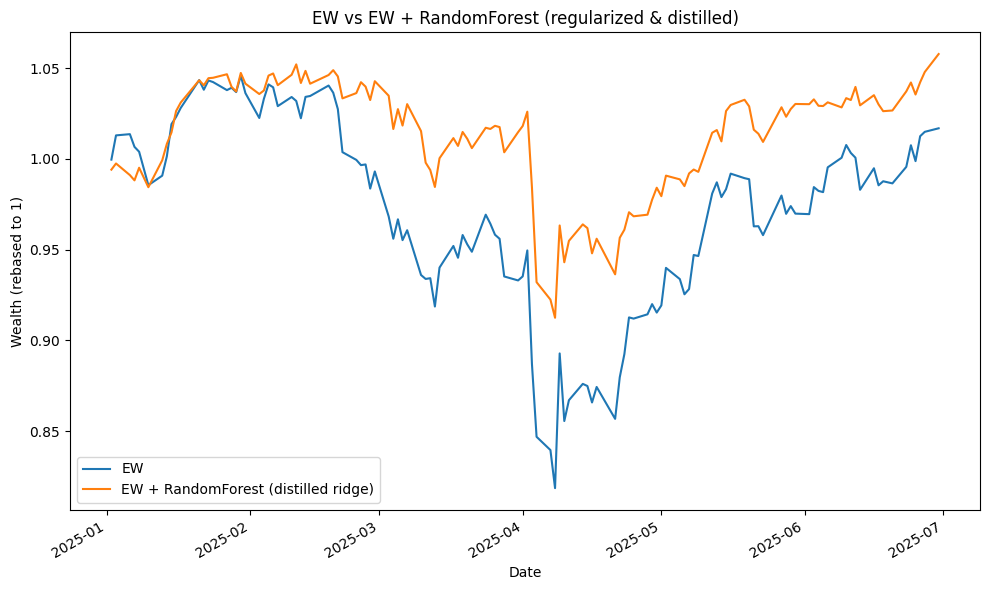

In [21]:
# ============================
# EW-anchored Random Forest (with regularization) + EW benchmark
# Rolling OOS backtest (window=126), daily rebalancing
# ============================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

# ----------------------------
# CONFIG
# ----------------------------
WINDOW      = 126          # rolling lookback
INNER_VAL   = 21           # last 21 window days for inner validation
START_DATE  = "2024-07-03"         # e.g., "2025-07-03" if you want to restrict
RF_GRID = {                # small RF "regularization" grid (tune as needed)
    "n_estimators":   [200],
    "max_depth":      [2, 3, 4],      # shallow trees = regularization
    "min_samples_leaf":[5, 10, 20],   # larger leaves = regularization
    "max_features":   [0.25, 0.5, 0.75],
    "bootstrap":      [True]
}
RIDGE_ALPHAS = np.logspace(-8, 4, 30)  # regularization for distillation

# ----------------------------
# Helpers (EW reframe)
# ----------------------------
def build_N_matrix(p):
    I = np.eye(p-1)
    last_row = -np.ones((1, p-1))
    return np.vstack([I, last_row])  # p x (p-1)

def regression_reframe(R_window):
    """
    Inputs:
      R_window: (T x p) returns in the rolling window
    Returns:
      y: (T,)          = R w_EW
      X: (T x (p-1))   = R N
      w_ew: (p,)       equal-weight vector
      N: (p x (p-1))   transform matrix
    """
    T, p = R_window.shape
    w_ew = np.ones(p) / p
    N = build_N_matrix(p)
    y = R_window @ w_ew
    X = R_window @ N
    return y, X, w_ew, N

def normalize_budget(w):
    s = w.sum()
    return w / s if s != 0 else w

def annualized_sharpe(s, trading_days=252):
    s = pd.Series(s).dropna()
    sd = s.std(ddof=1)
    return np.sqrt(trading_days) * (s.mean()/sd) if sd else np.nan

def cum_wealth(s):
    return (1.0 + pd.Series(s)).cumprod()

# ----------------------------
# Backtests
# ----------------------------
def backtest_EW(returns_df, window=WINDOW):
    ser = returns_df.iloc[window:, :].mean(axis=1)
    ser.name = "EW"
    return ser

def backtest_EW_RF_reg(returns_df, window=WINDOW, inner_val=INNER_VAL,
                       rf_grid=RF_GRID, ridge_alphas=RIDGE_ALPHAS):
    """
    EW + Random Forest regression with regularization via:
      - small, shallow forest (max_depth/min_samples_leaf/max_features tuned)
      - time-aware inner validation (last `inner_val` days) to pick RF params
      - RidgeCV distillation on (X, RF(X)) to get pseudo-beta -> weights
    """
    dates = returns_df.index
    oos = []

    # Pre-build all RF param combos
    from itertools import product
    keys, vals = zip(*rf_grid.items())
    combos = [dict(zip(keys, v)) for v in product(*vals)]

    for t in range(window, len(dates)):
        # Rolling window block
        Rw = returns_df.iloc[t-window:t, :].values  # (WINDOW x p)
        y, X, w_ew, N = regression_reframe(Rw)

        # Time-aware inner split
        X_tr, X_val = X[:-inner_val, :], X[-inner_val:, :]
        y_tr, y_val = y[:-inner_val], y[-inner_val:]

        # Grid-search RF hyper-params by validation MSE on y
        best_mse, best_params = np.inf, combos[0]
        for params in combos:
            rf = RandomForestRegressor(random_state=0, **params)
            rf.fit(X_tr, y_tr)
            y_val_hat = rf.predict(X_val)
            mse = mean_squared_error(y_val, y_val_hat)
            if mse < best_mse:
                best_mse, best_params = mse, params

        # Fit RF on full window with best params
        rf_full = RandomForestRegressor(random_state=0, **best_params)
        rf_full.fit(X, y)
        y_hat = rf_full.predict(X)

        # Distill to linear beta (RidgeCV) so we can convert back to weights
        ridge = RidgeCV(alphas=ridge_alphas, fit_intercept=True).fit(X, y_hat)
        beta = ridge.coef_                        # (p-1,)
        w = normalize_budget(w_ew - (N @ beta))   # (p,)

        # Next-day OOS return
        r_next = returns_df.iloc[t, :].values @ w
        oos.append((dates[t], float(r_next)))

    name = "EW + RandomForest (distilled ridge)"
    return pd.Series([r for _, r in oos], index=[d for d,_ in oos], name=name)

# ----------------------------
# Run & compare
# ----------------------------
# 1) Prepare data
df = returns_df.copy()                 # must be DECIMAL daily returns
if START_DATE:
    df = df.loc[START_DATE:]
df = df.dropna(how="any")             # require full cross-section each day

# 2) Backtest both strategies on same OOS dates
ew_oos   = backtest_EW(df, window=WINDOW)
rf_oos   = backtest_EW_RF_reg(df, window=WINDOW)

# 3) Align (safety)
idx = ew_oos.index.intersection(rf_oos.index)
ew_oos, rf_oos = ew_oos.loc[idx], rf_oos.loc[idx]

# 4) Print annualized Sharpe
print("Annualized Sharpe (OOS):")
print(f"{ew_oos.name:30s}: {annualized_sharpe(ew_oos):.3f}")
print(f"{rf_oos.name:30s}: {annualized_sharpe(rf_oos):.3f}")

print(" Sharpe (OOS):")
print(f"{rf_oos.name:30s}: {sharpe_ratio(rf_oos):.3f}")

# 5) Plot cumulative wealth
plt.figure(figsize=(10,6))
cum_wealth(ew_oos).plot(label=ew_oos.name)
cum_wealth(rf_oos).plot(label=rf_oos.name)
plt.title("EW vs EW + RandomForest (regularized & distilled)")
plt.xlabel("Date"); plt.ylabel("Wealth (rebased to 1)")
plt.legend(); plt.tight_layout(); plt.show()


Adaptive LASSO, Huber, Principal Component Regression

In [22]:
import numpy as np, pandas as pd
from sklearn.linear_model import RidgeCV, LassoCV
import matplotlib.pyplot as plt

WINDOW=126
ALPHAS_RIDGE = np.logspace(-8, 4, 40)
ALPHAS_LASSO = np.logspace(-8, 2, 40)
GAMMA = 1.0
EPS_W = 1e-6

def build_N_matrix(p):
    I=np.eye(p-1); return np.vstack([I, -np.ones((1,p-1))])

def regression_reframe(Rw):
    T,p = Rw.shape
    w_ew = np.ones(p)/p
    N = build_N_matrix(p)
    y = Rw @ w_ew
    X = Rw @ N
    return y,X,w_ew,N

def normalize_budget(w):
    s=w.sum(); return w/s if s!=0 else w

def backtest_EW_reg_adalasso(returns_df, window=WINDOW):
    dates = returns_df.index
    oos=[]
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t,:].values
        y,X,w_ew,N = regression_reframe(Rw)

        # step 1: ridge (stable pilot)
        ridge = RidgeCV(alphas=ALPHAS_RIDGE, fit_intercept=True).fit(X,y)
        beta0 = ridge.coef_
        w_pen = 1.0 / (np.abs(beta0) + EPS_W)**GAMMA  # weights ≥ 1

        # transform to ordinary lasso: X' = X / w_pen, β' = w_pen * β
        X_scaled = X / w_pen

        lasso = LassoCV(alphas=ALPHAS_LASSO, cv=5, max_iter=20000).fit(X_scaled, y)
        beta_adapt = (lasso.coef_ / 1.0) * (1.0 / w_pen)  # invert scaling to original β
        w = normalize_budget(w_ew - (N @ beta_adapt))

        r_next = returns_df.iloc[t,:].values @ w
        oos.append((dates[t], float(r_next)))
    return pd.Series([r for _,r in oos], index=[d for d,_ in oos], name="EW + Adaptive LASSO")


In [23]:
from sklearn.linear_model import HuberRegressor

def backtest_EW_reg_huber(returns_df, window=WINDOW, epsilon=1.35, alpha=1e-4):
    dates = returns_df.index
    oos=[]
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t,:].values
        y,X,w_ew,N = regression_reframe(Rw)

        hub = HuberRegressor(epsilon=epsilon, alpha=alpha, fit_intercept=True, max_iter=2000)
        hub.fit(X,y)
        beta = hub.coef_
        w = normalize_budget(w_ew - (N @ beta))

        r_next = returns_df.iloc[t,:].values @ w
        oos.append((dates[t], float(r_next)))
    return pd.Series([r for _,r in oos], index=[d for d,_ in oos], name=f"EW + Huber (ε={epsilon},α={alpha})")


In [24]:
from sklearn.decomposition import PCA

K_GRID = [5, 10, 15, 20]

def backtest_EW_reg_pcr_ridge(returns_df, window=WINDOW, k_grid=K_GRID, alphas=ALPHAS_RIDGE, inner_val=21):
    dates = returns_df.index
    oos=[]
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t,:].values
        y,X,w_ew,N = regression_reframe(Rw)

        # time-aware split
        X_tr, X_val = X[:-inner_val,:], X[-inner_val:,:]
        y_tr, y_val = y[:-inner_val], y[-inner_val:]

        best, best_params = -np.inf, (k_grid[0], alphas[0])
        for k in k_grid:
            pca = PCA(n_components=k, svd_solver="full").fit(X_tr)
            Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)
            ridge = RidgeCV(alphas=alphas, fit_intercept=True).fit(Z_tr, y_tr)
            y_hat = ridge.predict(Z_val)
            # pick by validation Sharpe (or -MSE)
            sr = np.sqrt(252)*(y_hat.mean()/y_hat.std(ddof=1)) if y_hat.std(ddof=1)>0 else -np.inf
            if sr>best:
                best, best_params = sr, (k, ridge.alpha_)
        # refit on full window
        k_star, alpha_star = best_params
        pca = PCA(n_components=k_star, svd_solver="full").fit(X)
        Z = pca.transform(X)
        ridge = RidgeCV(alphas=[alpha_star], fit_intercept=True).fit(Z, y)
        # map back to β in original space: β = P * β_z
        beta = pca.components_.T @ ridge.coef_
        w = normalize_budget(w_ew - (N @ beta))

        r_next = returns_df.iloc[t,:].values @ w
        oos.append((dates[t], float(r_next)))
    return pd.Series([r for _,r in oos], index=[d for d,_ in oos], name=f"EW + PCR+Ridge")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_

Annualized Sharpe:
Adaptive LASSO : 1.129
Huber         : -1.299
PCR+Ridge     : 1.272
Daily Sharpe:
Adaptive LASSO : 0.071
Huber         : -0.082
PCR+Ridge     : 0.08


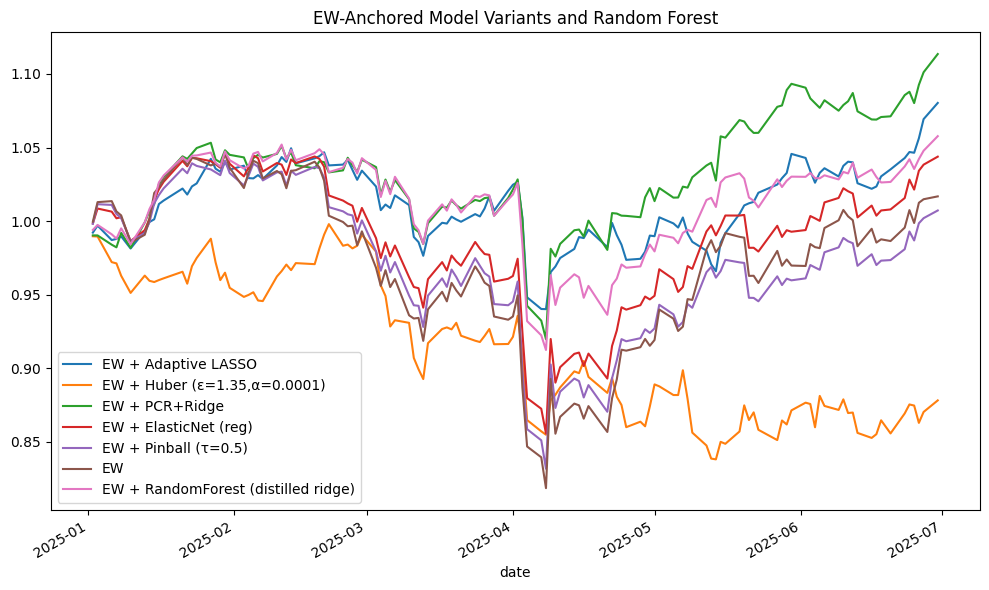

In [25]:
# Optionally, restrict to a period:
returns_df = returns_df.loc["2024-07-03":].dropna(how="any")

adalasso = backtest_EW_reg_adalasso(returns_df)
huber    = backtest_EW_reg_huber(returns_df)
pcrridge = backtest_EW_reg_pcr_ridge(returns_df)

# align & report
idx = adalasso.index.intersection(huber.index).intersection(pcrridge.index)
adalasso, huber, pcrridge = adalasso.loc[idx], huber.loc[idx], pcrridge.loc[idx]

def sharpe(s):
    s=s.dropna(); sd=s.std(ddof=1);
    return np.sqrt(252)*(s.mean()/sd) if sd else np.nan

print("Annualized Sharpe:")
print("Adaptive LASSO :", round(sharpe(adalasso),3))
print("Huber         :", round(sharpe(huber),3))
print("PCR+Ridge     :", round(sharpe(pcrridge),3))

print("Daily Sharpe:")
print("Adaptive LASSO :", round(sharpe(adalasso)/np.sqrt(252),3))
print("Huber         :", round(sharpe(huber)/np.sqrt(252),3))
print("PCR+Ridge     :", round(sharpe(pcrridge)/np.sqrt(252),3))

# wealth plot
import matplotlib.pyplot as plt
def wealth(s): return (1+s).cumprod()
plt.figure(figsize=(10,6))
wealth(adalasso).plot(label="EW + Adaptive LASSO")
wealth(huber).plot(label=huber.name)
wealth(pcrridge).plot(label=pcrridge.name)
cum_wealth(ew_elastic).plot(label=ew_elastic.name)
cum_wealth(ew_pinball).plot(label=ew_pinball.name)
cum_wealth(ew_oos).plot(label=ew_oos.name)
cum_wealth(rf_oos).plot(label=rf_oos.name)
plt.title("EW-Anchored Model Variants and Random Forest"); plt.legend(); plt.tight_layout(); plt.show()


In [26]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV

K_GRID = [5, 10, 15, 20]
ALPHAS_LASSO = np.logspace(-8, 8, 100)  # example, tune as needed

def backtest_EW_reg_pcr_lasso(returns_df, window=WINDOW, k_grid=K_GRID, alphas=ALPHAS_LASSO, inner_val=21):
    dates = returns_df.index
    oos=[]
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t,:].values
        y,X,w_ew,N = regression_reframe(Rw)

        # time-aware split
        X_tr, X_val = X[:-inner_val,:], X[-inner_val:,:]
        y_tr, y_val = y[:-inner_val], y[-inner_val:]

        best, best_params = -np.inf, (k_grid[0], alphas[0])
        for k in k_grid:
            pca = PCA(n_components=k, svd_solver="full").fit(X_tr)
            Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)

            lasso = LassoCV(alphas=alphas, cv=None, fit_intercept=True, max_iter=5000).fit(Z_tr, y_tr)
            y_hat = lasso.predict(Z_val)

            # pick by validation Sharpe (or -MSE)
            sr = (y_hat.mean()/y_hat.std(ddof=1)) if y_hat.std(ddof=1)>0 else -np.inf
            if sr > best:
                best, best_params = sr, (k, lasso.alpha_)

        # refit on full window with best (k, alpha)
        k_star, alpha_star = best_params
        pca = PCA(n_components=k_star, svd_solver="full").fit(X)
        Z = pca.transform(X)

        lasso = LassoCV(alphas=[alpha_star], cv=None, fit_intercept=True, max_iter=5000).fit(Z, y)

        # map back to β in original space: β = P * β_z
        beta = pca.components_.T @ lasso.coef_
        w = normalize_budget(w_ew - (N @ beta))

        r_next = returns_df.iloc[t,:].values @ w
        oos.append((dates[t], float(r_next)))

    return pd.Series([r for _,r in oos], index=[d for d,_ in oos], name=f"EW + PCR + LASSO")


In [27]:
# Optionally, restrict to a period:
returns_df = returns_df.loc["2024-07-03":].dropna(how="any")
pcrlasso = backtest_EW_reg_pcr_lasso(returns_df)

def a_sharpe(s):
    s=s.dropna(); sd=s.std(ddof=1)
    return np.sqrt(252)*(s.mean()/sd) if sd else np.nan

def sharpe(s):
    s=s.dropna(); sd=s.std(ddof=1)
    return (s.mean()/sd) if sd else np.nan

print("Annualized Sharpe:")
print("EW + PCR + LASSO :", round(a_sharpe(pcrlasso),3))


print("Sharpe:")
print("EW + PCR + LASSO :", round(sharpe(pcrlasso),3))



Annualized Sharpe:
EW + PCR + LASSO : 1.382
Sharpe:
EW + PCR + LASSO : 0.087


In [28]:
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV

K_GRID = [5, 10, 15, 20]
ALPHAS_EN = np.logspace(-8, 8, 50)         # penalty strength
L1_RATIOS = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0] # 1.0 = LASSO, 0.0 = Ridge

def backtest_EW_reg_pcr_enet(returns_df, window=WINDOW,
                             k_grid=K_GRID, alphas=ALPHAS_EN,
                             l1_ratios=L1_RATIOS, inner_val=21):
    dates = returns_df.index
    oos=[]
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t,:].values
        y,X,w_ew,N = regression_reframe(Rw)

        # time-aware split
        X_tr, X_val = X[:-inner_val,:], X[-inner_val:,:]
        y_tr, y_val = y[:-inner_val], y[-inner_val:]

        best, best_params = -np.inf, (k_grid[0], alphas[0], l1_ratios[0])
        for k in k_grid:
            pca = PCA(n_components=k, svd_solver="full").fit(X_tr)
            Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)

            enet = ElasticNetCV(alphas=alphas,
                                l1_ratio=l1_ratios,
                                fit_intercept=True,
                                max_iter=5000).fit(Z_tr, y_tr)
            y_hat = enet.predict(Z_val)

            # validation metric: Sharpe (or could use -MSE)
            sr = (y_hat.mean()/y_hat.std(ddof=1)) if y_hat.std(ddof=1)>0 else -np.inf
            if sr > best:
                best, best_params = sr, (k, enet.alpha_, enet.l1_ratio_)

        # refit on full window with best (k, alpha, l1_ratio)
        k_star, alpha_star, l1_star = best_params
        pca = PCA(n_components=k_star, svd_solver="full").fit(X)
        Z = pca.transform(X)

        enet = ElasticNetCV(alphas=[alpha_star],
                            l1_ratio=[l1_star],
                            fit_intercept=True,
                            max_iter=5000).fit(Z, y)

        # map back to β in original space
        beta = pca.components_.T @ enet.coef_
        w = normalize_budget(w_ew - (N @ beta))

        r_next = returns_df.iloc[t,:].values @ w
        oos.append((dates[t], float(r_next)))

    return pd.Series([r for _,r in oos], index=[d for d,_ in oos], name=f"EW + PCR+ElasticNet")


In [29]:
# Optionally, restrict to a period:
returns_df = returns_df.loc["2024-07-03":].dropna(how="any")
pcrenet = backtest_EW_reg_pcr_enet(returns_df)

def a_sharpe(s):
    s=s.dropna(); sd=s.std(ddof=1)
    return np.sqrt(252)*(s.mean()/sd) if sd else np.nan

def sharpe(s):
    s=s.dropna(); sd=s.std(ddof=1)
    return (s.mean()/sd) if sd else np.nan

print("Annualized Sharpe:")
print("EW + PCR+ElasticNet :", round(a_sharpe(pcrenet),3))


print("Sharpe:")
print("EW + PCR+ElasticNet :", round(sharpe(pcrenet),3))


Annualized Sharpe:
EW + PCR+ElasticNet : 1.347
Sharpe:
EW + PCR+ElasticNet : 0.085


In [30]:
import numpy as np, pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV

# --- Config ---
K_GRID = [5, 10, 15, 20]
ALPHAS_LASSO = np.logspace(-8, 4, 50)

# --- Helper: asymmetric utility ---
def asymmetric_utility(r):
    """Mean return divided by downside volatility (penalizes only losses)."""
    if len(r) == 0:
        return -np.inf
    downside = r[r < 0]
    if downside.std(ddof=1) == 0:
        return -np.inf
    return (r.mean() / downside.std(ddof=1))

# --- Backtest function (raw returns) ---
def backtest_EW_reg_pcr_lasso_asym(returns_df, window=126, k_grid=K_GRID,
                                   alphas=ALPHAS_LASSO, inner_val=21):
    dates = returns_df.index
    oos = []
    N_assets = returns_df.shape[1]

    for t in range(window, len(dates)):
        # rolling window
        Rw = returns_df.iloc[t-window:t,:].values

        # regression reframing
        y, X, w_ew, N = regression_reframe(Rw)

        # split train/val
        X_tr, X_val = X[:-inner_val,:], X[-inner_val:,:]
        y_tr, y_val = y[:-inner_val], y[-inner_val:]

        best, best_params = -np.inf, (k_grid[0], alphas[0])
        for k in k_grid:
            pca = PCA(n_components=k, svd_solver="full").fit(X_tr)
            Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)

            lasso = LassoCV(alphas=alphas, cv=5, fit_intercept=True, max_iter=5000).fit(Z_tr, y_tr)
            y_hat = lasso.predict(Z_val)

            # asymmetric utility instead of Sharpe
            score = asymmetric_utility(y_hat)
            if score > best:
                best, best_params = score, (k, lasso.alpha_)

        # refit with chosen params
        k_star, alpha_star = best_params
        pca = PCA(n_components=k_star, svd_solver="full").fit(X)
        Z = pca.transform(X)
        lasso = LassoCV(alphas=[alpha_star], cv=None, fit_intercept=True, max_iter=5000).fit(Z, y)

        # map back: β = P * β_z
        beta = pca.components_.T @ lasso.coef_
        w = normalize_budget(w_ew - (N @ beta))

        # out-of-sample
        r_next = returns_df.iloc[t,:].values @ w
        oos.append((dates[t], float(r_next)))

    return pd.Series([r for _, r in oos], index=[d for d,_ in oos],
                     name=f"EW + PCR+Lasso (asym util)")




In [31]:
series = backtest_EW_reg_pcr_lasso_asym(returns_df)
print("Sharpe:", sharpe(series))

print("A Sharpe:", a_sharpe(series))

Sharpe: 0.09663641328981151
A Sharpe: 1.5340555029485907


In [32]:
import numpy as np, pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV

# --- Config ---
K_GRID = [5, 10, 15, 20]
ALPHAS_LASSO = np.logspace(-8, 4, 50)
CARDINALITY = 20  # maximum number of non-zero assets in portfolio

# --- Helper: asymmetric utility ---
def asymmetric_utility(r):
    """Mean return divided by downside volatility (penalizes only losses)."""
    if len(r) == 0:
        return -np.inf
    downside = r[r < 0]
    if downside.std(ddof=1) == 0:
        return -np.inf
    return (r.mean() / downside.std(ddof=1))

# --- Helper: apply cardinality constraint ---
def apply_cardinality(w, k):
    """
    Keep only top-k absolute weights; zero out the rest.
    """
    if k >= len(w):
        return w
    idx = np.argsort(np.abs(w))[-k:]  # indices of top-k absolute values
    w_new = np.zeros_like(w)
    w_new[idx] = w[idx]
    return w_new

# --- Backtest function ---
def backtest_EW_reg_pcr_lasso_asym_card(returns_df, window=126, k_grid=K_GRID,
                                        alphas=ALPHAS_LASSO, inner_val=21, cardinality=CARDINALITY):
    dates = returns_df.index
    oos = []
    N_assets = returns_df.shape[1]

    for t in range(window, len(dates)):
        # rolling window
        Rw = returns_df.iloc[t-window:t,:].values

        # regression reframing
        y, X, w_ew, N = regression_reframe(Rw)

        # split train/val
        X_tr, X_val = X[:-inner_val,:], X[-inner_val:,:]
        y_tr, y_val = y[:-inner_val], y[-inner_val:]

        best, best_params = -np.inf, (k_grid[0], alphas[0])
        for k in k_grid:
            pca = PCA(n_components=k, svd_solver="full").fit(X_tr)
            Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)

            lasso = LassoCV(alphas=alphas, cv=5, fit_intercept=True, max_iter=5000).fit(Z_tr, y_tr)
            y_hat = lasso.predict(Z_val)

            # asymmetric utility instead of Sharpe
            score = asymmetric_utility(y_hat)
            if score > best:
                best, best_params = score, (k, lasso.alpha_)

        # refit with chosen params
        k_star, alpha_star = best_params
        pca = PCA(n_components=k_star, svd_solver="full").fit(X)
        Z = pca.transform(X)
        lasso = LassoCV(alphas=[alpha_star], cv=None, fit_intercept=True, max_iter=5000).fit(Z, y)

        # map back: β = P * β_z
        beta = pca.components_.T @ lasso.coef_

        # apply cardinality
        beta_sparse = apply_cardinality(beta, cardinality)

        w = normalize_budget(w_ew - (N @ beta_sparse))

        # out-of-sample
        r_next = returns_df.iloc[t,:].values @ w
        oos.append((dates[t], float(r_next)))

    return pd.Series([r for _, r in oos], index=[d for d,_ in oos],
                     name=f"EW + PCR+Lasso (asym util, top-{cardinality})")


In [33]:
n_series = backtest_EW_reg_pcr_lasso_asym_card(returns_df)
print("Sharpe:", sharpe(n_series))
print("A Sharpe:", a_sharpe(n_series))

Sharpe: 0.06458368413285327
A Sharpe: 1.0252342018072678


Annualized metrics (OOS window):


AnnReturn  AnnSharpe  Sharpe
EW+PCR+Lasso (asym util)     0.3104     1.5341  0.0966
EW+PCR+Lasso                 0.2817     1.3801  0.0869
EW+PCR+ElasticNet            0.2811     1.3676  0.0861
EW+PCR+Ridge                 0.2612     1.3200  0.0832

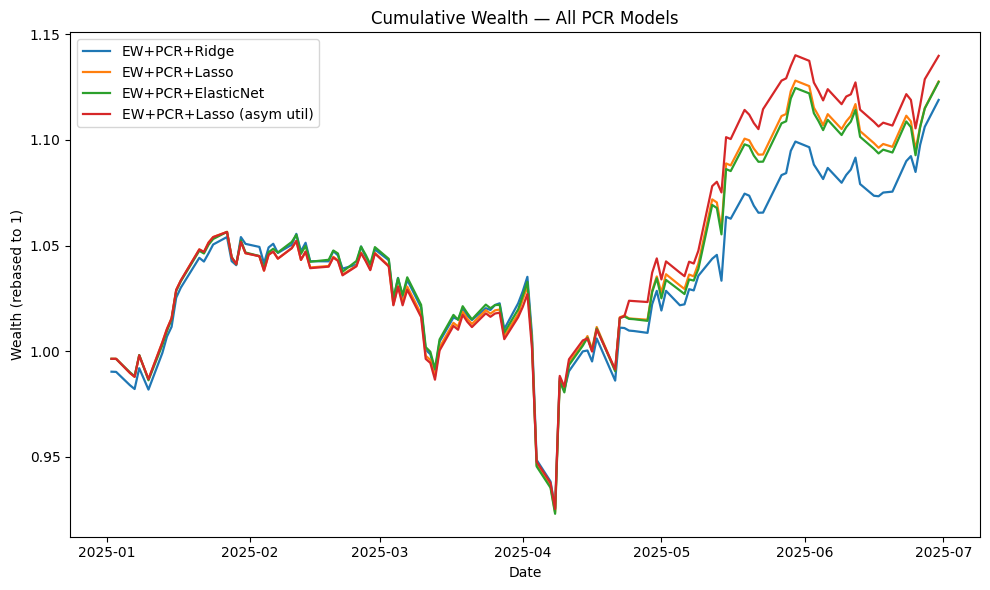

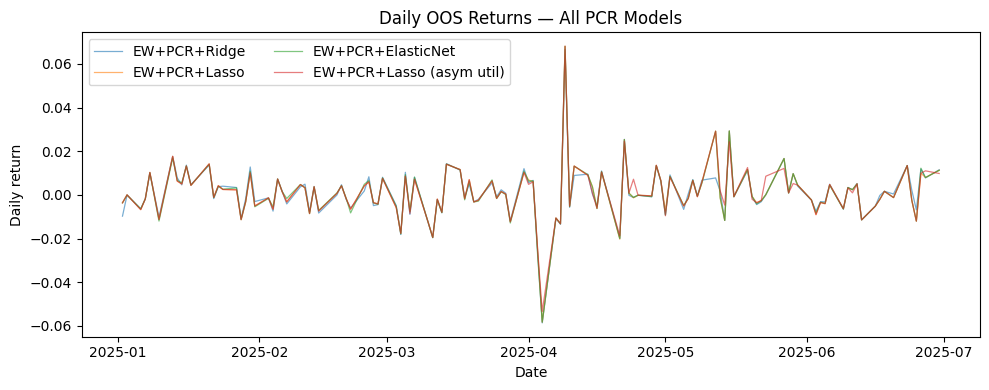

In [34]:
# ===================== One-pipeline backtester & plotter =====================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

# --------------------- Config ---------------------
WINDOW        = 126
INNER_VAL     = 21
K_GRID        = [5, 10, 15, 20]
ALPHAS_RIDGE  = np.logspace(-8, 4, 50)
ALPHAS_LASSO  = np.logspace(-8, 4, 50)
ALPHAS_EN     = np.logspace(-8, 4, 40)
L1_RATIOS     = [0.1, 0.3, 0.5, 0.7, 0.9]
START_DATE    = "2024-07-03"   # change or set to None
TRADING_DAYS  = 252

# --------------------- Helpers ---------------------
def build_N_matrix(p):
    I = np.eye(p-1)
    return np.vstack([I, -np.ones((1, p-1))])   # (p x p-1)

def regression_reframe(Rw):
    T, p = Rw.shape
    w_ew = np.ones(p)/p
    N    = build_N_matrix(p)
    y    = Rw @ w_ew          # (T,)
    X    = Rw @ N             # (T, p-1)
    return y, X, w_ew, N

def normalize_budget(w):
    s = w.sum()
    return w/s if s != 0 else w

def ann_sharpe(d):
    d = pd.Series(d).dropna()
    sd = d.std(ddof=1)
    return np.sqrt(TRADING_DAYS) * (d.mean()/sd) if sd>0 else np.nan

def ann_return(d):
    d = pd.Series(d).dropna()
    if len(d)==0: return np.nan
    wealth = (1.0 + d).prod()
    years  = len(d)/TRADING_DAYS
    return wealth**(1/years) - 1

def asymmetric_utility(r):
    r = pd.Series(r)
    downside = r[r < 0]
    if len(downside) < 3 or downside.std(ddof=1) == 0:
        return -np.inf
    return r.mean() / downside.std(ddof=1)

# --------------------- Backtests ---------------------
def backtest_EW_reg_pcr_ridge(returns_df, window=WINDOW, k_grid=K_GRID, alphas=ALPHAS_RIDGE, inner_val=INNER_VAL):
    dates = returns_df.index
    oos=[]
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t,:].values
        y, X, w_ew, N = regression_reframe(Rw)

        # time-aware split
        if len(X) <= inner_val + 5:
            continue
        X_tr, X_val = X[:-inner_val,:], X[-inner_val:,:]
        y_tr, y_val = y[:-inner_val],   y[-inner_val:]

        best, best_params = -np.inf, (k_grid[0], alphas[0])
        for k in k_grid:
            pca  = PCA(n_components=k, svd_solver="full").fit(X_tr)
            Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)
            ridge = RidgeCV(alphas=alphas, fit_intercept=True).fit(Z_tr, y_tr)
            y_hat = ridge.predict(Z_val)
            sr    = (y_hat.mean()/y_hat.std(ddof=1)) if y_hat.std(ddof=1)>0 else -np.inf
            if sr > best:
                best, best_params = sr, (k, ridge.alpha_)
        # refit full window
        k_star, alpha_star = best_params
        pca  = PCA(n_components=k_star, svd_solver="full").fit(X)
        Z    = pca.transform(X)
        ridge= RidgeCV(alphas=[alpha_star], fit_intercept=True).fit(Z, y)
        beta = pca.components_.T @ ridge.coef_
        w    = normalize_budget(w_ew - (N @ beta))

        r_next = returns_df.iloc[t,:].values @ w
        oos.append((dates[t], float(r_next)))
    return pd.Series([r for _,r in oos], index=[d for d,_ in oos], name="EW+PCR+Ridge")

def backtest_EW_reg_pcr_lasso(returns_df, window=WINDOW, k_grid=K_GRID, alphas=ALPHAS_LASSO, inner_val=INNER_VAL):
    dates = returns_df.index
    oos=[]
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t,:].values
        y, X, w_ew, N = regression_reframe(Rw)

        if len(X) <= inner_val + 5:
            continue
        X_tr, X_val = X[:-inner_val,:], X[-inner_val:,:]
        y_tr, y_val = y[:-inner_val],   y[-inner_val:]

        best, best_params = -np.inf, (k_grid[0], alphas[0])
        for k in k_grid:
            pca  = PCA(n_components=k, svd_solver="full").fit(X_tr)
            Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)
            lasso = LassoCV(alphas=alphas, cv=None, fit_intercept=True, max_iter=5000).fit(Z_tr, y_tr)
            y_hat = lasso.predict(Z_val)
            sr    = (y_hat.mean()/y_hat.std(ddof=1)) if y_hat.std(ddof=1)>0 else -np.inf
            if sr > best:
                best, best_params = sr, (k, lasso.alpha_)
        # refit full window
        k_star, alpha_star = best_params
        pca   = PCA(n_components=k_star, svd_solver="full").fit(X)
        Z     = pca.transform(X)
        lasso = LassoCV(alphas=[alpha_star], cv=None, fit_intercept=True, max_iter=5000).fit(Z, y)
        beta  = pca.components_.T @ lasso.coef_
        w     = normalize_budget(w_ew - (N @ beta))
        r_next= returns_df.iloc[t,:].values @ w
        oos.append((dates[t], float(r_next)))
    return pd.Series([r for _,r in oos], index=[d for d,_ in oos], name="EW+PCR+Lasso")

def backtest_EW_reg_pcr_enet(returns_df, window=WINDOW, k_grid=K_GRID, alphas=ALPHAS_EN, l1_ratios=L1_RATIOS, inner_val=INNER_VAL):
    dates = returns_df.index
    oos=[]
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t,:].values
        y, X, w_ew, N = regression_reframe(Rw)

        if len(X) <= inner_val + 5:
            continue
        X_tr, X_val = X[:-inner_val,:], X[-inner_val:,:]
        y_tr, y_val = y[:-inner_val],   y[-inner_val:]

        best, best_params = -np.inf, (k_grid[0], alphas[0], l1_ratios[0])
        for k in k_grid:
            pca  = PCA(n_components=k, svd_solver="full").fit(X_tr)
            Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)
            enet = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, fit_intercept=True, max_iter=5000).fit(Z_tr, y_tr)
            y_hat = enet.predict(Z_val)
            sr    = (y_hat.mean()/y_hat.std(ddof=1)) if y_hat.std(ddof=1)>0 else -np.inf
            if sr > best:
                best, best_params = sr, (k, enet.alpha_, enet.l1_ratio_)
        # refit full window
        k_star, alpha_star, l1_star = best_params
        pca  = PCA(n_components=k_star, svd_solver="full").fit(X)
        Z    = pca.transform(X)
        enet = ElasticNetCV(alphas=[alpha_star], l1_ratio=[l1_star], fit_intercept=True, max_iter=5000).fit(Z, y)
        beta = pca.components_.T @ enet.coef_
        w    = normalize_budget(w_ew - (N @ beta))
        r_next = returns_df.iloc[t,:].values @ w
        oos.append((dates[t], float(r_next)))
    return pd.Series([r for _,r in oos], index=[d for d,_ in oos], name="EW+PCR+ElasticNet")

def backtest_EW_reg_pcr_lasso_asym(returns_df, window=WINDOW, k_grid=K_GRID, alphas=ALPHAS_LASSO, inner_val=INNER_VAL):
    dates = returns_df.index
    oos=[]
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t,:].values
        y, X, w_ew, N = regression_reframe(Rw)

        if len(X) <= inner_val + 5:
            continue
        X_tr, X_val = X[:-inner_val,:], X[-inner_val:,:]
        y_tr, y_val = y[:-inner_val],   y[-inner_val:]

        best, best_params = -np.inf, (k_grid[0], alphas[0])
        for k in k_grid:
            pca  = PCA(n_components=k, svd_solver="full").fit(X_tr)
            Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)
            lasso = LassoCV(alphas=alphas, cv=5, fit_intercept=True, max_iter=5000).fit(Z_tr, y_tr)
            y_hat = lasso.predict(Z_val)
            score = asymmetric_utility(pd.Series(y_hat))
            if score > best:
                best, best_params = score, (k, lasso.alpha_)
        # refit full window
        k_star, alpha_star = best_params
        pca   = PCA(n_components=k_star, svd_solver="full").fit(X)
        Z     = pca.transform(X)
        lasso = LassoCV(alphas=[alpha_star], cv=None, fit_intercept=True, max_iter=5000).fit(Z, y)
        beta  = pca.components_.T @ lasso.coef_
        w     = normalize_budget(w_ew - (N @ beta))
        r_next= returns_df.iloc[t,:].values @ w
        oos.append((dates[t], float(r_next)))
    return pd.Series([r for _,r in oos], index=[d for d,_ in oos], name="EW+PCR+Lasso (asym util)")

# --------------------- Run all & plot ---------------------
def run_all_and_plot(returns_df, start_date=START_DATE, window=WINDOW):
    df = returns_df.copy()
    if start_date is not None:
        df = df.loc[start_date:].dropna(how="any")

    s_ridge = backtest_EW_reg_pcr_ridge(df, window=window)
    s_lasso = backtest_EW_reg_pcr_lasso(df, window=window)
    s_enet  = backtest_EW_reg_pcr_enet(df,  window=window)
    s_asym  = backtest_EW_reg_pcr_lasso_asym(df, window=window)

    # align
    all_series = [s_ridge, s_lasso, s_enet, s_asym]
    oos_df = pd.concat(all_series, axis=1).dropna(how="all")

    # metrics
    metrics = {
        name: {"AnnReturn": ann_return(oos_df[name]), "AnnSharpe": ann_sharpe(oos_df[name]), "Sharpe": ann_sharpe(oos_df[name])/np.sqrt(252)}
        for name in oos_df.columns
    }
    metrics_df = pd.DataFrame(metrics).T.sort_values("AnnSharpe", ascending=False)
    print("Annualized metrics (OOS window):")
    display(metrics_df.round(4))

    # cumulative wealth
    cum = (1.0 + oos_df).fillna(0).cumprod()
    plt.figure(figsize=(10,6))
    for col in cum.columns:
        plt.plot(cum.index, cum[col], label=col, linewidth=1.6)
    plt.title("Cumulative Wealth — All PCR Models")
    plt.xlabel("Date"); plt.ylabel("Wealth (rebased to 1)")
    plt.legend(); plt.tight_layout(); plt.show()

    # (optional) overlay daily returns (can be noisy)
    plt.figure(figsize=(10,4))
    for col in oos_df.columns:
        plt.plot(oos_df.index, oos_df[col], alpha=0.6, linewidth=0.9, label=col)
    plt.title("Daily OOS Returns — All PCR Models")
    plt.xlabel("Date"); plt.ylabel("Daily return")
    plt.legend(ncol=2); plt.tight_layout(); plt.show()

    return oos_df, metrics_df

# --------------------- CALL ---------------------
oos_df, metrics_df = run_all_and_plot(returns_df)


In [35]:
START_DATE = "2024-07-03"
# Expect: returns_df exists (DECIMAL daily returns, index=Date, columns=assets)
df = returns_df.copy()
df = df.loc[START_DATE:]                      # consider only data since 2025-07-03
df = df.dropna(how="any")
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV, Ridge
from sklearn.preprocessing import StandardScaler

# -----------------------------
# CONFIG
# -----------------------------
WINDOW = 126
INNER_VAL = 21
K_GRID = [5, 10, 15]
ALPHAS_RIDGE = np.logspace(-8, 4, 50)
ALPHAS_LASSO = np.logspace(-8, 4, 50)

# -----------------------------
# Helpers
# -----------------------------
def normalize_budget(w):
    s = w.sum()
    return w / s if s != 0 else w

def regression_reframe(R_window):
    """y = R w_EW, X = R N"""
    T, p = R_window.shape
    w_ew = np.ones(p) / p
    N = np.vstack([np.eye(p-1), -np.ones((1, p-1))])  # p x (p-1)
    y = R_window @ w_ew
    X = R_window @ N
    return y, X, w_ew, N

def sharpe_ratio(s):
    s = pd.Series(s).dropna()
    return s.mean()/s.std(ddof=1)

# -----------------------------
# Backtest: EW + PCA + Ridge/LASSO + Stacking
# -----------------------------
def backtest_EW_PCA_ensemble(returns_df, window=WINDOW, inner_val=INNER_VAL,
                             k_grid=K_GRID, alphas_ridge=ALPHAS_RIDGE, alphas_lasso=ALPHAS_LASSO):
    dates = returns_df.index
    p = returns_df.shape[1]
    oos = []

    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t,:].values
        y, X, w_ew, N = regression_reframe(Rw)

        # --- Train/Validation Split ---
        X_tr, X_val = X[:-inner_val,:], X[-inner_val:,:]
        y_tr, y_val = y[:-inner_val], y[-inner_val:]

        # --- PCA + Ridge/LASSO Forecasts ---
        forecasts_tr, forecasts_val = [], []
        best_params = []

        for k in k_grid:
            pca = PCA(n_components=k).fit(X_tr)
            Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)

            # Ridge
            ridge = RidgeCV(alphas=alphas_ridge).fit(Z_tr, y_tr)
            y_hat_val_ridge = ridge.predict(Z_val)
            forecasts_val.append(y_hat_val_ridge)
            forecasts_tr.append(ridge.predict(Z_tr))
            best_params.append(('ridge', k, ridge.alpha_))

            # LASSO
            lasso = LassoCV(alphas=alphas_lasso, cv=5, max_iter=5000).fit(Z_tr, y_tr)
            y_hat_val_lasso = lasso.predict(Z_val)
            forecasts_val.append(y_hat_val_lasso)
            forecasts_tr.append(lasso.predict(Z_tr))
            best_params.append(('lasso', k, lasso.alpha_))

        # --- Stack via Ridge on validation ---
        X_stack_tr = np.column_stack(forecasts_tr)
        X_stack_val = np.column_stack(forecasts_val)
        meta_model = Ridge(alpha=1e-3).fit(X_stack_tr, y_tr)
        y_hat_final = meta_model.predict(X_stack_val)

        # --- Refit chosen models on full window ---
        # pick best Ridge and best LASSO by validation Sharpe
        best_idx = np.argmax([sharpe_ratio(f) for f in forecasts_val])
        model_type, k_star, alpha_star = best_params[best_idx]

        pca_final = PCA(n_components=k_star).fit(X)
        Z_full = pca_final.transform(X)

        if model_type == 'ridge':
            base_model = Ridge(alpha=alpha_star).fit(Z_full, y)
        else:
            base_model = LassoCV(alphas=[alpha_star], cv=None, max_iter=5000).fit(Z_full, y)

        beta = pca_final.components_.T @ base_model.coef_
        w = normalize_budget(w_ew - (N @ beta))

        r_next = returns_df.iloc[t,:].values @ w
        oos.append((dates[t], float(r_next)))

    return pd.Series([r for _, r in oos], index=[d for d,_ in oos], name="EW + PCA + Ridge/LASSO Stacked")

# -----------------------------
# Example usage
# -----------------------------
# returns_df should be DECIMAL returns (Date x Assets)
stacked_ser = backtest_EW_PCA_ensemble(df)
print("Stacked Sharpe:", sharpe_ratio(stacked_ser))


Stacked Sharpe: 0.0949866796552754


In [36]:
def backtest_EW_PCA_ensemble_denoised(returns_df, window=WINDOW, inner_val=INNER_VAL,
                                      k_grid=K_GRID, alphas_ridge=ALPHAS_RIDGE,
                                      alphas_lasso=ALPHAS_LASSO, k_denoise=10):
    dates = returns_df.index
    p = returns_df.shape[1]
    oos = []

    for t in range(window, len(dates)):
        # raw window
        R_window = returns_df.iloc[t-window:t,:].values

        # --- Denoise the returns ---
        Rw = denoise_returns(R_window, k_top=k_denoise)

        # --- Regression frame ---
        y, X, w_ew, N = regression_reframe(Rw)

        # --- Train/Validation Split ---
        X_tr, X_val = X[:-inner_val,:], X[-inner_val:,:]
        y_tr, y_val = y[:-inner_val], y[-inner_val:]

        # --- PCA + Ridge/LASSO Forecasts ---
        forecasts_tr, forecasts_val = [], []
        best_params = []

        for k in k_grid:
            pca = PCA(n_components=k).fit(X_tr)
            Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)

            # Ridge
            ridge = RidgeCV(alphas=alphas_ridge).fit(Z_tr, y_tr)
            y_hat_val_ridge = ridge.predict(Z_val)
            forecasts_val.append(y_hat_val_ridge)
            forecasts_tr.append(ridge.predict(Z_tr))
            best_params.append(('ridge', k, ridge.alpha_))

            # LASSO
            lasso = LassoCV(alphas=alphas_lasso, cv=5, max_iter=5000).fit(Z_tr, y_tr)
            y_hat_val_lasso = lasso.predict(Z_val)
            forecasts_val.append(y_hat_val_lasso)
            forecasts_tr.append(lasso.predict(Z_tr))
            best_params.append(('lasso', k, lasso.alpha_))

        # --- Stack via Ridge on validation ---
        X_stack_tr = np.column_stack(forecasts_tr)
        X_stack_val = np.column_stack(forecasts_val)
        meta_model = Ridge(alpha=1e-3).fit(X_stack_tr, y_tr)
        y_hat_final = meta_model.predict(X_stack_val)

        # --- Refit chosen models on full window ---
        best_idx = np.argmax([sharpe_ratio(f) for f in forecasts_val])
        model_type, k_star, alpha_star = best_params[best_idx]

        pca_final = PCA(n_components=k_star).fit(X)
        Z_full = pca_final.transform(X)

        if model_type == 'ridge':
            base_model = Ridge(alpha=alpha_star).fit(Z_full, y)
        else:
            base_model = LassoCV(alphas=[alpha_star], cv=None, max_iter=5000).fit(Z_full, y)

        beta = pca_final.components_.T @ base_model.coef_
        w = normalize_budget(w_ew - (N @ beta))

        r_next = returns_df.iloc[t,:].values @ w
        oos.append((dates[t], float(r_next)))

    return pd.Series([r for _, r in oos], index=[d for d,_ in oos],
                     name=f"EW + PCA + Ridge/LASSO Stacked (denoised k={k_denoise})")


In [38]:
def denoise_returns(R_window, k_top=10):
    R_centered = R_window - R_window.mean(axis=0)
    U, S, Vt   = np.linalg.svd(R_centered, full_matrices=False)
    S_shrunk   = np.zeros_like(S); S_shrunk[:k_top] = S[:k_top]
    return U @ np.diag(S_shrunk) @ Vt + R_window.mean(axis=0)
stacked_denoised_ser = backtest_EW_PCA_ensemble_denoised(df, k_denoise=10)
print("Stacked denoised Sharpe:", sharpe_ratio(stacked_denoised_ser))
def a_sharpe(s):
    s=s.dropna(); sd=s.std(ddof=1)
    return np.sqrt(252)*(s.mean()/sd) if sd else np.nan


print("Annualized Sharpe:")
print("EW + PCA + Ridge/LASSO Stacked :", round(a_sharpe(stacked_denoised_ser),3))


Stacked denoised Sharpe: 0.20162481369904775
Annualized Sharpe:
EW + PCA + Ridge/LASSO Stacked : 3.201


Annualized metrics (OOS):


AnnReturn  AnnSharpe  Sharpe
Stacked: denoised (k=10)     0.8528     3.2007  0.2016
Stacked: denoised (k=15)     0.3885     1.6729  0.1054
Stacked: raw                 0.3164     1.5079  0.0950

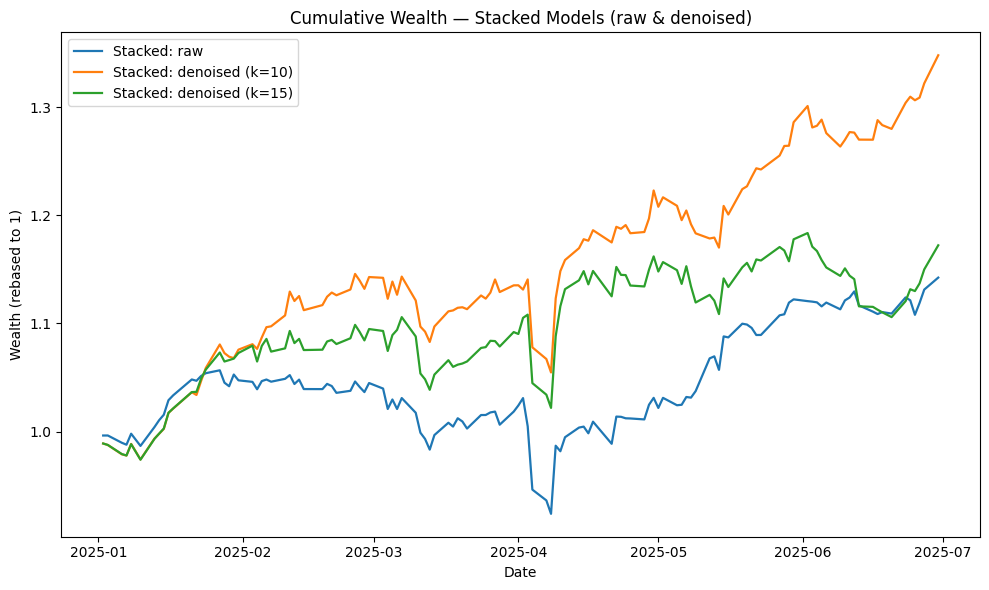

In [39]:
# ===================== Stacked-models pipeline (raw + denoised) =====================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV, Ridge

# --------------------- Config ---------------------
START_DATE   = "2024-07-03"     # change if needed
WINDOW       = 126
INNER_VAL    = 21
K_GRID       = [5, 10, 15]
ALPHAS_RIDGE = np.logspace(-8, 4, 50)
ALPHAS_LASSO = np.logspace(-8, 4, 50)
TRADING_DAYS = 252

# --------------------- Helpers ---------------------
def normalize_budget(w):
    s = w.sum()
    return w/s if s != 0 else w

def regression_reframe(R_window):
    """ y = R w_EW,  X = R N  where N maps (p-1) free params to full-investment weights """
    T, p = R_window.shape
    w_ew = np.ones(p) / p
    N    = np.vstack([np.eye(p-1), -np.ones((1, p-1))])  # p x (p-1)
    y    = R_window @ w_ew
    X    = R_window @ N
    return y, X, w_ew, N

def sharpe_ratio(s):
    s = pd.Series(s).dropna()
    sd = s.std(ddof=1)
    return s.mean()/sd if sd>0 else np.nan

def ann_sharpe(d):
    d = pd.Series(d).dropna()
    sd = d.std(ddof=1)
    return np.sqrt(TRADING_DAYS) * (d.mean()/sd) if sd>0 else np.nan

def ann_return(d):
    d = pd.Series(d).dropna()
    if len(d)==0: return np.nan
    wealth = (1.0 + d).prod()
    years  = len(d)/TRADING_DAYS
    return wealth**(1/years) - 1

# --- Denoise a window of returns via top-k PCs in the time dimension ---
def denoise_returns(R_window, k_top=10):
    R_centered = R_window - R_window.mean(axis=0)
    U, S, Vt   = np.linalg.svd(R_centered, full_matrices=False)
    S_shrunk   = np.zeros_like(S); S_shrunk[:k_top] = S[:k_top]
    return U @ np.diag(S_shrunk) @ Vt + R_window.mean(axis=0)

# --------------------- Core backtests (stacked selection) ---------------------
def backtest_EW_PCA_ensemble(returns_df, window=WINDOW, inner_val=INNER_VAL,
                             k_grid=K_GRID, alphas_ridge=ALPHAS_RIDGE, alphas_lasso=ALPHAS_LASSO):
    """Raw stacked variant: per window, try PCA(k)+Ridge and PCA(k)+LASSO, pick best by validation Sharpe, refit on full window, trade next day."""
    dates = returns_df.index
    oos   = []
    for t in range(window, len(dates)):
        Rw = returns_df.iloc[t-window:t,:].values
        y, X, w_ew, N = regression_reframe(Rw)

        if len(X) <= inner_val + 5:
            continue
        X_tr, X_val = X[:-inner_val,:], X[-inner_val:,:]
        y_tr, y_val = y[:-inner_val],   y[-inner_val:]

        best_score, best_params = -np.inf, ("ridge", k_grid[0], alphas_ridge[0])
        for k in k_grid:
            pca  = PCA(n_components=k).fit(X_tr)
            Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)

            # Ridge branch
            ridge = RidgeCV(alphas=alphas_ridge).fit(Z_tr, y_tr)
            yhat_r = ridge.predict(Z_val)
            sr_r   = sharpe_ratio(yhat_r)
            if sr_r > best_score:
                best_score, best_params = sr_r, ("ridge", k, ridge.alpha_)

            # LASSO branch
            lasso = LassoCV(alphas=alphas_lasso, cv=5, max_iter=5000).fit(Z_tr, y_tr)
            yhat_l = lasso.predict(Z_val)
            sr_l   = sharpe_ratio(yhat_l)
            if sr_l > best_score:
                best_score, best_params = sr_l, ("lasso", k, lasso.alpha_)

        # Refit chosen base model on full window, map back to weights
        mtype, k_star, alpha_star = best_params
        pca_full = PCA(n_components=k_star).fit(X)
        Z_full   = pca_full.transform(X)
        if mtype == "ridge":
            base = RidgeCV(alphas=[alpha_star]).fit(Z_full, y)
            beta = pca_full.components_.T @ base.coef_
        else:
            base = LassoCV(alphas=[alpha_star], cv=None, max_iter=5000).fit(Z_full, y)
            beta = pca_full.components_.T @ base.coef_
        w = normalize_budget(w_ew - (N @ beta))

        r_next = float(returns_df.iloc[t,:].values @ w)
        oos.append((dates[t], r_next))

    return pd.Series([r for _, r in oos], index=[d for d,_ in oos], name="Stacked: raw")

def backtest_EW_PCA_ensemble_denoised(returns_df, k_denoise=10, window=WINDOW, inner_val=INNER_VAL,
                                      k_grid=K_GRID, alphas_ridge=ALPHAS_RIDGE, alphas_lasso=ALPHAS_LASSO):
    """Denoised stacked variant: same as above but PCA-denoise each training window first."""
    dates = returns_df.index
    oos   = []
    for t in range(window, len(dates)):
        Rw_raw = returns_df.iloc[t-window:t,:].values
        Rw     = denoise_returns(Rw_raw, k_top=k_denoise)

        y, X, w_ew, N = regression_reframe(Rw)
        if len(X) <= inner_val + 5:
            continue
        X_tr, X_val = X[:-inner_val,:], X[-inner_val:,:]
        y_tr, y_val = y[:-inner_val],   y[-inner_val:]

        best_score, best_params = -np.inf, ("ridge", k_grid[0], alphas_ridge[0])
        for k in k_grid:
            pca  = PCA(n_components=k).fit(X_tr)
            Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)

            ridge = RidgeCV(alphas=alphas_ridge).fit(Z_tr, y_tr)
            yhat_r = ridge.predict(Z_val)
            sr_r   = sharpe_ratio(yhat_r)
            if sr_r > best_score:
                best_score, best_params = sr_r, ("ridge", k, ridge.alpha_)

            lasso = LassoCV(alphas=alphas_lasso, cv=5, max_iter=5000).fit(Z_tr, y_tr)
            yhat_l = lasso.predict(Z_val)
            sr_l   = sharpe_ratio(yhat_l)
            if sr_l > best_score:
                best_score, best_params = sr_l, ("lasso", k, lasso.alpha_)

        # Refit chosen base on full (denoised) window, map to weights
        mtype, k_star, alpha_star = best_params
        pca_full = PCA(n_components=k_star).fit(X)
        Z_full   = pca_full.transform(X)
        if mtype == "ridge":
            base = RidgeCV(alphas=[alpha_star]).fit(Z_full, y)
            beta = pca_full.components_.T @ base.coef_
        else:
            base = LassoCV(alphas=[alpha_star], cv=None, max_iter=5000).fit(Z_full, y)
            beta = pca_full.components_.T @ base.coef_
        w = normalize_budget(w_ew - (N @ beta))

        r_next = float(returns_df.iloc[t,:].values @ w)
        oos.append((dates[t], r_next))

    return pd.Series([r for _, r in oos], index=[d for d,_ in oos],
                     name=f"Stacked: denoised (k={k_denoise})")

# --------------------- Runner: club & plot ---------------------
def run_stacked_models_and_plot(returns_df, start_date=START_DATE, denoise_grid=(10, 15)):
    df = returns_df.copy()
    if start_date:
        df = df.loc[start_date:].dropna(how="any")

    # run raw
    s_raw = backtest_EW_PCA_ensemble(df)

    # run denoised variants
    denoised_series = [backtest_EW_PCA_ensemble_denoised(df, k_denoise=k) for k in denoise_grid]

    # align on common OOS dates
    all_series = [s_raw] + denoised_series
    oos_df = pd.concat(all_series, axis=1).dropna()

    # metrics
    metrics = {col: {"AnnReturn": ann_return(oos_df[col]),
                     "AnnSharpe": ann_sharpe(oos_df[col]),
                     "Sharpe": ann_sharpe(oos_df[col])/np.sqrt(252)}
               for col in oos_df.columns}
    metrics_df = pd.DataFrame(metrics).T.sort_values("AnnSharpe", ascending=False)
    print("Annualized metrics (OOS):")
    display(metrics_df.round(4))

    # plot cumulative wealth
    cum = (1.0 + oos_df).cumprod()
    plt.figure(figsize=(10,6))
    for col in cum.columns:
        plt.plot(cum.index, cum[col], label=col, linewidth=1.6)
    plt.title("Cumulative Wealth — Stacked Models (raw & denoised)")
    plt.xlabel("Date"); plt.ylabel("Wealth (rebased to 1)")
    plt.legend(); plt.tight_layout(); plt.show()

    return oos_df, metrics_df

# --------------------- Example call ---------------------
# Expect: returns_df exists (DECIMAL daily returns, index=Date, columns=assets)
oos_stacked_df, stacked_metrics = run_stacked_models_and_plot(returns_df, start_date=START_DATE, denoise_grid=(10, 15))



Oracle benchmarks (annualized):
                                 AnnReturn  AnnSharpe
Oracle Rolling MaxSharpe (H=21)     1.5974     3.2205
Oracle Static MaxSharpe             0.7182     1.8636
Oracle Best Asset [BIG LoOP]        1.2723     1.8015


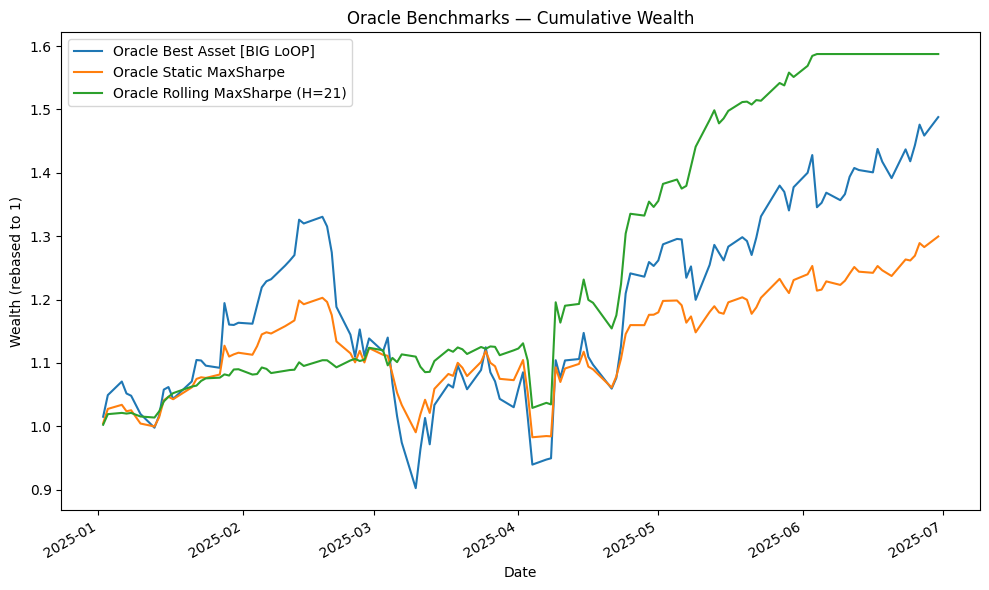


Static MaxSharpe weights (top 10 by weight):
ME10 OP6    0.5077
BIG LoOP    0.4923
ME1 OP5     0.0000
ME9 OP2     0.0000
ME10 OP3    0.0000
ME7 OP6     0.0000
ME10 OP8    0.0000
ME6 OP2     0.0000
ME3 OP10    0.0000
ME9 OP10    0.0000
dtype: float64

Best-Asset oracle picked: BIG LoOP


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ===================== CONFIG =====================
TEST_START = "2025-01-02"          # e.g. "2025-01-02" or leave None to use full
TEST_END   = "2025-06-30"
H_BLOCK    = 21            # block length for rolling oracle
TRADING_DAYS = 252
EPS = 1e-8                 # ridge for Sigma
BOUNDS_LONG_ONLY = True    # set False to allow limited shorting (see bounds below)

# ===================== HELPERS =====================
def annualized_return(daily):
    daily = pd.Series(daily).dropna()
    if len(daily)==0: return np.nan
    wealth = (1.0 + daily).prod()
    years  = len(daily)/TRADING_DAYS
    return wealth**(1/years) - 1

def annualized_sharpe(daily):
    s = pd.Series(daily).dropna()
    sd = s.std(ddof=1)
    return np.sqrt(TRADING_DAYS)*(s.mean()/sd) if sd>0 else np.nan

def cum_wealth(daily):
    return (1.0 + pd.Series(daily)).cumprod()

def make_bounds(p, long_only=True):
    if long_only:
        return [(0.0, 1.0)]*p
    else:
        # example: allow limited shorting, leverage capped by box bounds
        return [(-0.10, 0.20)]*p  # tweak as needed

def project_simplex(w):
    s = w.sum()
    return w/s if s!=0 else w

# ---------- convex subproblem: min variance s.t. sum w=1, w'μ >= R, bounds ----------
def minvar_for_target(mu, Sigma, R_target, bounds):
    p = len(mu)
    Sigma_r = Sigma + EPS*np.eye(p)
    # objective: w' Σ w
    def obj(w): return float(w @ Sigma_r @ w)
    cons = [
        {'type':'eq',  'fun': lambda w: w.sum() - 1.0},
        {'type':'ineq','fun': lambda w, mu=mu, R=R_target: w @ mu - R}
    ]
    w0 = np.ones(p)/p
    res = minimize(obj, w0, method='SLSQP', bounds=bounds, constraints=cons,
                   options={'maxiter': 200, 'ftol': 1e-12, 'disp': False})
    return res.x if res.success else project_simplex(np.clip(w0, *bounds[0]))

def oracle_static_max_sharpe(mu, Sigma, bounds):
    """
    Sweep target returns along feasible range; choose the point with max Sharpe.
    """
    p = len(mu)
    mu_min, mu_max = float(np.min(mu)), float(np.max(mu))
    # target grid between EW mean and near the max mean (avoid infeasible extremes)
    grid = np.linspace(mu_min*0.5 + mu_max*0.5, mu_max, 25)
    best_sr, best_w = -np.inf, np.ones(p)/p
    for R in grid:
        w = minvar_for_target(mu, Sigma, R, bounds)
        num = float(w @ mu)
        den = float(np.sqrt(max(w @ Sigma @ w, EPS)))
        sr = num/den if den>0 else -np.inf
        if sr > best_sr:
            best_sr, best_w = sr, w
    return best_w, best_sr

# ===================== ORACLE 1: BEST ASSET (COMPOUNDED) =====================
def oracle_best_asset(returns_df):
    # choose asset maximizing compound return ∏(1+r) - 1 over test window
    compounded = (1.0 + returns_df).prod(axis=0) - 1.0
    j = compounded.values.argmax()
    w = np.zeros(returns_df.shape[1]); w[j] = 1.0
    port = returns_df.values @ w
    return pd.Series(port, index=returns_df.index, name=f"Oracle Best Asset [{returns_df.columns[j]}]"), w

# ===================== ORACLE 2: STATIC MAX-SHARPE =====================
def oracle_static_maxsharpe(returns_df, long_only=True):
    X = returns_df.values
    mu = X.mean(axis=0)            # realized mean over test window
    Sigma = np.cov(X, rowvar=False, ddof=1)
    bounds = make_bounds(len(mu), long_only)
    w_star, sr_star = oracle_static_max_sharpe(mu, Sigma, bounds)
    port = X @ w_star
    return pd.Series(port, index=returns_df.index, name="Oracle Static MaxSharpe"), w_star

# ===================== ORACLE 3: ROLLING BLOCK MAX-SHARPE (clairvoyant) =====================
def oracle_rolling_block_maxsharpe(returns_df, H=H_BLOCK, long_only=True):
    """
    Every H days: look ahead to the next H days, compute realized μ, Σ, pick max-Sharpe weights,
    and hold for that block. Stitch blocks into a daily series.
    """
    idx = returns_df.index
    p = returns_df.shape[1]
    bounds = make_bounds(p, long_only)
    daily = np.zeros(len(idx))
    t = 0
    while t + H <= len(idx):
        block = returns_df.iloc[t:t+H, :].values
        mu_b  = block.mean(axis=0)
        Sigma_b = np.cov(block, rowvar=False, ddof=1)
        w_b, _ = oracle_static_max_sharpe(mu_b, Sigma_b, bounds)
        # hold for next H days using realized daily returns in the block
        daily[t:t+H] = (block @ w_b)
        t += H
    ser = pd.Series(daily, index=idx, name=f"Oracle Rolling MaxSharpe (H={H})")
    return ser

# ===================== RUN (provide returns_df) =====================
# returns_df: daily returns in DECIMALS, index=dates, columns=assets
def run_oracle_benchmarks(returns_df):
    # restrict to requested test window
    df = returns_df.copy()
    if TEST_START: df = df.loc[TEST_START:]
    if TEST_END:   df = df.loc[:TEST_END]
    df = df.dropna(how="any")

    # 1) Best single asset
    best_asset_daily, w_best = oracle_best_asset(df)

    # 2) Static max-Sharpe (long-only)
    static_daily, w_static = oracle_static_maxsharpe(df, long_only=BOUNDS_LONG_ONLY)

    # 3) Rolling 21d clairvoyant Sharpe
    rolling_daily = oracle_rolling_block_maxsharpe(df, H=H_BLOCK, long_only=BOUNDS_LONG_ONLY)

    # Align (same index)
    out = pd.concat([best_asset_daily, static_daily, rolling_daily], axis=1).fillna(0.0)

    # Metrics
    metrics = {}
    for col in out.columns:
        ar = annualized_return(out[col])
        sr = annualized_sharpe(out[col])
        metrics[col] = dict(AnnReturn=ar, AnnSharpe=sr)

    metrics_df = pd.DataFrame(metrics).T.sort_values("AnnSharpe", ascending=False)
    print("\nOracle benchmarks (annualized):")
    print(metrics_df.round(4))

    # Plots
    plt.figure(figsize=(10,6))
    cum_wealth(out[best_asset_daily.name]).plot(label=best_asset_daily.name)
    cum_wealth(out[static_daily.name]).plot(label=static_daily.name)
    cum_wealth(out[rolling_daily.name]).plot(label=rolling_daily.name)
    plt.title("Oracle Benchmarks — Cumulative Wealth")
    plt.xlabel("Date"); plt.ylabel("Wealth (rebased to 1)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show weights for static oracles
    print("\nStatic MaxSharpe weights (top 10 by weight):")
    w_series = pd.Series(w_static, index=df.columns).sort_values(ascending=False)
    print(w_series.head(10).round(4))

    print("\nBest-Asset oracle picked:", w_series.index[w_series.argmax()] if (w_series.values.max()==1.0) else df.columns[np.argmax((1+df).prod(axis=0)-1)])

    return out, metrics_df, w_static, w_best

# ===================== EXAMPLE CALL =====================
out_oracles, or_metrics, w_static, w_best = run_oracle_benchmarks(returns_df)


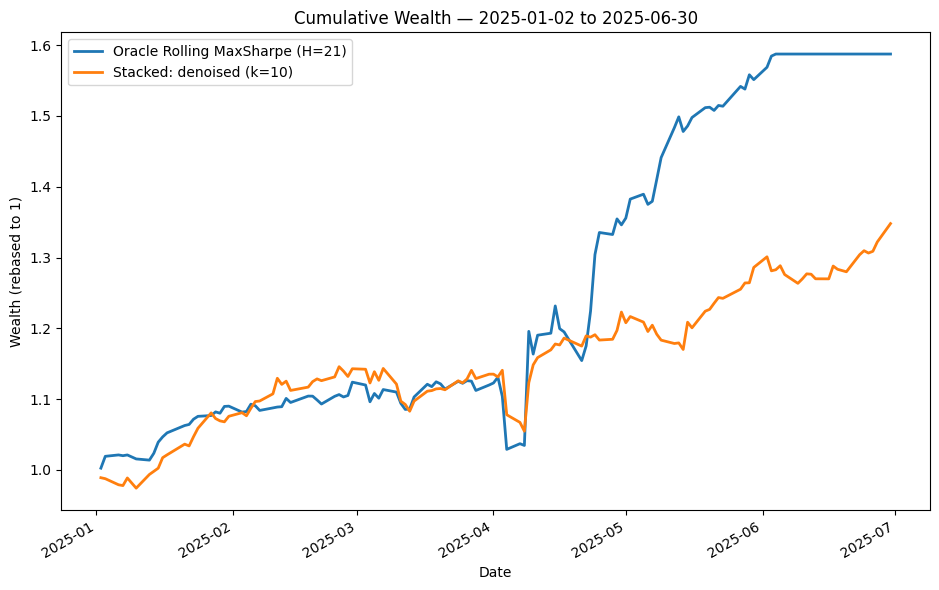

In [ ]:
# === Use precomputed series ===
# Assumes:
#   oos_stacked_df from run_stacked_models_and_plot(...)
#   out_oracles     from run_oracle_benchmarks(...)
#   TEST_START / TEST_END already defined (e.g., "2025-01-02" .. "2025-06-30")

import pandas as pd
import matplotlib.pyplot as plt

# pick the columns directly from stored DataFrames
stacked_den10 = oos_stacked_df["Stacked: denoised (k=10)"].loc[TEST_START:TEST_END]
oracle_roll   = out_oracles["Oracle Rolling MaxSharpe (H=21)"].loc[TEST_START:TEST_END]

# align and drop any non-overlap
comp = pd.concat(
    [stacked_den10.rename("Stacked: denoised (k=10)"),
     oracle_roll.rename("Oracle Rolling MaxSharpe (H=21)")],
    axis=1
).dropna()

# cumulative wealth (rebased to 1)
cum = (1.0 + comp).cumprod()

plt.figure(figsize=(9.5,6))
cum["Oracle Rolling MaxSharpe (H=21)"].plot(label="Oracle Rolling MaxSharpe (H=21)", linewidth=2.0)
cum["Stacked: denoised (k=10)"].plot(label="Stacked: denoised (k=10)", linewidth=2.0)
plt.title(f"Cumulative Wealth — {TEST_START} to {TEST_END}")
plt.ylabel("Wealth (rebased to 1)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()


In [41]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV

# ---------- config ----------
H_BLOCK = 21
WINDOW  = 126
INNER_VAL = 21
K_GRID  = [5, 10, 15]
ALPHAS_RIDGE = np.logspace(-8, 4, 50)
ALPHAS_LASSO = np.logspace(-8, 4, 50)
TRADING_DAYS = 252

# ---------- helpers you already had ----------
def normalize_budget(w):
    s = w.sum(); return w/s if s != 0 else w

def regression_reframe(Rw):
    T, p = Rw.shape
    w_ew = np.ones(p)/p
    N = np.vstack([np.eye(p-1), -np.ones((1,p-1))])  # p x (p-1)
    y = Rw @ w_ew
    X = Rw @ N
    return y, X, w_ew, N

def denoise_returns(R_window, k_top=10):
    R_c = R_window - R_window.mean(axis=0)
    U,S,Vt = np.linalg.svd(R_c, full_matrices=False)
    S2 = np.zeros_like(S); S2[:k_top] = S[:k_top]
    return U @ np.diag(S2) @ Vt + R_window.mean(axis=0)

def ann_ret(x):
    s = pd.Series(x).dropna()
    if len(s)==0: return np.nan
    return (1+s).prod()**(TRADING_DAYS/len(s))-1

def ann_sharpe(x):
    s = pd.Series(x).dropna(); sd = s.std(ddof=1)
    return np.sqrt(TRADING_DAYS)*s.mean()/sd if sd>0 else np.nan

# ---------- Option A: Stacked-denoised with 21d rebalancing (weights frozen per block) ----------
def stacked_denoised_block_hold(returns_df, start=None, end=None, window=WINDOW, H=H_BLOCK, k_denoise=10):
    # compute across full history (so training windows exist), slice at end
    dates = returns_df.index
    daily = np.zeros(len(dates))
    weights = {}
    t = window
    while t + H <= len(dates):
        R_train_raw = returns_df.iloc[t-window:t, :].values
        Rw = denoise_returns(R_train_raw, k_top=k_denoise)

        # EW-anchored reframe
        y, X, w_ew, N = regression_reframe(Rw)

        # time-aware inner split
        if len(X) <= INNER_VAL + 5:
            t += H; continue
        X_tr, X_val = X[:-INNER_VAL,:], X[-INNER_VAL:,:]
        y_tr, y_val = y[:-INNER_VAL],   y[-INNER_VAL:]

        # choose between PCA(k)+Ridge and PCA(k)+LASSO by validation Sharpe
        best, best_params = -np.inf, ("ridge", K_GRID[0], ALPHAS_RIDGE[0])
        for k in K_GRID:
            pca  = PCA(n_components=k).fit(X_tr)
            Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)

            ridge = RidgeCV(alphas=ALPHAS_RIDGE).fit(Z_tr, y_tr)
            yhat_r = ridge.predict(Z_val)
            sr_r   = (yhat_r.mean()/yhat_r.std(ddof=1)) if yhat_r.std(ddof=1)>0 else -np.inf
            if sr_r > best: best, best_params = sr_r, ("ridge", k, ridge.alpha_)

            lasso = LassoCV(alphas=ALPHAS_LASSO, cv=5, max_iter=5000).fit(Z_tr, y_tr)
            yhat_l = lasso.predict(Z_val)
            sr_l   = (yhat_l.mean()/yhat_l.std(ddof=1)) if yhat_l.std(ddof=1)>0 else -np.inf
            if sr_l > best: best, best_params = sr_l, ("lasso", k, lasso.alpha_)

        mtype, k_star, alpha_star = best_params
        pca_full = PCA(n_components=k_star).fit(X)
        Z_full   = pca_full.transform(X)

        if mtype == "ridge":
            base = RidgeCV(alphas=[alpha_star]).fit(Z_full, y)
            beta = pca_full.components_.T @ base.coef_
        else:
            base = LassoCV(alphas=[alpha_star], cv=None, max_iter=5000).fit(Z_full, y)
            beta = pca_full.components_.T @ base.coef_

        w = normalize_budget(w_ew - (N @ beta))
        weights[dates[t]] = w

        # hold weights for next H days
        block = returns_df.iloc[t:t+H, :].values
        daily[t:t+H] = block @ w
        t += H

    ser = pd.Series(daily, index=dates, name=f"Stacked denoised (k={k_denoise}) — 21d hold")
    if start or end:
        ser = ser.loc[start:end]
    return ser, weights

# ---------- Option B: Daily clairvoyant oracle (long-only, sum-to-1) ----------
def oracle_daily_best(returns_df, start=None, end=None):
    df = returns_df.copy()
    if start: df = df.loc[start:]
    if end:   df = df.loc[:end]
    # long-only simplex => put all weight on the asset with max same-day return
    best = df.max(axis=1)
    best.name = "Oracle Daily Best (long-only)"
    return best

# ---------- Example usage & plotting ----------
# Define your comparison window (same as you used for the oracle)
TEST_START = "2025-01-02"
TEST_END   = "2025-06-30"

# A) stacked with 21d hold
# stack21_ser, stack21_w = stacked_denoised_block_hold(returns_df, start=TEST_START, end=TEST_END, k_denoise=10)

# # B) daily clairvoyant
# # oracle_daily = oracle_daily_best(returns_df, start=TEST_START, end=TEST_END)

# # Rolling oracle (you already have oracle_rolling_block_maxsharpe; reuse your existing one or out_oracles column)
# oracle_roll = oracle_rolling_block_maxsharpe(returns_df.loc[TEST_START:TEST_END], H=H_BLOCK, long_only=True)

# # Align and show metrics
# comp = pd.concat([oracle_roll.rename("Oracle Rolling MaxSharpe (H=21)"),
#                   stack21_ser,
#                   oracle_daily], axis=1).dropna()

# metrics = {c: {"AnnReturn": ann_ret(comp[c]), "AnnSharpe": ann_sharpe(comp[c])} for c in comp.columns}
# metrics_df = pd.DataFrame(metrics).T.sort_values("AnnSharpe", ascending=False)
# print("Annualized metrics (test window):")
# display(metrics_df.round(4))

# # Plot
# cum = (1.0 + comp).cumprod()
# plt.figure(figsize=(10,6))
# for col in cum.columns:
#     plt.plot(cum.index, cum[col], label=col, linewidth=1.8)
# plt.title(f"Cumulative Wealth — {TEST_START} to {TEST_END}")
# plt.ylabel("Wealth (rebased to 1)")
# plt.xlabel("Date")
# plt.legend()
# plt.tight_layout()
# plt.show()


Annualized metrics (test window):


AnnReturn  AnnSharpe
Oracle Rolling MaxSharpe (H=21)        1.5974     3.2205
Stacked denoised (k=10) — 21d hold     0.5018     2.3248

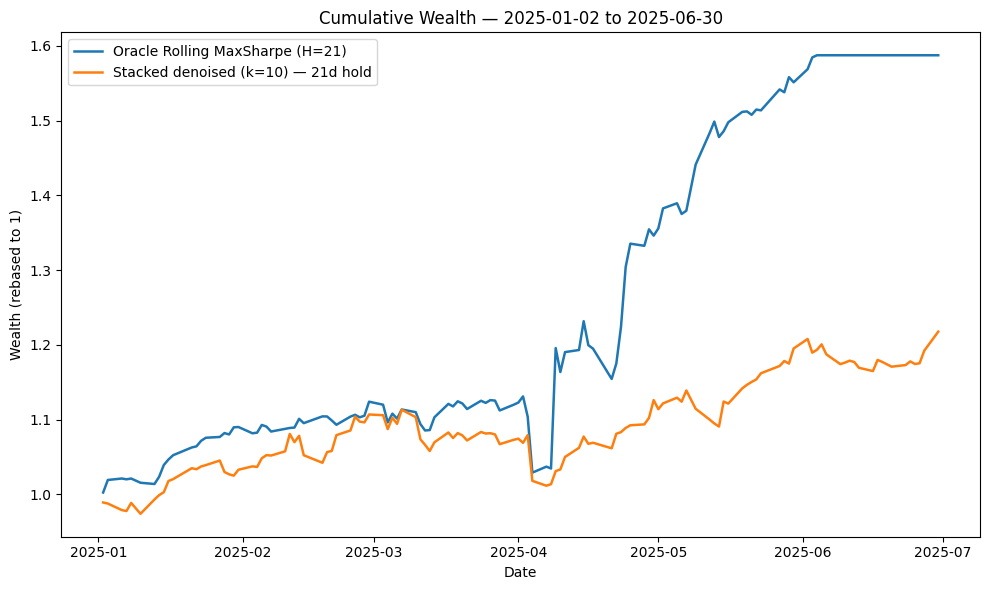

In [ ]:
# # A) stacked with 21d hold
stack21_ser, stack21_w = stacked_denoised_block_hold(returns_df, start=TEST_START, end=TEST_END, k_denoise=10)

# # B) daily clairvoyant
# # oracle_daily = oracle_daily_best(returns_df, start=TEST_START, end=TEST_END)

# # Rolling oracle (you already have oracle_rolling_block_maxsharpe; reuse your existing one or out_oracles column)
oracle_roll = oracle_rolling_block_maxsharpe(returns_df.loc[TEST_START:TEST_END], H=H_BLOCK, long_only=True)

# Align and show metrics
comp = pd.concat([oracle_roll.rename("Oracle Rolling MaxSharpe (H=21)"),
                  stack21_ser], axis=1).dropna()

metrics = {c: {"AnnReturn": ann_ret(comp[c]), "AnnSharpe": ann_sharpe(comp[c])} for c in comp.columns}
metrics_df = pd.DataFrame(metrics).T.sort_values("AnnSharpe", ascending=False)
print("Annualized metrics (test window):")
display(metrics_df.round(4))

# Plot
cum = (1.0 + comp).cumprod()
plt.figure(figsize=(10,6))
for col in cum.columns:
    plt.plot(cum.index, cum[col], label=col, linewidth=1.8)
plt.title(f"Cumulative Wealth — {TEST_START} to {TEST_END}")
plt.ylabel("Wealth (rebased to 1)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

=== June 2025 — Unseen test (static weights from 126d up to 2025-05-31) ===
Chosen base: PCA+Ridge (k=10, alpha=1e-08),  validation Sharpe (inner): 0.205
Non-annualized Sharpe (June): 0.116
Annualized Sharpe (June):     1.842
Annualized Return (June):     29.35%


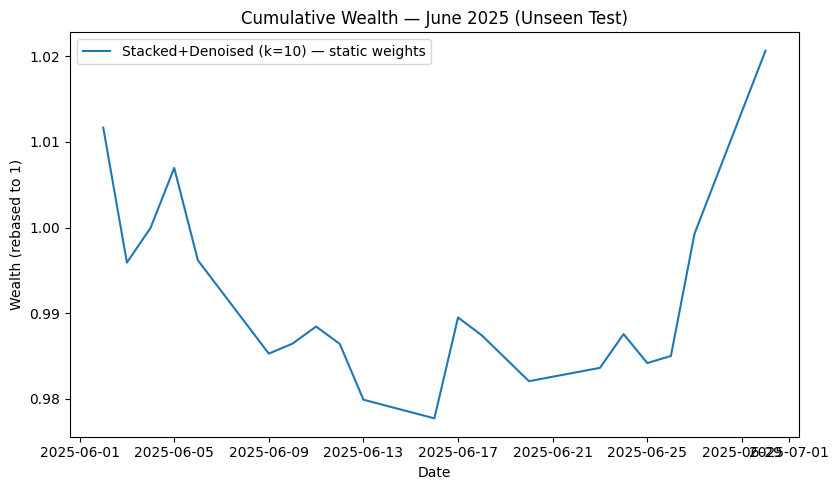

In [42]:
# ===================== Test on unseen June 2025 (Stacked + Denoised k=10) =====================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV

# --- assumes these exist from your previous cell ---
# WINDOW = 126
# INNER_VAL = 21
# TRADING_DAYS = 252
# denoise_returns, regression_reframe, normalize_budget, ann_sharpe, ann_return, sharpe_ratio

def fit_stacked_denoised_k10_on_window(R_window, k_denoise=10, k_grid=(5,10,15),
                                       alphas_ridge=np.logspace(-8,4,50),
                                       alphas_lasso=np.logspace(-8,4,50),
                                       inner_val=INNER_VAL):
    """
    Train the stacked-denoised (k=10) model ONCE on a given window (T x p) and return a single weight vector.
    Uses the same selection logic as your rolling function:
      - Denoise (SVD top-k)
      - Reframe y=Rw_EW, X=RN
      - Time-aware inner split
      - Try PCA(k)+Ridge and PCA(k)+LASSO; pick by validation Sharpe
      - Refit on full window and map back to weights w = w_EW - N beta
    """
    # 1) Denoise
    Rw = denoise_returns(R_window, k_top=k_denoise)

    # 2) EW reframe
    y, X, w_ew, N = regression_reframe(Rw)

    # 3) Inner split
    if len(X) <= inner_val + 5:
        raise ValueError("Not enough observations in the training window for inner validation.")
    X_tr, X_val = X[:-inner_val, :], X[-inner_val:, :]
    y_tr, y_val = y[:-inner_val],   y[-inner_val:]

    # 4) Model selection
    best_score, best_params = -np.inf, ("ridge", k_grid[0], alphas_ridge[0])
    for k in k_grid:
        pca  = PCA(n_components=k).fit(X_tr)
        Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)

        # Ridge branch
        ridge = RidgeCV(alphas=alphas_ridge).fit(Z_tr, y_tr)
        yhat_r = ridge.predict(Z_val)
        sr_r   = sharpe_ratio(yhat_r)
        if sr_r > best_score:
            best_score, best_params = sr_r, ("ridge", k, ridge.alpha_)

        # LASSO branch
        lasso = LassoCV(alphas=alphas_lasso, cv=5, max_iter=5000).fit(Z_tr, y_tr)
        yhat_l = lasso.predict(Z_val)
        sr_l   = sharpe_ratio(yhat_l)
        if sr_l > best_score:
            best_score, best_params = sr_l, ("lasso", k, lasso.alpha_)

    # 5) Refit on full window with chosen params
    mtype, k_star, alpha_star = best_params
    pca_full = PCA(n_components=k_star).fit(X)
    Z_full   = pca_full.transform(X)

    if mtype == "ridge":
        base = RidgeCV(alphas=[alpha_star]).fit(Z_full, y)
        beta = pca_full.components_.T @ base.coef_
    else:
        base = LassoCV(alphas=[alpha_star], cv=None, max_iter=5000).fit(Z_full, y)
        beta = pca_full.components_.T @ base.coef_

    w = normalize_budget(w_ew - (N @ beta))

    meta = {"model": f"PCA+{mtype.capitalize()} (k={k_star}, alpha={alpha_star:.3g})",
            "val_sharpe": float(best_score), "k_denoise": k_denoise}
    return w, meta

def test_jun_2025_stacked_denoised_k10(returns_df,
                                          train_end="2025-05-31",
                                          test_start="2025-06-01",
                                          test_end="2025-06-30",
                                          window=WINDOW):
    """
    Fit once on last `window` days up to `train_end`, then apply STATIC weights to daily returns in Aug 2025.
    No August data are used in fitting.
    """
    # 0) basic checks and slicing
    df = returns_df.sort_index().copy()
    if train_end not in df.index:
        # pick the last available date <= train_end
        train_end = df.index[df.index.get_indexer([train_end], method="pad")[0]]
    train_slice = df.loc[:train_end].tail(window)
    if len(train_slice) < window:
        raise ValueError(f"Need at least {window} training days before {train_end}.")

    # 1) fit on training window (up to 2025-05-31)
    w, meta = fit_stacked_denoised_k10_on_window(train_slice.values, k_denoise=10)

    # 2) evaluate on Jun 2025
    test_df = df.loc[test_start:test_end]
    if test_df.empty:
        raise ValueError("No test rows found for the requested June 2025 window.")
    test_ret = pd.Series(test_df.values @ w, index=test_df.index, name="Stacked+Denoised(k=10) [static weights]")

    # 3) metrics
    sr = sharpe_ratio(test_ret)         # non-annualized
    sr_ann = ann_sharpe(test_ret)       # optional
    ar_ann = ann_return(test_ret)       # optional

    print("=== June 2025 — Unseen test (static weights from 126d up to 2025-05-31) ===")
    print(f"Chosen base: {meta['model']},  validation Sharpe (inner): {meta['val_sharpe']:.3f}")
    print(f"Non-annualized Sharpe (June): {sr:.3f}")
    print(f"Annualized Sharpe (June):     {sr_ann:.3f}")
    print(f"Annualized Return (June):     {ar_ann:.2%}")

    # 4) plot cumulative wealth over June
    cum = (1.0 + test_ret).cumprod()
    plt.figure(figsize=(8.5,5))
    plt.plot(cum.index, cum.values, label="Stacked+Denoised (k=10) — static weights")
    plt.title("Cumulative Wealth — June 2025 (Unseen Test)")
    plt.ylabel("Wealth (rebased to 1)")
    plt.xlabel("Date")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5) return for further analysis
    return test_ret, w, meta

# --------- Run the unseen-June test ----------
# Expect: `returns_df` contains daily DECIMAL returns with Jun-2025 rows present
jun_series, jun_weights, jun_meta = test_jun_2025_stacked_denoised_k10(returns_df)


In [ ]:
# ===================== Test on unseen August 2025 (Stacked + Denoised k=10) =====================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV

# --- assumes these exist from your previous cell ---
# WINDOW = 126
# INNER_VAL = 21
# TRADING_DAYS = 252
# denoise_returns, regression_reframe, normalize_budget, ann_sharpe, ann_return, sharpe_ratio

def fit_stacked_denoised_k10_on_window(R_window, k_denoise=10, k_grid=(5,10,15),
                                       alphas_ridge=np.logspace(-8,4,50),
                                       alphas_lasso=np.logspace(-8,4,50),
                                       inner_val=INNER_VAL):
    """
    Train the stacked-denoised (k=10) model ONCE on a given window (T x p) and return a single weight vector.
    Uses the same selection logic as your rolling function:
      - Denoise (SVD top-k)
      - Reframe y=Rw_EW, X=RN
      - Time-aware inner split
      - Try PCA(k)+Ridge and PCA(k)+LASSO; pick by validation Sharpe
      - Refit on full window and map back to weights w = w_EW - N beta
    """
    # 1) Denoise
    Rw = denoise_returns(R_window, k_top=k_denoise)

    # 2) EW reframe
    y, X, w_ew, N = regression_reframe(Rw)

    # 3) Inner split
    if len(X) <= inner_val + 5:
        raise ValueError("Not enough observations in the training window for inner validation.")
    X_tr, X_val = X[:-inner_val, :], X[-inner_val:, :]
    y_tr, y_val = y[:-inner_val],   y[-inner_val:]

    # 4) Model selection
    best_score, best_params = -np.inf, ("ridge", k_grid[0], alphas_ridge[0])
    for k in k_grid:
        pca  = PCA(n_components=k).fit(X_tr)
        Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)

        # Ridge branch
        ridge = RidgeCV(alphas=alphas_ridge).fit(Z_tr, y_tr)
        yhat_r = ridge.predict(Z_val)
        sr_r   = sharpe_ratio(yhat_r)
        if sr_r > best_score:
            best_score, best_params = sr_r, ("ridge", k, ridge.alpha_)

        # LASSO branch
        lasso = LassoCV(alphas=alphas_lasso, cv=5, max_iter=5000).fit(Z_tr, y_tr)
        yhat_l = lasso.predict(Z_val)
        sr_l   = sharpe_ratio(yhat_l)
        if sr_l > best_score:
            best_score, best_params = sr_l, ("lasso", k, lasso.alpha_)

    # 5) Refit on full window with chosen params
    mtype, k_star, alpha_star = best_params
    pca_full = PCA(n_components=k_star).fit(X)
    Z_full   = pca_full.transform(X)

    if mtype == "ridge":
        base = RidgeCV(alphas=[alpha_star]).fit(Z_full, y)
        beta = pca_full.components_.T @ base.coef_
    else:
        base = LassoCV(alphas=[alpha_star], cv=None, max_iter=5000).fit(Z_full, y)
        beta = pca_full.components_.T @ base.coef_

    w = normalize_budget(w_ew - (N @ beta))

    meta = {"model": f"PCA+{mtype.capitalize()} (k={k_star}, alpha={alpha_star:.3g})",
            "val_sharpe": float(best_score), "k_denoise": k_denoise}
    return w, meta

def test_august_2025_stacked_denoised_k10(returns_df,
                                          train_end="2025-07-31",
                                          test_start="2025-08-01",
                                          test_end="2025-08-31",
                                          window=WINDOW):
    """
    Fit once on last `window` days up to `train_end`, then apply STATIC weights to daily returns in Aug 2025.
    No August data are used in fitting.
    """
    # 0) basic checks and slicing
    df = returns_df.sort_index().copy()
    if train_end not in df.index:
        # pick the last available date <= train_end
        train_end = df.index[df.index.get_indexer([train_end], method="pad")[0]]
    train_slice = df.loc[:train_end].tail(window)
    if len(train_slice) < window:
        raise ValueError(f"Need at least {window} training days before {train_end}.")

    # 1) fit on training window (up to 2025-07-31)
    w, meta = fit_stacked_denoised_k10_on_window(train_slice.values, k_denoise=10)

    # 2) evaluate on Aug 2025
    test_df = df.loc[test_start:test_end]
    if test_df.empty:
        raise ValueError("No test rows found for the requested August 2025 window.")
    test_ret = pd.Series(test_df.values @ w, index=test_df.index, name="Stacked+Denoised(k=10) [static weights]")

    # 3) metrics
    sr = sharpe_ratio(test_ret)         # non-annualized
    sr_ann = ann_sharpe(test_ret)       # optional
    ar_ann = ann_return(test_ret)       # optional

    print("=== August 2025 — Unseen test (static weights from 126d up to 2025-07-31) ===")
    print(f"Chosen base: {meta['model']},  validation Sharpe (inner): {meta['val_sharpe']:.3f}")
    print(f"Non-annualized Sharpe (Aug): {sr:.3f}")
    print(f"Annualized Sharpe (Aug):     {sr_ann:.3f}")
    print(f"Annualized Return (Aug):     {ar_ann:.2%}")

    # 4) plot cumulative wealth over August
    cum = (1.0 + test_ret).cumprod()
    plt.figure(figsize=(8.5,5))
    plt.plot(cum.index, cum.values, label="Stacked+Denoised (k=10) — static weights")
    plt.title("Cumulative Wealth — August 2025 (Unseen Test)")
    plt.ylabel("Wealth (rebased to 1)")
    plt.xlabel("Date")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5) return for further analysis
    return test_ret, w, meta

# --------- Run the unseen-August test ----------
# Expect: `returns_df` contains daily DECIMAL returns with Aug-2025 rows present
aug_series, aug_weights, aug_meta = test_august_2025_stacked_denoised_k10(returns_df)


=== June 2025 — Rolling-window OOS (refit daily, 126d lookback) ===
Non-annualized Sharpe (Jun): 0.258
Annualized Sharpe (Jun):     4.095
Annualized Return (Jun):     80.86%
Avg daily turnover:          0.600

Model selection counts (by day):
PCA+Lasso (k=10, alpha=1e-08)    8
PCA+Ridge (k=10, alpha=1e-08)    4
PCA+Lasso (k=5, alpha=1e-08)     3
PCA+Ridge (k=15, alpha=1e-08)    3
PCA+Lasso (k=15, alpha=1e-08)    2


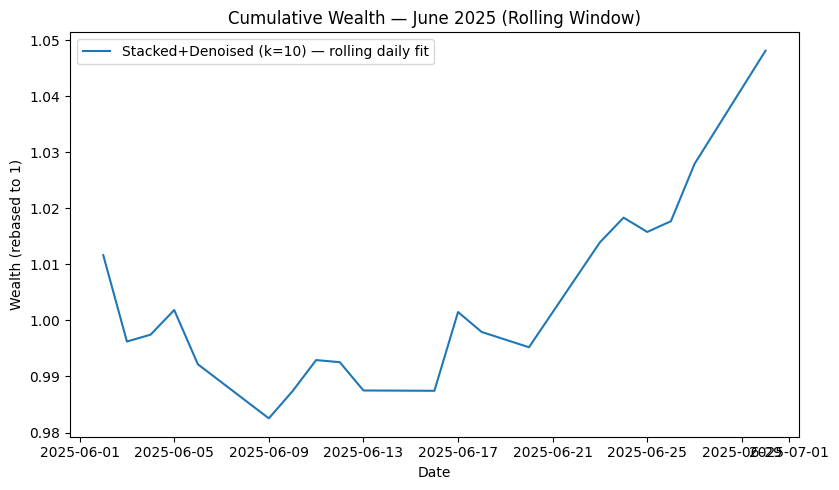

In [43]:
# ================= Rolling-window test (June 2025) — Stacked + Denoised (k=10) =================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV

# expects: WINDOW, INNER_VAL, TRADING_DAYS
# and helpers already defined: denoise_returns, regression_reframe, normalize_budget,
#                              sharpe_ratio, ann_sharpe, ann_return

def fit_one_day_stacked_denoised_k10(R_hist, k_denoise=10, k_grid=(5,10,15),
                                     alphas_ridge=np.logspace(-8,4,50),
                                     alphas_lasso=np.logspace(-8,4,50),
                                     inner_val=INNER_VAL):
    """Fit the model on a history window (T x p) and return weights for *next* day."""
    # 1) denoise
    Rw = denoise_returns(R_hist, k_top=k_denoise)
    # 2) EW reframe
    y, X, w_ew, N = regression_reframe(Rw)

    if len(X) <= inner_val + 5:
        raise ValueError("Insufficient observations for inner validation split.")

    # 3) inner split
    X_tr, X_val = X[:-inner_val, :], X[-inner_val:, :]
    y_tr, y_val = y[:-inner_val],   y[-inner_val:]

    # 4) model selection by validation Sharpe
    best_score, best_params = -np.inf, ("ridge", k_grid[0], alphas_ridge[0])
    for k in k_grid:
        pca  = PCA(n_components=k).fit(X_tr)
        Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)

        ridge = RidgeCV(alphas=alphas_ridge).fit(Z_tr, y_tr)
        sr_r  = sharpe_ratio(ridge.predict(Z_val))
        if sr_r > best_score:
            best_score, best_params = sr_r, ("ridge", k, ridge.alpha_)

        lasso = LassoCV(alphas=alphas_lasso, cv=5, max_iter=5000).fit(Z_tr, y_tr)
        sr_l  = sharpe_ratio(lasso.predict(Z_val))
        if sr_l > best_score:
            best_score, best_params = sr_l, ("lasso", k, lasso.alpha_)

    # 5) refit on full window with chosen params, map back to weights
    mtype, k_star, alpha_star = best_params
    pca_full = PCA(n_components=k_star).fit(X)
    Z_full   = pca_full.transform(X)

    if mtype == "ridge":
        base = RidgeCV(alphas=[alpha_star]).fit(Z_full, y)
        beta = pca_full.components_.T @ base.coef_
    else:
        base = LassoCV(alphas=[alpha_star], cv=None, max_iter=5000).fit(Z_full, y)
        beta = pca_full.components_.T @ base.coef_

    w = normalize_budget(w_ew - (N @ beta))
    meta = {"chosen": f"PCA+{mtype.capitalize()} (k={k_star}, alpha={alpha_star:.3g})",
            "val_sharpe": float(best_score)}
    return w, meta

def rolling_test_jun_2025_stacked_denoised_k10(returns_df,
                                               test_start="2025-06-01",
                                               test_end="2025-06-30",
                                               window=126):
    """
    For each test day t in [test_start, test_end]:
      - Fit on the *previous* `window` days [t-window, t)
      - Trade at t with that day's weights (no look-ahead)
    """
    df = returns_df.sort_index().copy()
    test_idx = df.loc[test_start:test_end].index
    if len(test_idx) == 0:
        raise ValueError("No rows in the requested test window.")

    # ensure we have enough history before first test day
    first_t = test_idx[0]
    hist = df.loc[:first_t].iloc[:-1]  # strictly before t
    if len(hist) < window:
        raise ValueError(f"Need at least {window} pre-test days before {first_t}.")

    rets, picks, weights = [], [], []
    prev_w = None
    for t in test_idx:
        # training window ends at t-1
        R_hist = df.loc[:t].iloc[:-1].tail(window).values
        w_t, meta = fit_one_day_stacked_denoised_k10(R_hist, k_denoise=10)
        r_t = float(df.loc[t].values @ w_t)

        rets.append((t, r_t))
        picks.append((t, meta["chosen"], meta["val_sharpe"]))
        weights.append((t, w_t, prev_w))
        prev_w = w_t

    # assemble results
    ser = pd.Series([r for _, r in rets], index=[d for d, _ in rets],
                    name="Stacked+Denoised(k=10) [rolling daily fit]")

    # metrics
    sr   = sharpe_ratio(ser)       # non-annualized
    sr_a = ann_sharpe(ser)         # optional
    ar_a = ann_return(ser)         # optional

    # turnover (optional)
    if len(weights) > 1:
        tw = []
        for _, w_now, w_prev in weights[1:]:
            tw.append(0.5*np.abs(w_now - w_prev).sum())
        avg_turnover = float(np.mean(tw))
    else:
        avg_turnover = np.nan

    print("=== June 2025 — Rolling-window OOS (refit daily, 126d lookback) ===")
    print(f"Non-annualized Sharpe (Jun): {sr:.3f}")
    print(f"Annualized Sharpe (Jun):     {sr_a:.3f}")
    print(f"Annualized Return (Jun):     {ar_a:.2%}")
    print(f"Avg daily turnover:          {avg_turnover:.3f}")
    # quick tally of selected bases
    sel = pd.Series([m for _, m, _ in picks]).value_counts()
    print("\nModel selection counts (by day):")
    print(sel.to_string())

    # plot cumulative wealth
    cum = (1.0 + ser).cumprod()
    plt.figure(figsize=(8.5,5))
    plt.plot(cum.index, cum.values, label="Stacked+Denoised (k=10) — rolling daily fit")
    plt.title("Cumulative Wealth — June 2025 (Rolling Window)")
    plt.ylabel("Wealth (rebased to 1)")
    plt.xlabel("Date")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return ser, pd.DataFrame(picks, columns=["date","chosen_base","val_sharpe"]).set_index("date")

# ---------------- Run rolling-window August test ----------------
# Expect: `returns_df` has daily DECIMAL returns including June-2025
jun_roll_series, jun_roll_selection = rolling_test_jun_2025_stacked_denoised_k10(returns_df)


In [ ]:
# ================= Rolling-window test (August 2025) — Stacked + Denoised (k=10) =================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV

# expects: WINDOW, INNER_VAL, TRADING_DAYS
# and helpers already defined: denoise_returns, regression_reframe, normalize_budget,
#                              sharpe_ratio, ann_sharpe, ann_return

def fit_one_day_stacked_denoised_k10(R_hist, k_denoise=10, k_grid=(5,10,15),
                                     alphas_ridge=np.logspace(-8,4,50),
                                     alphas_lasso=np.logspace(-8,4,50),
                                     inner_val=INNER_VAL):
    """Fit the model on a history window (T x p) and return weights for *next* day."""
    # 1) denoise
    Rw = denoise_returns(R_hist, k_top=k_denoise)
    # 2) EW reframe
    y, X, w_ew, N = regression_reframe(Rw)

    if len(X) <= inner_val + 5:
        raise ValueError("Insufficient observations for inner validation split.")

    # 3) inner split
    X_tr, X_val = X[:-inner_val, :], X[-inner_val:, :]
    y_tr, y_val = y[:-inner_val],   y[-inner_val:]

    # 4) model selection by validation Sharpe
    best_score, best_params = -np.inf, ("ridge", k_grid[0], alphas_ridge[0])
    for k in k_grid:
        pca  = PCA(n_components=k).fit(X_tr)
        Z_tr, Z_val = pca.transform(X_tr), pca.transform(X_val)

        ridge = RidgeCV(alphas=alphas_ridge).fit(Z_tr, y_tr)
        sr_r  = sharpe_ratio(ridge.predict(Z_val))
        if sr_r > best_score:
            best_score, best_params = sr_r, ("ridge", k, ridge.alpha_)

        lasso = LassoCV(alphas=alphas_lasso, cv=5, max_iter=5000).fit(Z_tr, y_tr)
        sr_l  = sharpe_ratio(lasso.predict(Z_val))
        if sr_l > best_score:
            best_score, best_params = sr_l, ("lasso", k, lasso.alpha_)

    # 5) refit on full window with chosen params, map back to weights
    mtype, k_star, alpha_star = best_params
    pca_full = PCA(n_components=k_star).fit(X)
    Z_full   = pca_full.transform(X)

    if mtype == "ridge":
        base = RidgeCV(alphas=[alpha_star]).fit(Z_full, y)
        beta = pca_full.components_.T @ base.coef_
    else:
        base = LassoCV(alphas=[alpha_star], cv=None, max_iter=5000).fit(Z_full, y)
        beta = pca_full.components_.T @ base.coef_

    w = normalize_budget(w_ew - (N @ beta))
    meta = {"chosen": f"PCA+{mtype.capitalize()} (k={k_star}, alpha={alpha_star:.3g})",
            "val_sharpe": float(best_score)}
    return w, meta

def rolling_test_aug_2025_stacked_denoised_k10(returns_df,
                                               test_start="2025-08-01",
                                               test_end="2025-08-31",
                                               window=126):
    """
    For each test day t in [test_start, test_end]:
      - Fit on the *previous* `window` days [t-window, t)
      - Trade at t with that day's weights (no look-ahead)
    """
    df = returns_df.sort_index().copy()
    test_idx = df.loc[test_start:test_end].index
    if len(test_idx) == 0:
        raise ValueError("No rows in the requested test window.")

    # ensure we have enough history before first test day
    first_t = test_idx[0]
    hist = df.loc[:first_t].iloc[:-1]  # strictly before t
    if len(hist) < window:
        raise ValueError(f"Need at least {window} pre-test days before {first_t}.")

    rets, picks, weights = [], [], []
    prev_w = None
    for t in test_idx:
        # training window ends at t-1
        R_hist = df.loc[:t].iloc[:-1].tail(window).values
        w_t, meta = fit_one_day_stacked_denoised_k10(R_hist, k_denoise=10)
        r_t = float(df.loc[t].values @ w_t)

        rets.append((t, r_t))
        picks.append((t, meta["chosen"], meta["val_sharpe"]))
        weights.append((t, w_t, prev_w))
        prev_w = w_t

    # assemble results
    ser = pd.Series([r for _, r in rets], index=[d for d, _ in rets],
                    name="Stacked+Denoised(k=10) [rolling daily fit]")

    # metrics
    sr   = sharpe_ratio(ser)       # non-annualized
    sr_a = ann_sharpe(ser)         # optional
    ar_a = ann_return(ser)         # optional

    # turnover (optional)
    if len(weights) > 1:
        tw = []
        for _, w_now, w_prev in weights[1:]:
            tw.append(0.5*np.abs(w_now - w_prev).sum())
        avg_turnover = float(np.mean(tw))
    else:
        avg_turnover = np.nan

    print("=== August 2025 — Rolling-window OOS (refit daily, 126d lookback) ===")
    print(f"Non-annualized Sharpe (Aug): {sr:.3f}")
    print(f"Annualized Sharpe (Aug):     {sr_a:.3f}")
    print(f"Annualized Return (Aug):     {ar_a:.2%}")
    print(f"Avg daily turnover:          {avg_turnover:.3f}")
    # quick tally of selected bases
    sel = pd.Series([m for _, m, _ in picks]).value_counts()
    print("\nModel selection counts (by day):")
    print(sel.to_string())

    # plot cumulative wealth
    cum = (1.0 + ser).cumprod()
    plt.figure(figsize=(8.5,5))
    plt.plot(cum.index, cum.values, label="Stacked+Denoised (k=10) — rolling daily fit")
    plt.title("Cumulative Wealth — August 2025 (Rolling Window)")
    plt.ylabel("Wealth (rebased to 1)")
    plt.xlabel("Date")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return ser, pd.DataFrame(picks, columns=["date","chosen_base","val_sharpe"]).set_index("date")

# ---------------- Run rolling-window August test ----------------
# Expect: `returns_df` has daily DECIMAL returns including Aug-2025
aug_roll_series, aug_roll_selection = rolling_test_aug_2025_stacked_denoised_k10(returns_df)
